# Stats 202 Final Project

Google colab for collaboration on our code.

Overleaf link: https://www.overleaf.com/project/60ff379940b9c86dfe297f07

# Libraries

In [ ]:
if(!require(forecastML)){
  install.packages("forecastML")
}
if(!require(xgboost)){
    install.packages("xgboost")
}
if(!require(hash)){
    install.packages("hash")
}
if(!require(glmnet)){
    install.packages("glmnet")
}
if(!require(randomForest)){
    install.packages("randomForest")
}
if(!require(tseries)){
    install.packages("tseries")
}

Loading required package: forecastML

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘forecastML’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’


Loading required package: xgboost

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘xgboost’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: hash

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘hash’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: glmnet

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.retu

In [ ]:
suppressMessages(library(tidyverse))
suppressMessages(library(forecastML))
suppressMessages(library(hash))
suppressMessages(library(glmnet))
suppressMessages(library(randomForest))
suppressMessages(library(tseries))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# Import Data

Download the train csv file from the public link on our shared drive:

In [ ]:
system("gdown --id 1nb6GXyamtGYNn75UcFrZ46m9vnK6Uv_N")

In [ ]:
df <- read.csv(file='train_data.csv')

## Basic summary statistics

In [ ]:
# Basic study of the data dimensions
nrow(df)
ncol(df)
names(df)

# Confirm number of stock symbols in the data set, and see how many 
# observations there are for each ticker.
table(df$symbol)
sum(is.na(df))

[1] 4330254

[1] 8

[1] "symbol"  "open"    "high"    "low"     "close"   "average" "time"   
[8] "day"


     A      B      C      D      E      F      G      H      I      J 
426897 427909 438480 437040 438229 412631 436946 437760 437040 437322 

[1] 0

Even though there are no NA's in the data set, the number of observations differs by ticker, indicating missing data. We address this later on.

In [ ]:
# Summary of the full data set
summary(df)

# Summary of the data set by ticker
tickers <- c("A","B","C","D","E","F","G","H","I","J")
for(i in tickers){
print(summary(df[df$symbol==i, ]))
}

    symbol               open             high             low        
 Length:4330254     Min.   : 77.05   Min.   : 77.05   Min.   : 77.04  
 Class :character   1st Qu.:107.99   1st Qu.:107.99   1st Qu.:107.98  
 Mode  :character   Median :150.81   Median :150.82   Median :150.81  
                    Mean   :147.99   Mean   :147.99   Mean   :147.98  
                    3rd Qu.:177.20   3rd Qu.:177.21   3rd Qu.:177.20  
                    Max.   :258.45   Max.   :258.46   Max.   :258.45  
     close           average           time                day       
 Min.   : 77.04   Min.   : 77.05   Length:4330254     Min.   : 0.00  
 1st Qu.:107.99   1st Qu.:107.99   Class :character   1st Qu.:21.00  
 Median :150.81   Median :150.81   Mode  :character   Median :43.00  
 Mean   :147.99   Mean   :147.99                      Mean   :43.03  
 3rd Qu.:177.20   3rd Qu.:177.20                      3rd Qu.:65.00  
 Max.   :258.46   Max.   :258.46                      Max.   :86.00  

    symbol               open            high            low       
 Length:426897      Min.   :130.7   Min.   :130.7   Min.   :130.6  
 Class :character   1st Qu.:136.0   1st Qu.:136.0   1st Qu.:136.0  
 Mode  :character   Median :140.6   Median :140.6   Median :140.6  
                    Mean   :141.1   Mean   :141.1   Mean   :141.1  
                    3rd Qu.:145.9   3rd Qu.:145.9   3rd Qu.:145.9  
                    Max.   :152.0   Max.   :152.1   Max.   :151.9  
     close          average          time                day       
 Min.   :130.7   Min.   :130.7   Length:426897      Min.   : 0.00  
 1st Qu.:136.0   1st Qu.:136.0   Class :character   1st Qu.:21.00  
 Median :140.6   Median :140.6   Mode  :character   Median :43.00  
 Mean   :141.1   Mean   :141.1                      Mean   :43.04  
 3rd Qu.:145.9   3rd Qu.:145.9                      3rd Qu.:65.00  
 Max.   :152.1   Max.   :152.0                      Max.   :86.00  
    symbol               open            high   

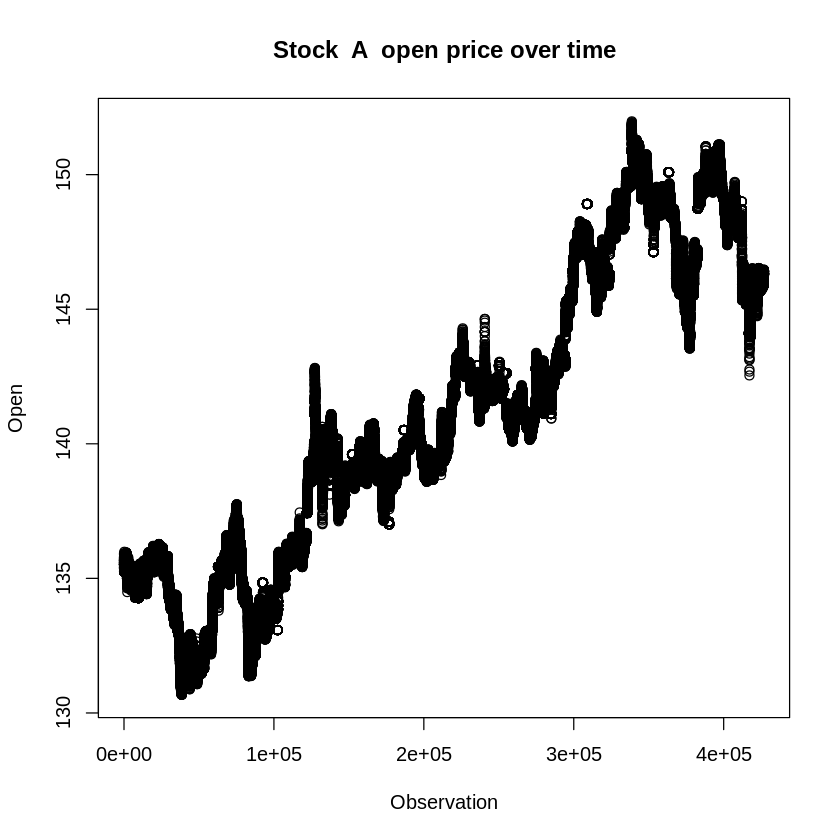

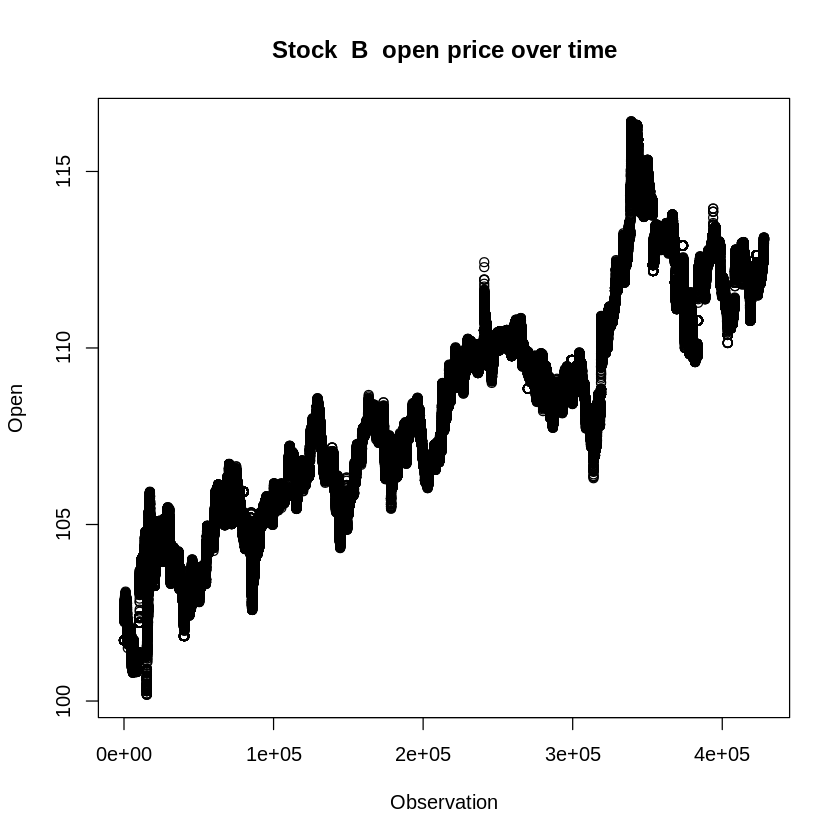

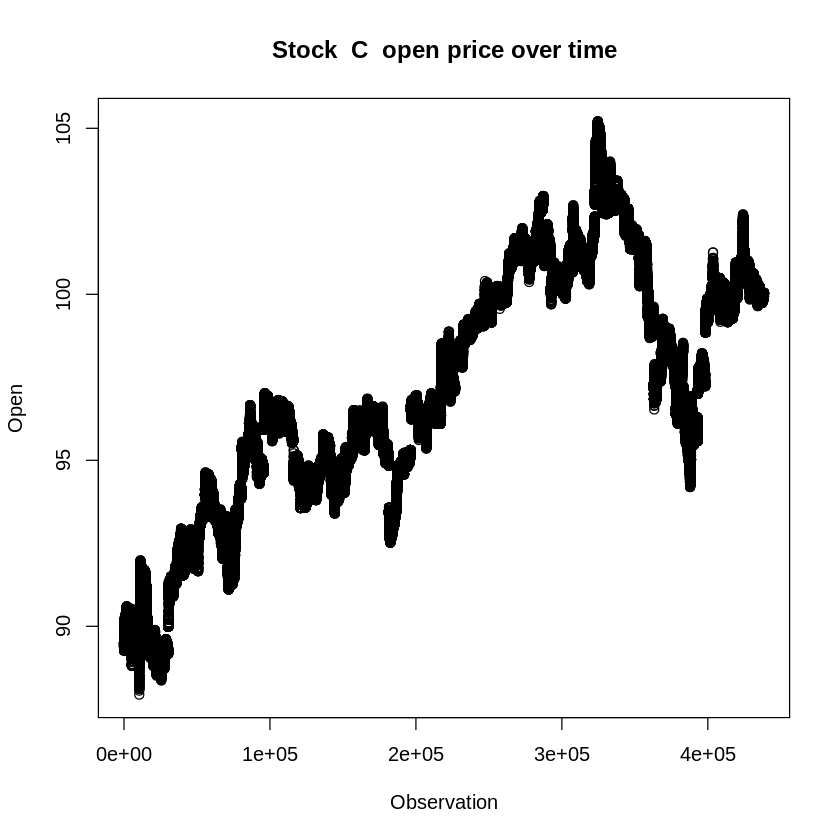

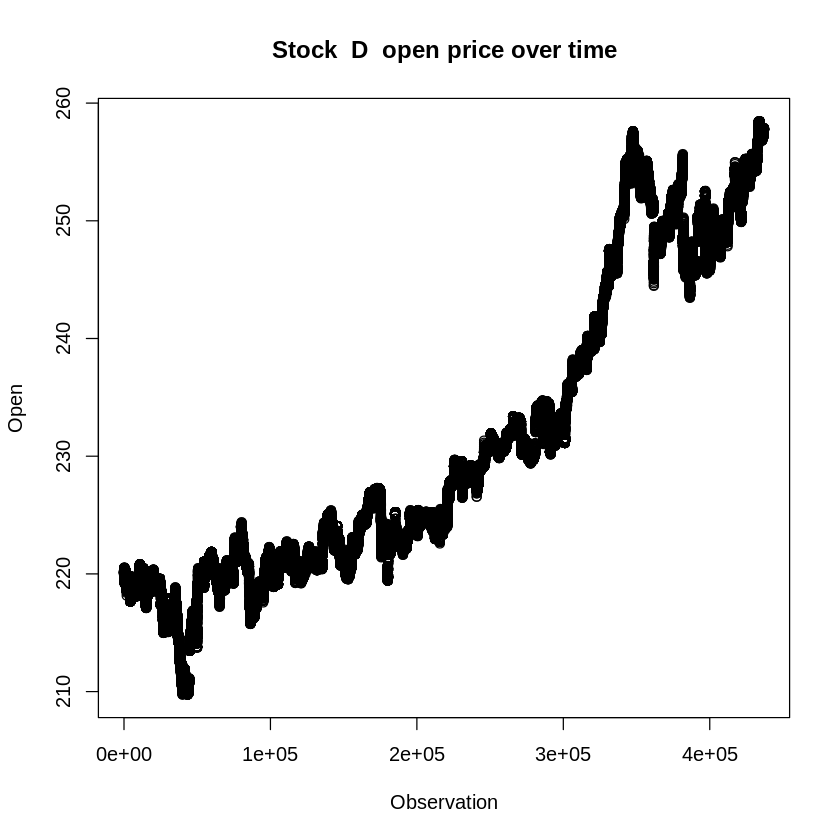

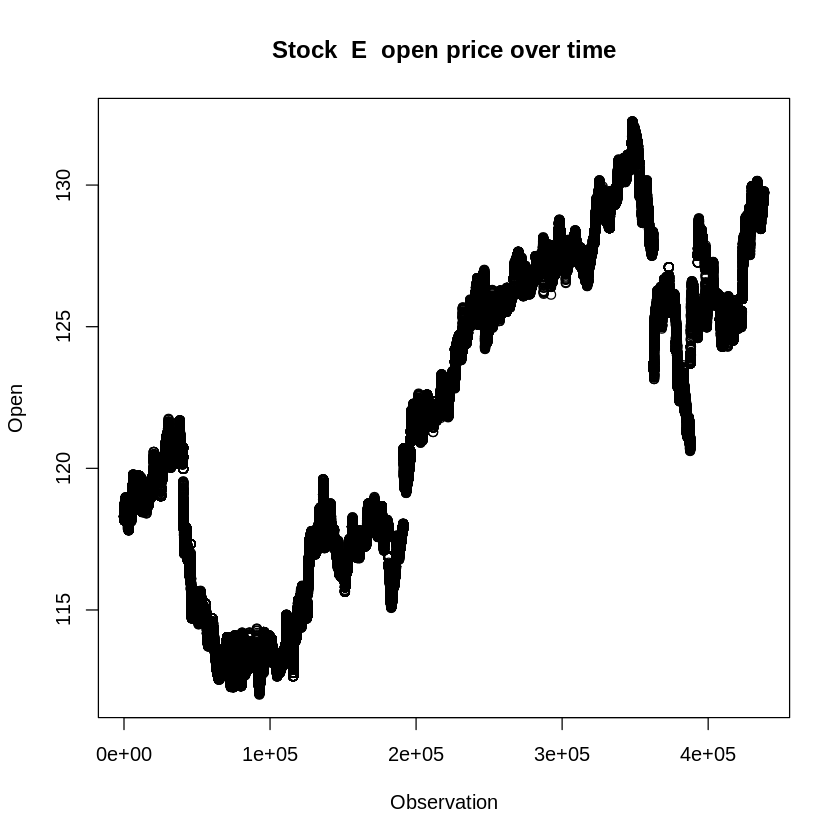

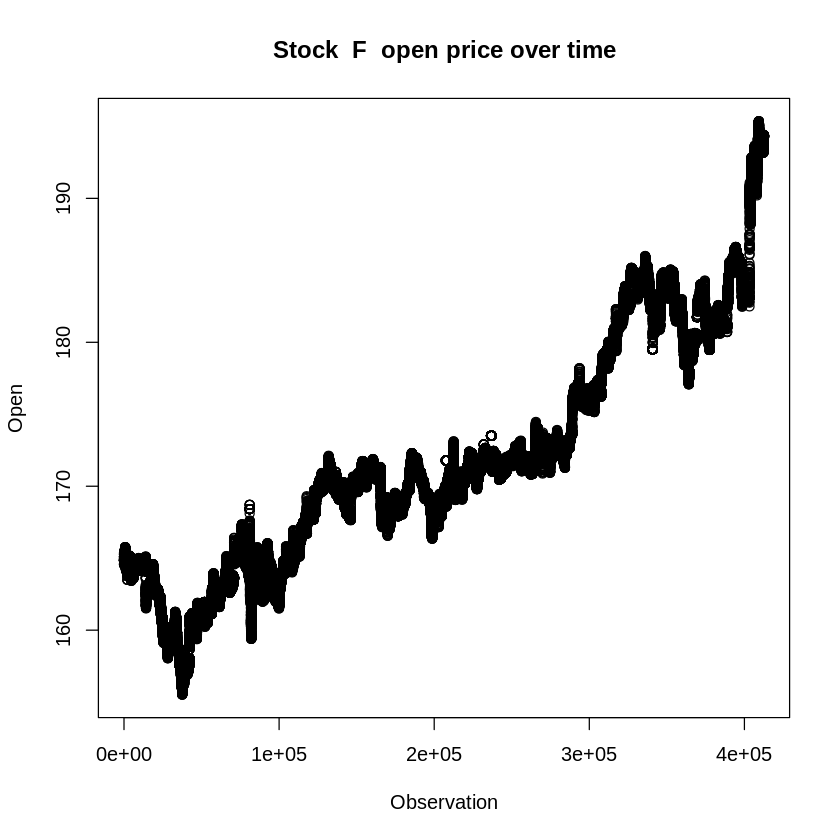

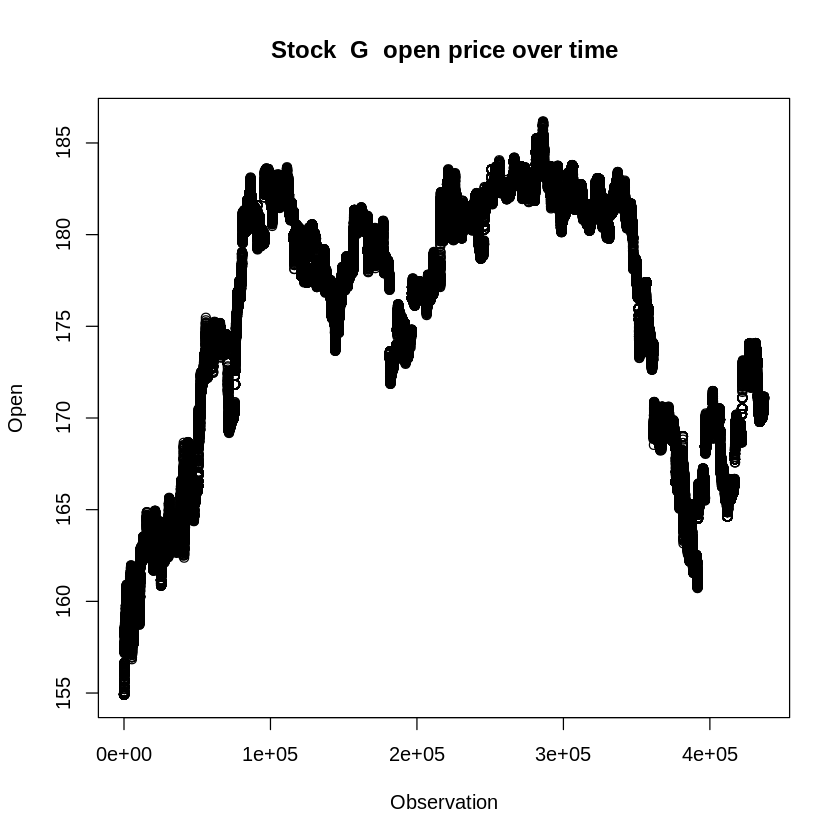

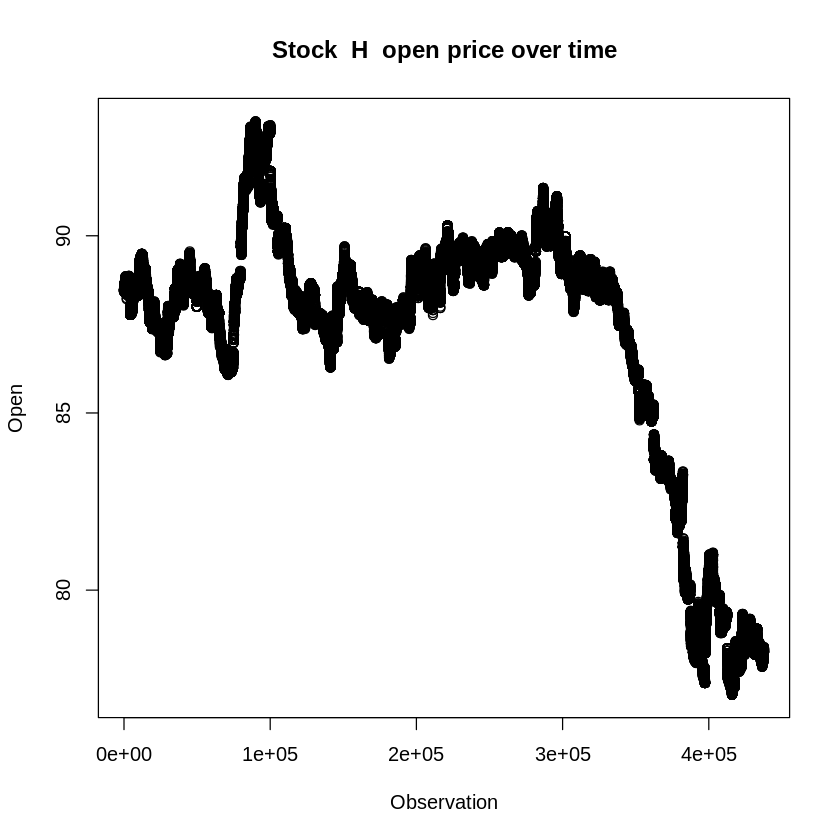

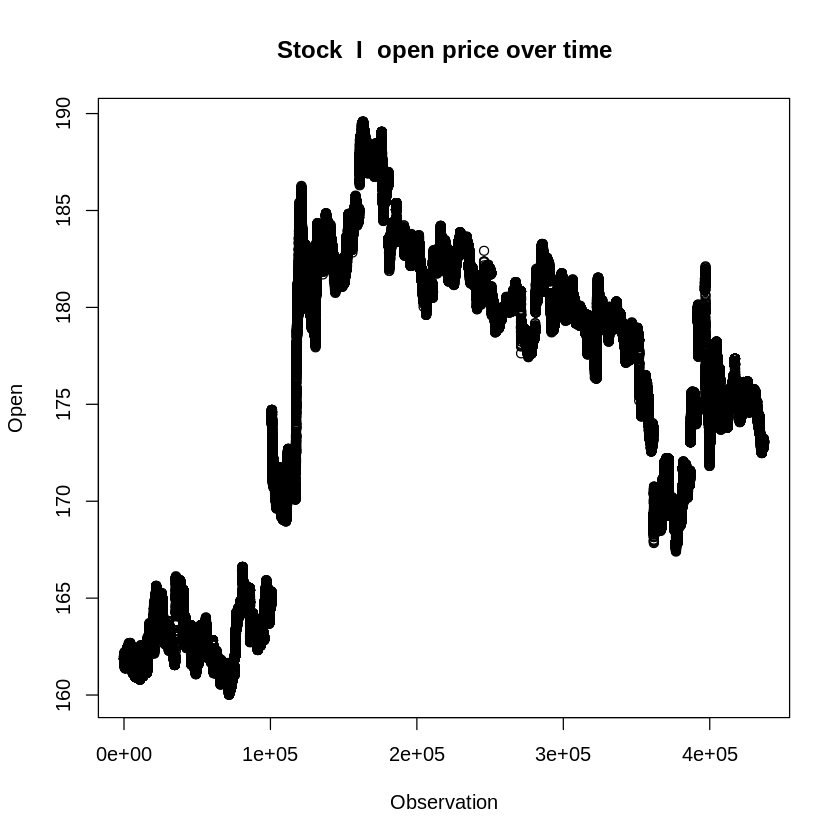

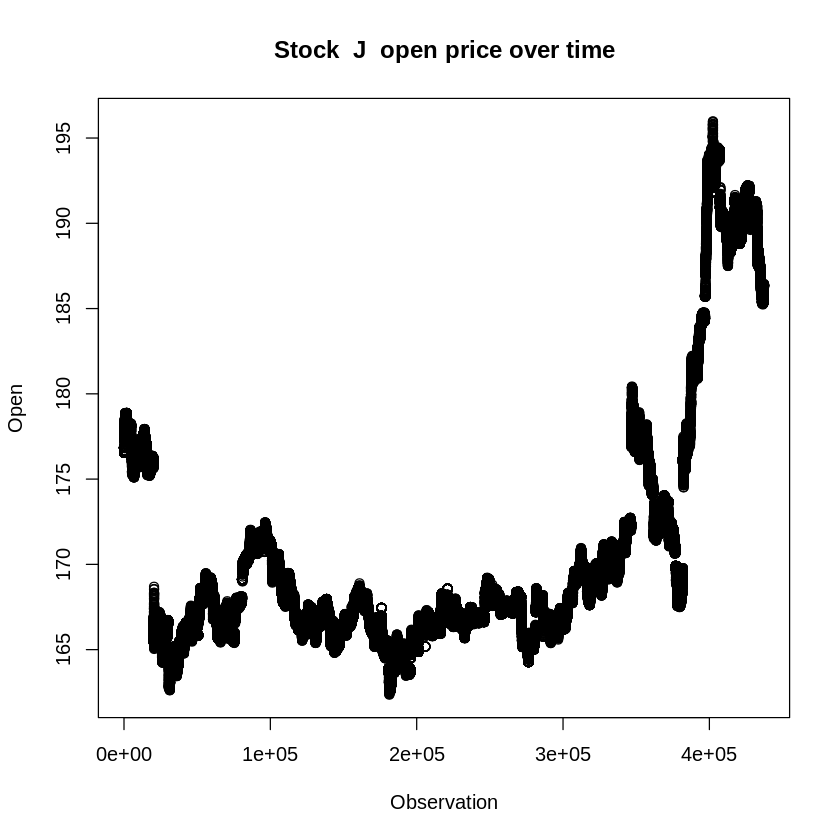

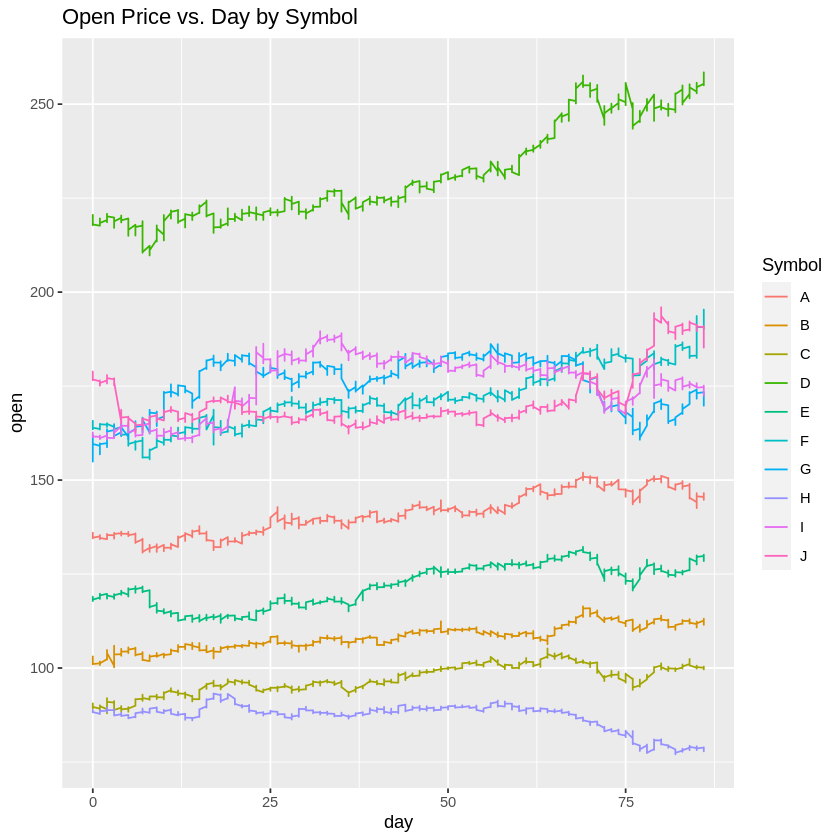

In [ ]:
# Plot open data over time for each of the stock tickers
for(i in tickers){
plot(df[df$symbol==i, "open"], xlab="Observation", 
     ylab="Open", main=paste("Stock ", i, " open price over time"))
}

ggplot(data = filter(df, !is.na(open)),
aes(x = day, y = open, group = symbol, colour = symbol)) +
geom_line() + 
guides(col = guide_legend(title = "Symbol")) +
ggtitle('Open Price vs. Day by Symbol')

The plots of the open prices over time by stock suggests that many of the tickers have a general upward trend over time, with some randomness around the trend. Patterns for certain of the stocks, including G, H, I and J, are more erratic.

# Data Processing, Feature Table Creation

## Partial Days, Custom Time Index

Creating a function that will help us get an ordered time index for all the entries since our data is of partial hours of a day. This basically let's us look at the rows of data without any gaps (other than actual missing data).

General concept is to create a "stock day" as a 7 hour day with 60 minutes per hour and 12 5-sec segments per minute.

return_time_index converts the day, hour, minutes, seconds of a "real day" parsed from the data into the right time_index

lookup_time_index gives us back the day, hour, minutes, seconds of a "real day" when given a time_index

In [ ]:
# set of functions to work with our custom time index
return_time_index <- function(day, hours, minutes, seconds){
  return (as.integer(day)*5040 + (as.integer(hours)-6)*720 + as.integer(minutes)*12 + as.integer(seconds)/5)
}

lookup_time_index <- function(time_index){
  day = floor(time_index/5040)
  hours = floor((time_index %% 5040)/720) + 6
  minutes = floor(((time_index %% 5040) %% 720)/12)
  seconds = (((time_index %% 5040) %% 720) %% 12)*5
  
  return (list("day" = day, "hours" = hours, "minutes" = minutes, "seconds" = seconds))
}

lookup_timestamp <- function(timestamp){
  time_index <- as.integer(difftime(
      timestamp,
      as.POSIXct(0, origin = "2021-01-01", tz = "GMT"),
      units = "secs"
    ))
    
  return (time_index)
}

convert_to_real_timestamp <- function(timestamp) {
  time_index <- as.integer(difftime(
    timestamp,
    as.POSIXct(0, origin = "2021-01-01", tz = "GMT"),
    units = "secs"
  ))
  
  vals <- lookup_time_index(time_index)
  return (
    as.POSIXct(
      vals$day * 24 * 60 * 60 + vals$hours * 60 * 60 + vals$minutes * 60 + vals$seconds,
      origin = "2021-01-01",
      tz = "GMT"
    )
  )
}

convert_from_real_timestamp <- function(timestamp) {
  time_index <- as.integer(difftime(
    timestamp,
    as.POSIXct(0, origin = "2021-01-01", tz = "GMT"),
    units = "secs"
  ))
  
  day = floor(time_index/86400)
  hours = floor((time_index %% 86400)/3600)
  minutes = floor((time_index %% 86400 %% 3600)/60)
  seconds = (time_index %% 86400 %% 3600 %% 60)
  return (
    as.POSIXct(
      return_time_index(day, hours, minutes, seconds),
      origin = "2021-01-01",
      tz = "GMT"
    )
  )
}

In [ ]:
# unit tests to sanity check that time functions are working
test_num <- 0
lookup_time_index(test_num)
return_time_index(
  lookup_time_index(test_num)$day,
  lookup_time_index(test_num)$hours,
  lookup_time_index(test_num)$minutes,
  lookup_time_index(test_num)$seconds
)
as.POSIXct(
  return_time_index(
    lookup_time_index(test_num)$day,
    lookup_time_index(test_num)$hours,
    lookup_time_index(test_num)$minutes,
    lookup_time_index(test_num)$seconds
  ),
  origin = "2021-01-01",
  tz = "GMT"
)
lookup_timestamp(as.POSIXct(
  return_time_index(
    lookup_time_index(test_num)$day,
    lookup_time_index(test_num)$hours,
    lookup_time_index(test_num)$minutes,
    lookup_time_index(test_num)$seconds
  ),
  origin = "2021-01-01",
  tz = "GMT"
))
convert_to_real_timestamp(as.POSIXct(
  return_time_index(
    lookup_time_index(test_num)$day,
    lookup_time_index(test_num)$hours,
    lookup_time_index(test_num)$minutes,
    lookup_time_index(test_num)$seconds
  ),
  origin = "2021-01-01",
  tz = "GMT"
))
convert_from_real_timestamp(convert_to_real_timestamp(
  as.POSIXct(
    return_time_index(
      lookup_time_index(test_num)$day,
      lookup_time_index(test_num)$hours,
      lookup_time_index(test_num)$minutes,
      lookup_time_index(test_num)$seconds
    ),
    origin = "2021-01-01",
    tz = "GMT"
  )
))

$day
[1] 0

$hours
[1] 6

$minutes
[1] 0

$seconds
[1] 0

[1] 0

[1] "2021-01-01 GMT"

[1] 0

[1] "2021-01-01 06:00:00 GMT"

[1] "2021-01-01 GMT"

In [ ]:
# Parse out times from our data
df <- df %>%
  mutate(
    hours = sapply(str_split(time, ':'), function(x)
      as.integer(x[1])),
    minutes = sapply(str_split(time, ':'), function(x)
      as.integer(x[2])),
    seconds = sapply(str_split(time, ':'), function(x)
      as.integer(x[3])),
    time_int = as.integer(hours)*60*60 + as.integer(minutes)*60 + as.integer(seconds),
    timestamp = as.POSIXct(time_int, origin="2021-01-01", tz="GMT"),
    time_index = return_time_index(day, hours, minutes, seconds),
    timestamp_index = as.POSIXct(time_index, origin="2021-01-01", tz="GMT"), # this is a modified timestamp that can be used to link up the fact that our stock open hours are only 7 days of the week. We use this be able to use the forecastML package as if we were predicting seconds. For final forecasts, we can map the timestamp_index back to the actual days, hours, minutes, and seconds.
  )

In [ ]:
## Check that time_index functions worked, this should return 0 rows
df %>%
  filter(
    as.integer(day) != lookup_time_index(time_index)$day
    | as.integer(hours) != lookup_time_index(time_index)$hours
    | as.integer(minutes) != lookup_time_index(time_index)$minutes
    | as.integer(seconds) != lookup_time_index(time_index)$seconds
  )

symbol open high low close average time day hours minutes seconds time_int
     timestamp time_index timestamp_index

## Missing Data

Below, we fill in the missing values for the open prices. We use last observation carried forward when possible. For the tickers that have missing data for the first time period of day 0 (tickers A, D, F, and H), we use the first observation available and carry it backward.

In [ ]:
# Add NA rows for missing data
df_filled <- df %>%
  add_row(
    symbol = c("A", "D", "F", "H"),
    open = NA,
    high = NA,
    low = NA,
    close = NA,
    average = NA,
    time = "06:00:00",
    day = 0,
    hours = 6,
    minutes = 0,
    seconds = 0,
    time_int = 21600.0,
    timestamp = as.POSIXct(21600, origin = "2021-01-01", tz = "GMT"),
    time_index = 0,
    timestamp_index = as.POSIXct(0, origin = "2021-01-01", tz = "GMT")
  ) %>%
  arrange(symbol, time_index) %>% 
  fill_gaps(
    date_col = which(colnames(df) == 'timestamp_index'),
    frequency = '1 sec',
    groups = 'symbol'
  )

# Fill observations with last observation when available, else next observation
df_filled <- df_filled %>% 
  mutate(time_index = lookup_timestamp(timestamp_index),
         timestamp = convert_to_real_timestamp(timestamp_index),
         time_int = lookup_timestamp(timestamp),
         day = lookup_time_index(time_index)$day,
         hours = lookup_time_index(time_index)$hours,
         minutes = lookup_time_index(time_index)$minutes,
         seconds = lookup_time_index(time_index)$seconds,
         time = sprintf("%02d:%02d:%02d", hours, minutes, seconds),
         symbol_id = as.numeric(factor(symbol))) %>% 
  group_by(symbol) %>%
  fill(open, .direction = "downup") %>% 
  fill(high, .direction = "downup") %>% 
  fill(low, .direction = "downup") %>% 
  fill(close, .direction = "downup") %>% 
  fill(average, .direction = "downup") %>% 
  ungroup()

## Data Dilation - Preaggregate daily, hourly grain

In [ ]:
df_day <- df_filled %>%
  group_by(symbol, day) %>%
  summarize(
    .groups = 'keep',
    open_day = open[which.min(time_int)],
    high_day = max(high),
    low_day = min(low),
    close_day = close[which.max(time_int)],
    average_day = mean(average), # we'll do macroaveraging since we have things at the 5 second level and at that point, it should be very similar to actual average
    sd_day = sd(average),
    range_day = high_day - low_day,
    time_index = min(time_index)
  ) %>%
  ungroup() %>% 
  mutate(
    timestamp = as.POSIXct(day*24*60*60, origin="2021-01-01", tz="GMT"),
    symbol_id = as.numeric(factor(symbol))
  )

df_hours <- df_filled %>%
  group_by(symbol, day, hours) %>%
  summarize(
    .groups = 'keep',
    open_hours = open[which.min(time_int)],
    high_hours = max(high),
    low_hours = min(low),
    close_hours = close[which.max(time_int)],
    average_hours = mean(average), # we'll do macroaveraging since we have things at the 5 second level and at that point, it should be very similar to actual average
    sd_hours = sd(average),
    range_hours = high_hours - low_hours
  ) %>%
  ungroup() %>% 
  mutate(timestamp = as.POSIXct((day * 24 + as.integer(hours)) * 60 * 60, origin =
                                  "2021-01-01", tz = "GMT"),
         time_index = return_time_index(day, hours, 0, 0),
         symbol_id = as.numeric(factor(symbol)))

# We no longer used this one when we decided to operate at hourly
# df_minutes <- df %>%
#   group_by(symbol, day, hours, minutes) %>%
#   summarize(
#     .groups = 'keep',
#     open_minutes = open[which.min(time_int)],
#     high_minutes = max(high),
#     low_minutes = min(low),
#     close_minutes = close[which.max(time_int)],
#     average_minutes = mean(average), # we'll do macroaveraging since we have things at the 5 second level and at that point, it should be very similar to actual average
#     sd_minutes = sd(average),
#     range_minutes = high_minutes - low_minutes,
#     time_index = min(time_index),
#   )

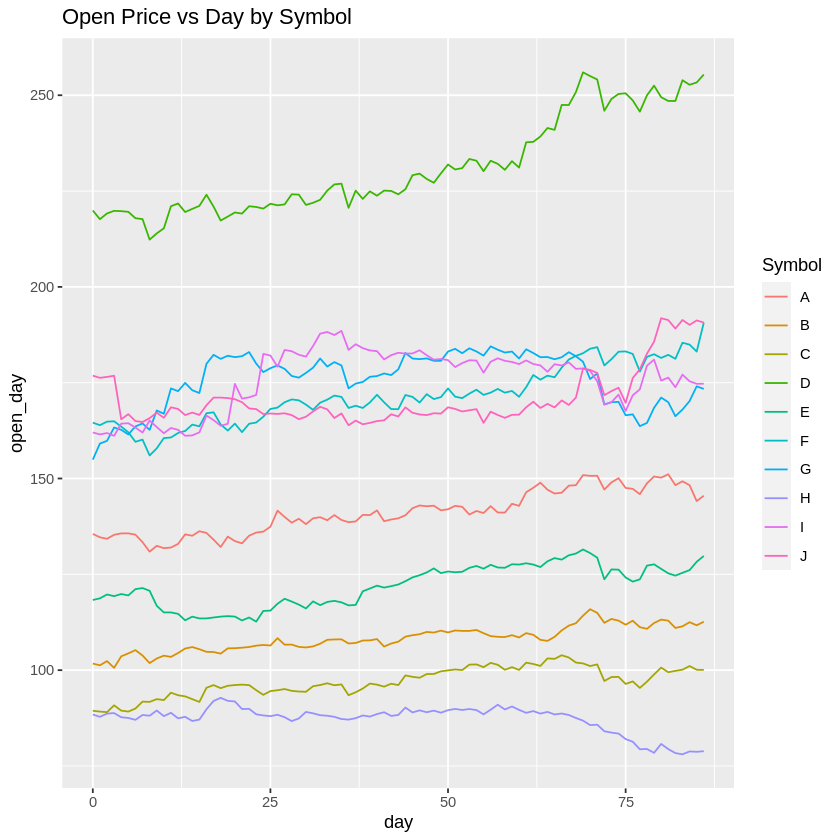

In [ ]:
ggplot(df_day,
       mapping = aes(
         x = day,
         y = open_day,
         group = symbol,
         color = symbol
       )) +
  geom_line() +
  guides(col = guide_legend(title = 'Symbol')) +
  ggtitle('Open Price vs Day by Symbol')

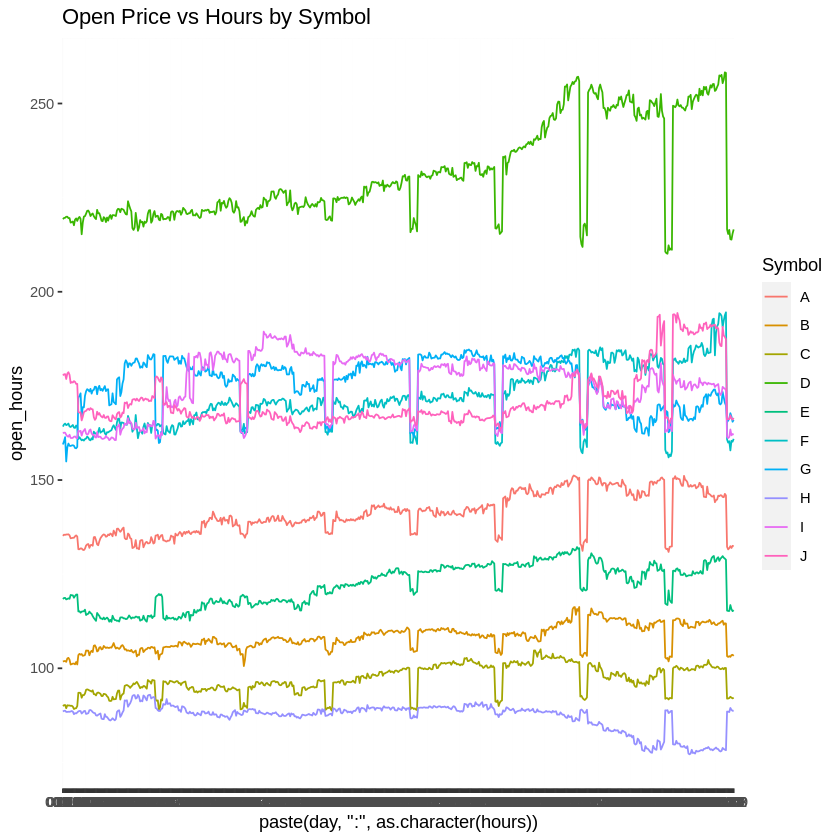

In [ ]:
ggplot(df_hours,
       mapping = aes(
         x = paste(day,":",as.character(hours)),
         y = open_hours,
         group = symbol,
         color = symbol
       )) +
  geom_line() +
  guides(col = guide_legend(title = 'Symbol')) +
  ggtitle('Open Price vs Hours by Symbol')

## Scale Features

The prices are at different scales than the range and other aggregate values, so we scale the features to make everything normalized.

In [ ]:
df_day_scaled <- df_day %>%
  group_by(symbol) %>% 
  mutate_at(c("high_day", 
              "low_day",
              "close_day",
              "average_day",
              "sd_day",
              "range_day"), ~(scale(.) %>% as.vector))

df_hours_scaled <- df_hours %>%
  group_by(symbol) %>% 
  mutate_at(c("high_hours", 
              "low_hours",
              "close_hours",
              "average_hours",
              "sd_hours",
              "range_hours"), ~(scale(.) %>% as.vector))

## Hourly Grain Data

In [ ]:
df_hours_features <-  df_hours_scaled %>%
  ungroup() %>%
  left_join(
    df_day_scaled %>%
      ungroup() %>%
      #join to the past day (5040 segments before)
      mutate(day_join = lookup_time_index(time_index + 5040)$day) %>%
      select(-timestamp,-day,-time_index, -symbol_id),
    #remove unnecessary columns from right table
    by = c("symbol" = "symbol", "day" = "day_join")
  ) %>%
  left_join(
    df_hours_scaled %>%
      ungroup() %>%
      #join to the past hour (720 segments before)
      mutate(
        day_join = lookup_time_index(time_index + 720)$day, #720
        hours_join = lookup_time_index(time_index + 720)$hours
      ) %>%
      select(-timestamp, -day, -hours, -time_index, -symbol_id),
    #remove unnecessary columns from right table
    by = c(
      "symbol" = "symbol",
      "day" = "day_join",
      "hours" = "hours_join"
    )
  ) %>% 
  left_join(
    df_hours_scaled %>%
      ungroup() %>%
      #join to the past hour (720 segments before)
      mutate(
        day_join = lookup_time_index(time_index + 720)$day, #720
        hours_join = lookup_time_index(time_index + 720)$hours
      ) %>%
      rename(open_hours_prev = open_hours) %>%
      select(symbol, open_hours_prev, day_join, hours_join, -symbol_id),
    #remove unnecessary columns from right table
    by = c(
      "symbol" = "symbol",
      "day" = "day_join",
      "hours" = "hours_join"
    )
  )

Make data stationary

In [ ]:
df_hours_features <- df_hours_features %>% 
  # add some dynamic features based on the timestamp
  mutate(
    day_of_week = (day %% 5), # we'll approximate what day of the week this is by taking modulus of 5 since the stock market is open only on weekdays. a holiday would mess up this time range, but this is the best we can do without more information
    timestamp_index = as.POSIXct(
      time_index,
      origin = "2021-01-01",
      tz =
        "GMT"
    ),
    open_hours_log_diff = log(open_hours.x) - log(open_hours_prev), # take difference to make our series stationary and log transform to stabilize the variance
    open_hours_diff = open_hours.x - open_hours_prev, # take difference to make our series stationary
    open_hours = open_hours.x
  )

# Exploratory Data Analysis

## Variance in open price by ticker

In [ ]:
for(i in tickers){
  print(paste("Variance for ticker ", i, ": ", 
      var(df_filled[df_filled$symbol==i, "open"])))
}

[1] "Variance for ticker  A :  29.8934334523009"
[1] "Variance for ticker  B :  10.0428032300193"
[1] "Variance for ticker  C :  13.6526348154235"
[1] "Variance for ticker  D :  161.818453692358"
[1] "Variance for ticker  E :  30.4148889201534"
[1] "Variance for ticker  F :  63.0326956489665"
[1] "Variance for ticker  G :  47.2368810706708"
[1] "Variance for ticker  H :  13.052901843747"
[1] "Variance for ticker  I :  63.9239582802365"
[1] "Variance for ticker  J :  54.157032504463"


Stocks D, F, and I appear to have higher price volatility than the other stocks, when all days in the data set are combined.

## Variance in open price by hour of the day

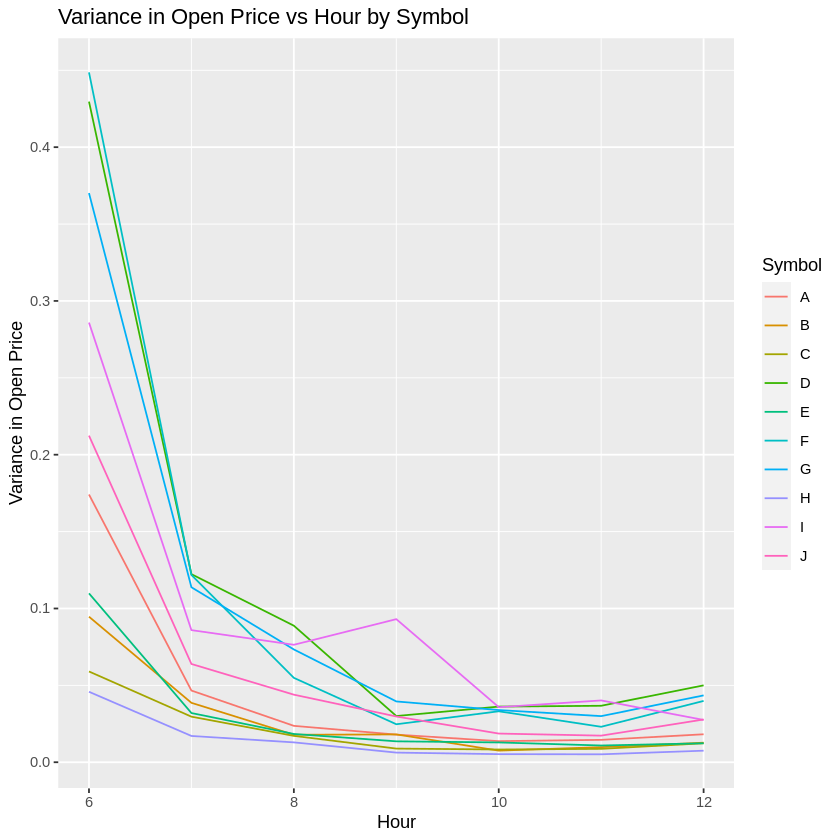

In [ ]:
df_filled %>% 
  group_by(symbol, day, hours) %>% 
  summarise(.groups='keep', var_by_hour = var(open)) %>%
  group_by(symbol, hours) %>%
  summarise(.groups='keep', value = mean(var_by_hour)) %>%
  ggplot(aes(x = hours, y = value, group = symbol, color = symbol)) + 
    geom_line() + 
    guides(col = guide_legend(title = 'Symbol')) +
    ggtitle('Variance in Open Price vs Hour by Symbol') +
    labs(x="Hour", y="Variance in Open Price")

Volatility is generally higher early in the morning, which may correspond to lower trading volume at these times and trading halts.

## Variance in open price by day

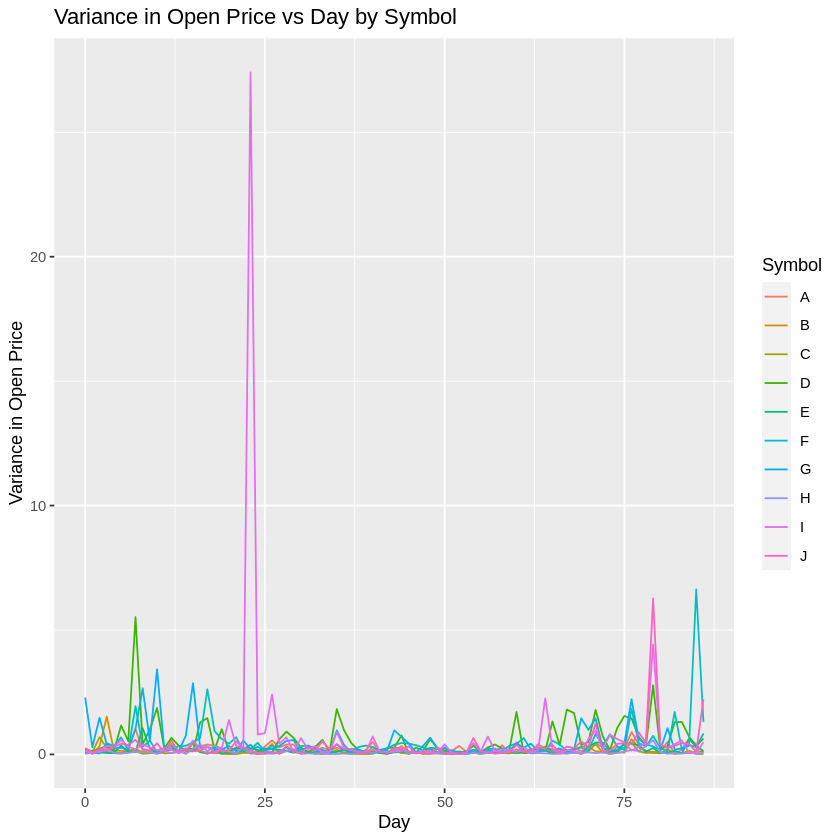

In [ ]:
df_filled %>% 
  group_by(symbol, day) %>% 
  summarise(.groups='keep', var_by_day = var(open)) %>%
  ggplot(aes(x = day, y = var_by_day, group = symbol, color = symbol)) + 
  geom_line() + 
  guides(col = guide_legend(title = 'Symbol')) +
  ggtitle('Variance in Open Price vs Day by Symbol') +
  labs(x="Day", y="Variance in Open Price")


Stock I has large spikes in volatility. This is explored more in the text of the paper, including within the discussion on missing data.

## Correlation between tickers

It's possible that certain stocks' prices are more correlated than others. For example, the graphs above suggest that the general price trends for stocks A and B look similar. Let's calculate the price correlation for each of the  (10 choose 2) = 45 pairs of stocks. Since the stock tickers don't have the same number of measurements, we can't calculate correlation using each time interval's value. Therefore, we can choose to calculate the average open price by day and by ticker, and then calculate the correlation between tickers.

In [ ]:
# Create a new variable that will equal the average open price for that ticker 
# for that day
df$avg_open_ticker <- NA

# Find range of days in the data set
day_range <- range(df$day)

# Set value of new variable
for(i in day_range[1]:day_range[2]) {
  for(j in tickers){
  df$avg_open_ticker[df$day==i & df$symbol==j] <- 
  mean(df[df$day==i & df$symbol==j, "open"])
}
}

# Create matrix with the average open price by day and by ticker
# https://stackoverflow.com/questions/44376020/double-for-loop-in-r-
# creating-a-matrix
data_avg_open <- matrix(nrow = length(tickers), ncol = day_range[2])
  for (j in 0:day_range[2]) { 
    data_avg_open[1, j] <- df$avg_open_ticker[df$symbol=="A" &
                              df$day==j][1]
    data_avg_open[2, j] <- df$avg_open_ticker[df$symbol=="B" &
                                                        df$day==j][1]
    data_avg_open[3, j] <- df$avg_open_ticker[df$symbol=="C" &
                                                        df$day==j][1]
    data_avg_open[4, j] <- df$avg_open_ticker[df$symbol=="D" &
                                                        df$day==j][1]
    data_avg_open[5, j] <- df$avg_open_ticker[df$symbol=="E" &
                                                        df$day==j][1]
    data_avg_open[6, j] <- df$avg_open_ticker[df$symbol=="F" &
                                                        df$day==j][1]
    data_avg_open[7, j] <- df$avg_open_ticker[df$symbol=="G" &
                                                        df$day==j][1]
    data_avg_open[8, j] <- df$avg_open_ticker[df$symbol=="H" &
                                                        df$day==j][1]
    data_avg_open[9, j] <- df$avg_open_ticker[df$symbol=="I" &
                                                        df$day==j][1]
    data_avg_open[10, j] <- df$avg_open_ticker[df$symbol=="J" &
                                                        df$day==j][1]
  }

  # Find correlation between the rows of the matrix. This finds the correlation
# between tickers of average daily open prices.
for(i in 1:nrow(data_avg_open)){
  for(j in 1:nrow(data_avg_open)){
  print(paste("Correlation between tickers ", i, " and ", j,":"))
  print(round(cor(data_avg_open[i,], data_avg_open[j,]), 3))
}
}   

[1] "Correlation between tickers  1  and  1 :"
[1] 1
[1] "Correlation between tickers  1  and  2 :"
[1] 0.922
[1] "Correlation between tickers  1  and  3 :"
[1] 0.76
[1] "Correlation between tickers  1  and  4 :"
[1] 0.928
[1] "Correlation between tickers  1  and  5 :"
[1] 0.846
[1] "Correlation between tickers  1  and  6 :"
[1] 0.928
[1] "Correlation between tickers  1  and  7 :"
[1] 0.048
[1] "Correlation between tickers  1  and  8 :"
[1] -0.586
[1] "Correlation between tickers  1  and  9 :"
[1] 0.43
[1] "Correlation between tickers  1  and  10 :"
[1] 0.539
[1] "Correlation between tickers  2  and  1 :"
[1] 0.922
[1] "Correlation between tickers  2  and  2 :"
[1] 1
[1] "Correlation between tickers  2  and  3 :"
[1] 0.768
[1] "Correlation between tickers  2  and  4 :"
[1] 0.909
[1] "Correlation between tickers  2  and  5 :"
[1] 0.783
[1] "Correlation between tickers  2  and  6 :"
[1] 0.905
[1] "Correlation between tickers  2  and  7 :"
[1] 0.144
[1] "Correlation between tickers  2  an

In [ ]:
data_avg_open

From this analysis, we see that the correlation between daily average open prices is very high between stocks A, B, D, and F (rows 1, 2, 4, and 6, respectively), and high between these stocks and stocks C and E (rows 3 and 5, respectively). This is not surprising given the graphs of the open prices by stock.

## Stationarity

The moving average regression model and ARIMA model require the time series to be stationary (i.e., the mean and variance and other properties don't vary with time). We will perform some tests to study whether each ticker is stationary. We will log the data before running the moving average and ARIMA models, so we will also log the data before checking for stationarity.

### Autocorrelation

We can check to see if there is autocorrelation in the open prices as a way to see if our data is stationary. We are predicting 9 days into the future, so we want to see if there is high autocorrelation at the 9 day mark.

There does seem to be high autocorrelation in the data, with ACF values > 0.5. This would be good for a neural network model like LSTM, but would make it more difficult for our direct forecasting approach.

In [ ]:
# reference source: https://www.business-science.io/timeseries-analysis/2018/04/18/keras-lstm-sunspots-time-series-prediction.html
tidy_acf <- function(data, value, lags = 0:20) {
    
    value_expr <- enquo(value)
    
    acf_values <- data %>%
        pull(value) %>%
        acf(lag.max = tail(lags, 1), plot = FALSE) %>%
        .$acf %>%
        .[,,1]
    
    ret <- tibble(acf = acf_values) %>%
        rowid_to_column(var = "lag") %>%
        mutate(lag = lag - 1) %>%
        filter(lag %in% lags)
    
    return(ret)
}

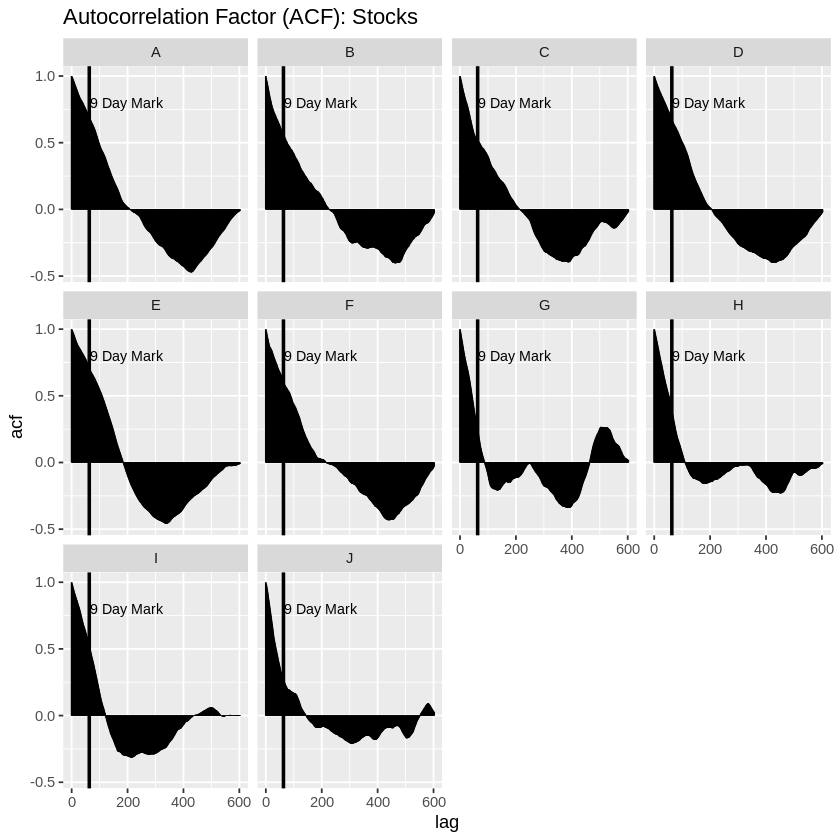

In [ ]:
df_hours_acf = tibble(acf = double(), lag = double(), symbol = character())

for(s in unique(df_hours$symbol)) {
  df_hours_acf <- rbind(
    df_hours_acf,
    df_hours_features %>%
      filter(symbol == s) %>%
      arrange(day, hours) %>%
      tidy_acf('open_hours', lags = 0:602) %>%
      mutate(symbol = s)
  )
}

ggplot(data = df_hours_acf, mapping = aes(x = lag, y = acf)) +
  facet_wrap(~ symbol) + 
  geom_segment(aes(xend = lag, yend = 0)) +
  geom_vline(xintercept = 63, size = 1) +
  annotate("text", label = "9 Day Mark", x = 65, y = 0.8, 
           size = 3, hjust = 0) +
  labs(title = "Autocorrelation Factor (ACF): Stocks")

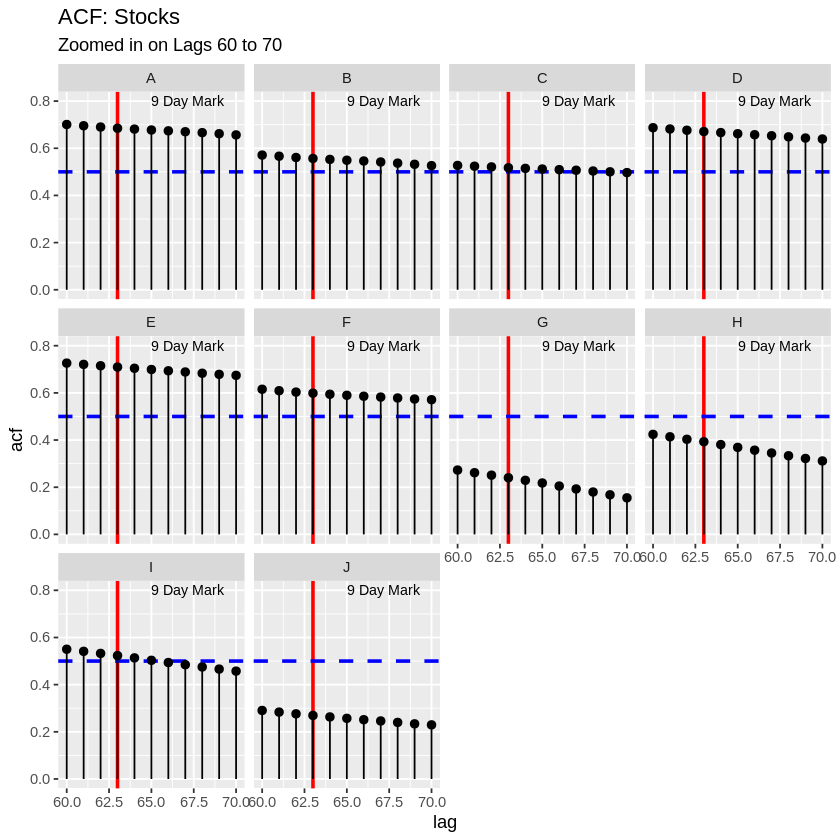

In [ ]:
df_hours_acf = tibble(acf = double(),
                      lag = double(),
                      symbol = character())

for (s in unique(df_hours$symbol)) {
  df_hours_acf <- rbind(
    df_hours_acf,
    df_hours_features %>%
      filter(symbol == s) %>%
      arrange(day, hours) %>%
      tidy_acf('open_hours', lags = 60:70) %>%
      mutate(symbol = s)
  )
}

ggplot(data = df_hours_acf, mapping = aes(x = lag, y = acf)) +
  facet_wrap(~ symbol) +
  geom_vline(xintercept = 63,
             size = 1,
             color = 'red') +
  geom_hline(
    yintercept = 0.5,
    size = 1,
    color = 'blue',
    linetype = 'dashed'
  ) +
  geom_segment(aes(xend = lag, yend = 0)) +
  geom_point(size = 2) +
  # geom_label(aes(label = acf %>% round(2)), vjust = 1) +
  annotate(
    "text",
    label = "9 Day Mark",
    x = 65,
    y = 0.8,
    size = 3,
    hjust = 0
  ) +
  labs(title = "ACF: Stocks",
       subtitle = "Zoomed in on Lags 60 to 70")

We can get rid of this autocorrelation by taking the difference between the open price and the previous open price.

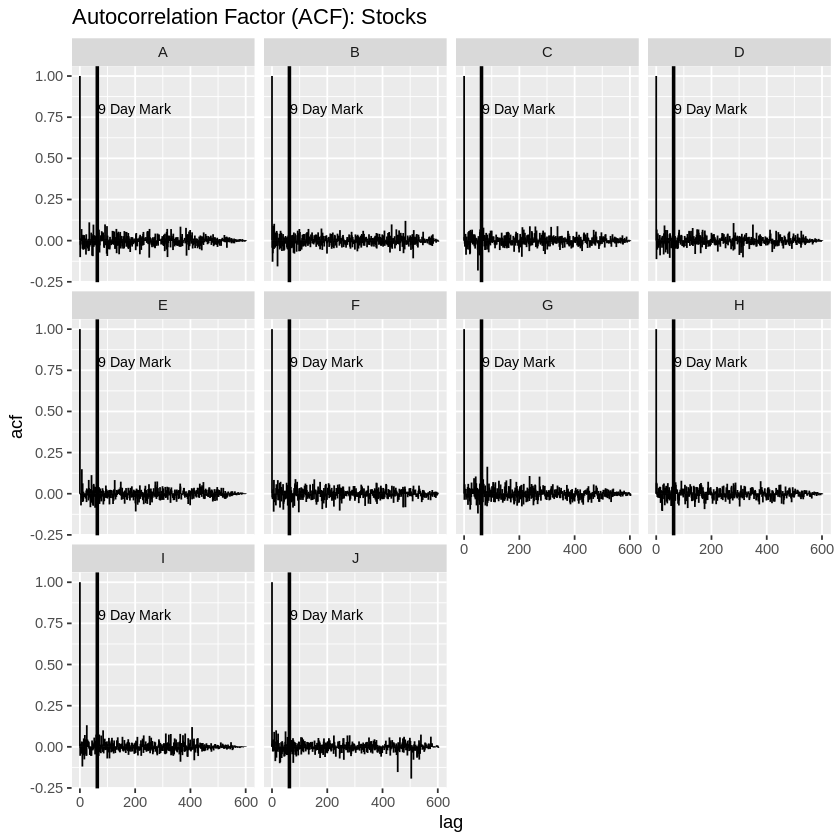

In [ ]:
df_hours_acf = tibble(acf = double(), lag = double(), symbol = character())

for(s in unique(df_hours$symbol)) {
  df_hours_acf <- rbind(
    df_hours_acf,
    df_hours_features %>%
      filter((symbol == s) & !is.na(open_hours_diff)) %>%
      arrange(day, hours) %>%
      tidy_acf('open_hours_diff', lags = 0:602) %>%
      mutate(symbol = s)
  )
}

ggplot(data = df_hours_acf, mapping = aes(x = lag, y = acf)) +
  facet_wrap(~ symbol) + 
  geom_segment(aes(xend = lag, yend = 0)) +
  geom_vline(xintercept = 63, size = 1) +
  annotate("text", label = "9 Day Mark", x = 65, y = 0.8, 
           size = 3, hjust = 0) +
  labs(title = "Autocorrelation Factor (ACF): Stocks")

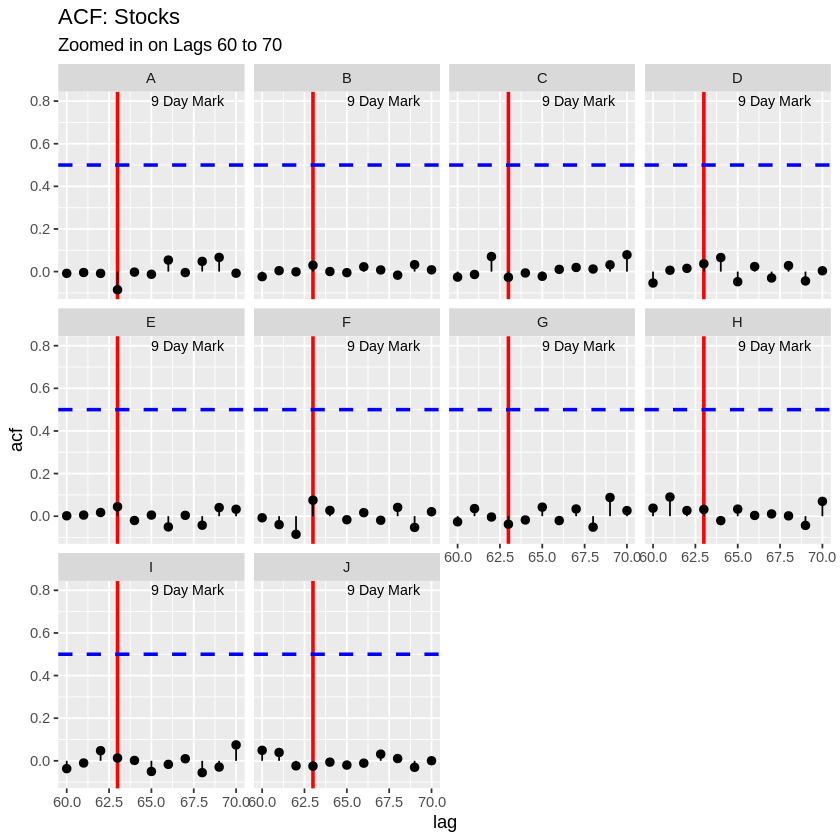

In [ ]:
df_hours_acf = tibble(acf = double(),
                      lag = double(),
                      symbol = character())

for (s in unique(df_hours$symbol)) {
  df_hours_acf <- rbind(
    df_hours_acf,
    df_hours_features %>%
      filter((symbol == s) & !is.na(open_hours_diff)) %>%
      arrange(day, hours) %>%
      tidy_acf('open_hours_diff', lags = 60:70) %>%
      mutate(symbol = s)
  )
}

ggplot(data = df_hours_acf, mapping = aes(x = lag, y = acf)) +
  facet_wrap(~ symbol) +
  geom_vline(xintercept = 63,
             size = 1,
             color = 'red') +
  geom_hline(
    yintercept = 0.5,
    size = 1,
    color = 'blue',
    linetype = 'dashed'
  ) +
  geom_segment(aes(xend = lag, yend = 0)) +
  geom_point(size = 2) +
  # geom_label(aes(label = acf %>% round(2)), vjust = 1) +
  annotate(
    "text",
    label = "9 Day Mark",
    x = 65,
    y = 0.8,
    size = 3,
    hjust = 0
  ) +
  labs(title = "ACF: Stocks",
       subtitle = "Zoomed in on Lags 60 to 70")

From plotting the autocorrelation with various lag windows per stock symbol, we see that all the stocks except G, H, and J have autocorrelation > 0.5 at the 9 day mark. This means a lagged variable for the other stocks could be a good feature in our forecasting model. Performance for stocks G, H, and J maybe not be as strong with just the lagged variable - hopefully the other features we included such as variance and other prices can help with predicting those stocks.

### Ljung-Box test

The Ljung-Box test "examines whether there is significant evidence for non-zero correlations at given lags (1-25 shown below), with the null hypothesis of independence in a given time series (a non-stationary signal will have a low p-value)." (https://rpubs.com/richkt/269797).

In [ ]:
# https://rpubs.com/richkt/269797
# Non-stationary signal has low p-value

# Add time to big data frame, which may be missing this element for intervals
# with missing values
s2 <- unique(df_filled$time)
s2 <- sort(s2)
s2 <- rep(s2, 10*87)
df_filled$time <- s2 

# Filter the data by hour
box <- df_filled %>%
  filter(time=="06:00:00" | time=="07:00:00" | time=="08:00:00"
         | time=="09:00:00" | time=="10:00:00" | time=="11:00:00" | 
           time=="12:00:00")

# Calculate Box-Ljung test by ticker
lag.length = 25
for (i in tickers) {
  print(Box.test(log(box$open[box$symbol==i]), 
                 lag=lag.length, type="Ljung-Box"))
}



	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 13407, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 11576, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 12060, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 13319, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 13459, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 12411, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 11027, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 11845, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 12689, df = 25, p-value < 2.2e-16


	Box-Ljung test

data:  log(box$open[box$symbol == i])
X-squared = 10649

Using hourly data, the Box-Ljung test strongly suggests that there are non-zero correlations at lags 1-25.

### Augmented Dickey–Fuller (ADF) t-statistic test for unit root

From https://rpubs.com/richkt/269797, the Augmented Dickey–Fuller (ADF) t-statistic test can be used to "find if the series has a unit root (a series with a trend line will have a unit root and result in a large p-value)."

In [ ]:
for (i in tickers) {
  print((adf.test(log(df_filled$open[df_filled$symbol==i]))))
}


	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -3.5065, Lag order = 75, p-value = 0.04035
alternative hypothesis: stationary



Warning message in adf.test(log(df_filled$open[df_filled$symbol == i])):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -4.5129, Lag order = 75, p-value = 0.01
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -2.5188, Lag order = 75, p-value = 0.3572
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -2.9718, Lag order = 75, p-value = 0.1634
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -2.2225, Lag order = 75, p-value = 0.4839
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -3.2753, Lag order = 75, p-value = 0.07322
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  log(df_filled$open[df_filled$symbol == i])
Dickey-Fuller = -2.807, Lag order = 75,

Tickers C through J have p-values greater than 0.05, suggesting that we fail to reject the null
hypothesis of a unit root for these stocks' logged prices.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

From https://rpubs.com/richkt/269797, "we can test if the time series is level or trend stationary using the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test." A low p-value indicates a series is not trend stationary.

In [ ]:
# https://rpubs.com/richkt/269797
for (i in tickers) {
  print((kpss.test(log(df_filled$open[df_filled$symbol==i]), 
                    null="Trend")))
}

Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 34.856, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 20.049, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 131.64, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 189.53, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 118.04, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 70.382, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 213.97, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 217.29, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 263.92, Truncation lag parameter = 32, p-value = 0.01



Warning message in kpss.test(log(df_filled$open[df_filled$symbol == i]), null = "Trend"):
“p-value smaller than printed p-value”



	KPSS Test for Trend Stationarity

data:  log(df_filled$open[df_filled$symbol == i])
KPSS Trend = 210.28, Truncation lag parameter = 32, p-value = 0.01



None of the tickers appear to be trend-stationary per this test.

# Baselines - Classical Time Series

## Carry Forward Last Observation

The most naive model we use as a baseline is carry forward last observation. This takes the last value we have prior to the forecast period and uses it as the forecast value for everything we are trying to predict in the future.

CFLO with our set cross validation windows

In [ ]:
cflo_errors = data.frame()

# Our 3 validation windows
for(w in c(25, 50, 77)){
  cflo_errors <- cflo_errors %>%
    bind_rows(
      df %>%
        filter(between(day, w+1, w+9)) %>%
        # Pull in last price to carry forward
        left_join(
          df %>%
            filter(day <= w) %>%
            group_by(symbol) %>%
            summarize(last_price = open[which.max(time_index)]),
          by = c("symbol" = "symbol")
        ) %>%
        group_by(symbol) %>%
        mutate(
          cflo = last_price,
          timestamp = convert_to_real_timestamp(timestamp_index),
          # Split between first 4 days and last 5 days
          first_batch = ifelse(day <= w + 4, 'days 0-3', 'days 4-9')
        ) %>%
        ungroup() %>%
        # Sum up squared errors per 5 sec segment
        group_by(first_batch, day, timestamp) %>%
        summarize(
          .groups = 'keep',
          segment_rmse = sum((cflo - open)^2)
        ) %>%
        # Avg the errors per day
        group_by(first_batch, day) %>%
        summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
        # Avg the errors per time period
        group_by(first_batch) %>%
        summarize(.groups = 'keep', rmse = mean(avg_rmse)) %>%
        mutate(test_name = paste('cflo_sec_', w)) %>%
        relocate(test_name)
    )
}
cflo_errors %>%
  group_by(first_batch) %>%
  summarize(cv_rmse = mean(rmse)) %>%
  pivot_wider(names_from = first_batch, values_from = cv_rmse) %>% 
  mutate(test_name = 'cflo') %>% 
  relocate(test_name)

test_name days 0-3 days 4-9
1 cflo      80.79056 147.302

CFLO for just the last 9 days

In [ ]:
cflo_errors_last_window = data.frame()

for(w in c(77)){
  cflo_errors_last_window <- cflo_errors_last_window %>%
    bind_rows(
      df %>%
        filter(between(day, w+1, w+9)) %>%
        left_join(
          df %>%
            filter(day <= w) %>%
            group_by(symbol) %>%
            summarize(last_price = open[which.max(time_index)]),
          by = c("symbol" = "symbol")
        ) %>%
        group_by(symbol) %>%
        mutate(
          cflo = last_price,
          timestamp = convert_to_real_timestamp(timestamp_index),
          first_batch = ifelse(day <= w + 4, 'days 0-3', 'days 4-9')
        ) %>%
        ungroup() %>%
        group_by(first_batch, day, timestamp) %>%
        summarize(
          .groups = 'keep',
          segment_rmse = sum((cflo - open)^2)
        ) %>%
        group_by(first_batch, day) %>%
        summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
        group_by(first_batch) %>%
        summarize(.groups = 'keep', rmse = mean(avg_rmse)) %>%
        mutate(test_name = paste('cflo_sec_', w)) %>%
        relocate(test_name)
    )
}
cflo_errors_last_window

test_name    first_batch rmse    
1 cflo_sec_ 77 days 0-3    193.7053
2 cflo_sec_ 77 days 4-9    331.7143

### Slight Increase in Error Using Hourly Granularity

We see that the errors increased only a little when we compared hourly data vs 5 seconds data. This shows that we wouldn't get too large of an error increase by running our predictions on the hourly level, and would be more computationally feasible.

In [ ]:
# CFLO Seconds
df %>%
    filter(between(day, w+1, w+9)) %>%
    left_join(
      df %>%
        filter(day <= w) %>%
        group_by(symbol) %>%
        summarize(last_price = open[which.max(time_index)]),
      by = c("symbol" = "symbol")
    ) %>%
    group_by(symbol) %>%
    mutate(
      cflo = last_price,
      timestamp = convert_to_real_timestamp(timestamp_index),
      first_batch = ifelse(day <= w + 4, 'days 0-3', 'days 4-9')
    ) %>%
    ungroup() %>%
    group_by(first_batch, day, timestamp) %>%
    summarize(
      .groups = 'keep',
      segment_rmse = sum((cflo - open)^2)
    ) %>%
    group_by(first_batch, day) %>%
    summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
    group_by(first_batch) %>%
    summarize(.groups = 'keep', rmse = mean(avg_rmse)) %>%
    mutate(test_name = paste('cflo_sec_', w)) %>%
    relocate(test_name)

test_name    first_batch rmse    
1 cflo_sec_ 77 days 0-3    193.7053
2 cflo_sec_ 77 days 4-9    331.7143

In [ ]:
# CFLO Hourly
df_hours_features %>%
  filter(day > 77) %>%
  left_join(
    df_hours_features %>%
      filter(day <= 77) %>%
      group_by(symbol_id) %>%
      summarize(last_price = open_hours.x[which.max(time_index)]),
    by = c("symbol_id" = "symbol_id")
  ) %>%
  group_by(symbol) %>%
  mutate(
    cflo = last_price,
    timestamp = convert_to_real_timestamp(timestamp_index),
    first_batch = ifelse(day <= 77 + 4, 'days 0-3', 'days 4-9')
  ) %>%
  group_by(first_batch, day, timestamp) %>%
  summarize(.groups = 'keep',
            segment_rmse = sum((cflo - open_hours.x) ^ 2)) %>%
  group_by(first_batch, day) %>%
  summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
  group_by(first_batch) %>%
  summarize(.groups = 'keep', rmse = mean(avg_rmse))

first_batch rmse    
1 days 0-3    169.9820
2 days 4-9    299.6684

## Moving Average Model

We will make predictions of open stock prices using moving averages. First, we'll split the data set into train (69 days), development (9 days), and test (9 days) sets. We will use the development set to try various time periods to include in the moving averages. We will select a final moving average model (or models) by considering the error on the dev set. It may prove useful to use a shorter time period for the first days (i.e., to include fewer days in the moving average) and a longer time period for the last days.

We will calculate the error on the test set using our final selected model(s). We can then compare the test error under moving average model(s) to the error using other modeling approaches in order to select our final model.

In [ ]:
df_with_miss <- df_filled

In [ ]:
# Identify the training, development, and test set observations
# Train: 0-68, dev: 69-77; test: 78-86 (user input)
dev_split <- 78
train_split <- 69
df_with_miss$set <- "test"
df_with_miss$set[df_with_miss$day < dev_split] <- "dev"
df_with_miss$set[df_with_miss$day < train_split] <- "train"

# User input: Max number of days in the average
av_stop <- 10

# Initialize vector for the predictions
dev_pred <- c(NA)

# For various values of the days in the average and by ticker, calculate the
# predicted open price.

for(k in 1:av_stop){
  for(i in tickers){
    # Put open prices for training data into a vector
    v <- log(df_with_miss$open[df_with_miss$symbol==i & df_with_miss$set=="train"])
    j <- 1
    for(j in 1:(5040*9)){ # Calculate a rolling av for each time step in dev set
      av <- mean(tail(v, n=5040*k)) # Mean of last k*5040 elements
      v <- append(v, av) # Append the mean to the vector
      j <- j+1
    }
    
    # Select the predictions for the dev set. (I.e., exclude the training data.)
    dev_pred <- append(dev_pred, tail(v, n=5040*9))
    
  }
}

dev_pred <- dev_pred[-1] # Remove the NA at the start of dev_pred
dev_actual <- rep(log(df_with_miss$open[df_with_miss$set=="dev"]), av_stop)

# Make data frame with results
averages <- rep(1:av_stop, 9*length(tickers)*5040)
averages <- sort(averages)
tick <- rep(tickers, 9*5040)
tick <- sort(tick)
tick <- rep(tick, av_stop)
d_days <- rep(train_split:(train_split+8), 5040)
d_days <- sort(d_days)
d_days <- rep(d_days, length(tickers))
d_days <- rep(d_days, av_stop)

results <- cbind.data.frame(tick, averages, d_days, dev_pred, dev_actual)
colnames(results) <- c("ticker", "days_in_av", "day", "log_ma_predicted","log_actual")

results$squared_error <- (results$log_ma_predicted - results$log_actual)^2

# Find days in the average that yields lowest squared error, by day in dev set
r <- results %>%
  group_by(ticker,day, days_in_av) %>%
  summarise(sum_squared_error=(sum(squared_error)))
r
r2 <- r %>% group_by(ticker, day) %>%
  slice(which.min(sum_squared_error))
r2

`summarise()` has grouped output by 'ticker', 'day'. You can override using the `.groups` argument.



ticker day days_in_av sum_squared_error
1   A      69   1         0.29456171       
2   A      69   2         0.61447034       
3   A      69   3         0.91057211       
4   A      69   4         1.45792759       
5   A      69   5         2.07482773       
6   A      69   6         2.45051483       
7   A      69   7         2.44297368       
8   A      69   8         2.44973222       
9   A      69   9         2.71467684       
10  A      69  10         3.32263529       
11  A      70   1         0.03941602       
12  A      70   2         0.11434972       
13  A      70   3         0.23193086       
14  A      70   4         0.42794614       
15  A      70   5         0.78424717       
16  A      70   6         1.18537468       
17  A      70   7         1.41272106       
18  A      70   8         1.40728056       
19  A      70   9         1.43602138       
20  A      70  10         1.66568476       
21  A      71   1         0.16748058       
22  A      71   2         0.10884063       
23  A      71   3         0.09472647       
24  A      71   4         0.13837952       
25  A      71   5         0.23329592       
26  A      71   6         0.41501488       
27  A      71   7         0.61955517       
28  A      71   8         0.73529286       
29  A      71   9         0.74402888       
30  A      71  10         0.79515910       
⋮   ⋮      ⋮   ⋮          ⋮                
871 J      75   1          2.3338871       
872 J      75   2          1.7930642       
873 J      75   3          1.4405764       
874 J      75   4          1.2550405       
875 J      75   5          1.0696671       
876 J      75   6          0.8872442       
877 J      75   7          0.8160077       
878 J      75   8          0.7914375       
879 J      75   9          0.6990024       
880 J      75  10          0.6131696       
881 J      76   1          3.8741047       
882 J      76   2          4.6630126       
883 J      76   3          5.2907024       
884 J      76   4          5.7163504       
885 J      76   5          6.0744707       
886 J      76   6          6.4995140       
887 J      76   7          6.9738694       
888 J      76   8          7.0760492       
889 J      76   9          7.1577113       
890 J      76  10          7.4873994       
891 J      77   1         13.4868209       
892 J      77   2         14.9312700       
893 J      77   3         16.0499582       
894 J      77   4         16.7663739       
895 J      77   5         17.3932429       
896 J      77   6         18.0326506       
897 J      77   7         18.7155554       
898 J      77   8         19.3513126       
899 J      77   9         19.5312425       
900 J      77  10         19.7621996

ticker day days_in_av sum_squared_error
1  A      69   1          0.29456171      
2  A      70   1          0.03941602      
3  A      71   3          0.09472647      
4  A      72   3          0.07274458      
5  A      73   3          0.01057120      
6  A      74   4          0.07402923      
7  A      75  10          0.52647996      
8  A      76  10          1.80088912      
9  A      77  10          0.55645993      
10 B      69   1          3.29207560      
11 B      70   1          1.13198183      
12 B      71   1          1.04961078      
13 B      72   1          0.05684528      
14 B      73   1          0.05626942      
15 B      74   1          0.08493296      
16 B      75   5          0.02744578      
17 B      76   8          0.25071120      
18 B      77   9          0.11352762      
19 C      69   1          0.03689511      
20 C      70   1          0.53108082      
21 C      71   1          2.91453157      
22 C      72   1         10.45079282      
23 C      73   1          5.56266857      
24 C      74   1          7.26365733      
25 C      75   1         12.97845555      
26 C      76   1         20.20604954      
27 C      77   1         18.48071522      
28 D      69   1          0.16633482      
29 D      70   2          0.04467860      
30 D      71   3          0.14680395      
⋮  ⋮      ⋮   ⋮          ⋮                
61 G      75   1         34.7549455       
62 G      76   1         47.6973913       
63 G      77   1         58.8209161       
64 H      69   1          0.4960915       
65 H      70   1          1.9387917       
66 H      71   1          2.4162241       
67 H      72   1          7.8886516       
68 H      73   1          8.7875442       
69 H      74   1         11.1059583       
70 H      75   1         16.5776841       
71 H      76   1         32.6753460       
72 H      77   1         53.6780689       
73 I      69   2          0.0158746       
74 I      70   1          0.5837271       
75 I      71   1          2.2788476       
76 I      72   1         11.9087183       
77 I      73   1          7.7425222       
78 I      74   1         10.5133323       
79 I      75   1         12.7337646       
80 I      76   1          7.3795025       
81 I      77   1          1.5581773       
82 J      69   1          5.9163989       
83 J      70   1          4.1576047       
84 J      71   1          2.2727494       
85 J      72   1          0.0275922       
86 J      73   1          0.3148428       
87 J      74   1          0.0764598       
88 J      75  10          0.6131696       
89 J      76   1          3.8741047       
90 J      77   1         13.4868209

We used the moving average method to calculate the squared error between the predicted and the actual open price by ticker and by day in the development set. For each ticker and day, we made predictions using 1, 2,...,10 days in the moving average. For the first three days in the development set, using a shorter-term average overwhelming leads to optimal errors regardless of ticker. From day 4 onward, the situation is more murky; within each day, some tickers yield lower errors when a shorter-term average is used, while other tickers give better performance with a longer-term average. Ultimately, we decided to use a model that employs a 1-day average for days 1 through 3 and a 3-day average for days 4 through 9. Below, we calculate the error on the test set using this model.


In [ ]:
# Initialize vector to hold the predictions; one spot per 5-second interval,
# per ticker
test_pred <- rep(NA, 5040*9*10)

# Calculate and store the predictions.

# Using one-day moving averages; for days 1-3 of the test set
for(i in tickers){
  # Put open prices for training and dev data into a vector
  v <- log(df_with_miss$open[df_with_miss$symbol==i & df_with_miss$set!="test"])
  
  # Calculate a rolling av for each time step in test set for the first 
  # three days of the test set; 1-day moving average
  for(j in 1:(5040*3)){
      av <- mean(tail(v, n=5040*1)) # Mean of last 1*5040 elements
      v <- append(v, av) # Append the mean to the vector
      j <- j+1
  }
  
  # Calculate a rolling av for each time step in test set for the last 
  # six days of the test set; 3-day moving average
  for(k in 1:(5040*6)){ 
     av <- mean(tail(v, n=5040*3)) # Mean of last 3*5040 elements
      v <- append(v, av) # Append the mean to the vector
      k <- k+1
    } 
    
    # Select the predictions for the test set. (I.e., exclude the training 
    # and dev data.)
    test_pred_i <- tail(v, n=5040*9)
    
    # Store the predictions in a vector.
    test_pred <- append(test_pred, test_pred_i)

}

test_pred <- tail(test_pred, 5040*9*10)


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



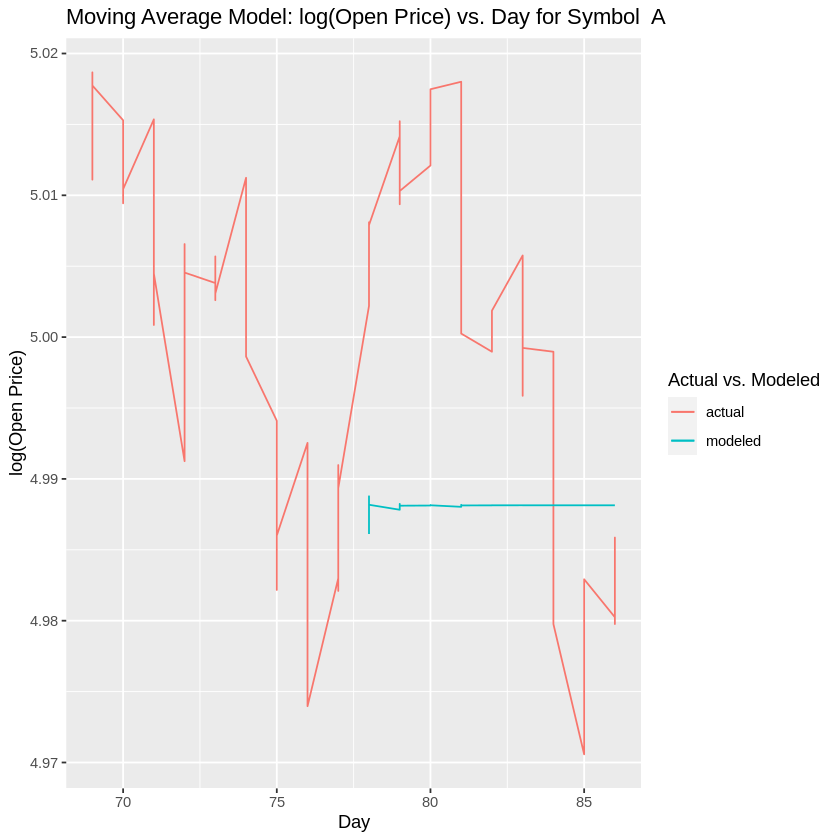

Saving 6.67 x 6.67 in image



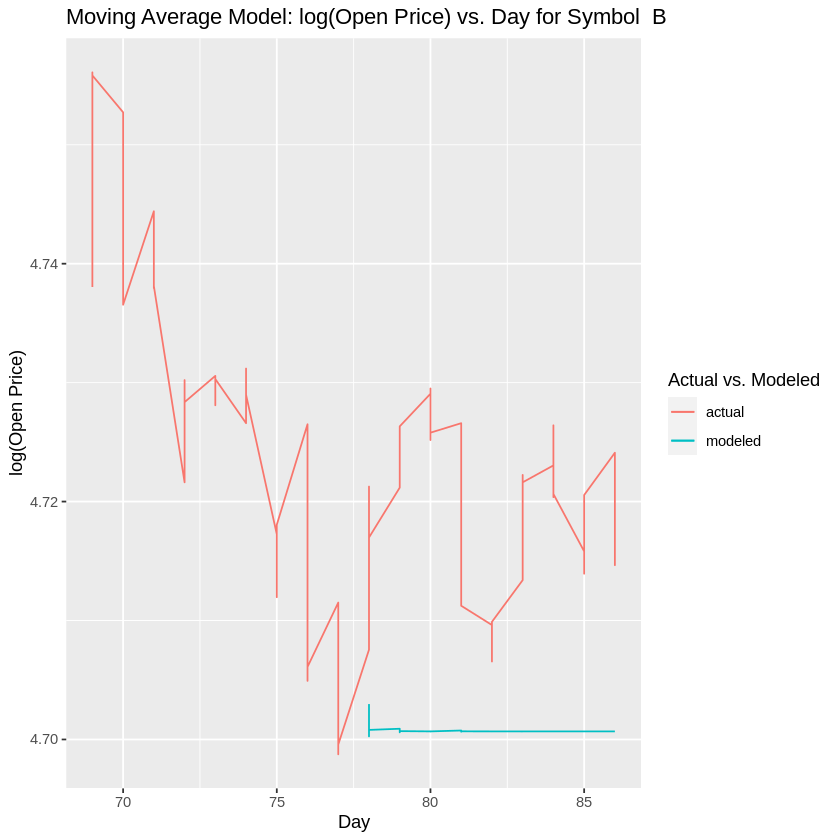

Saving 6.67 x 6.67 in image



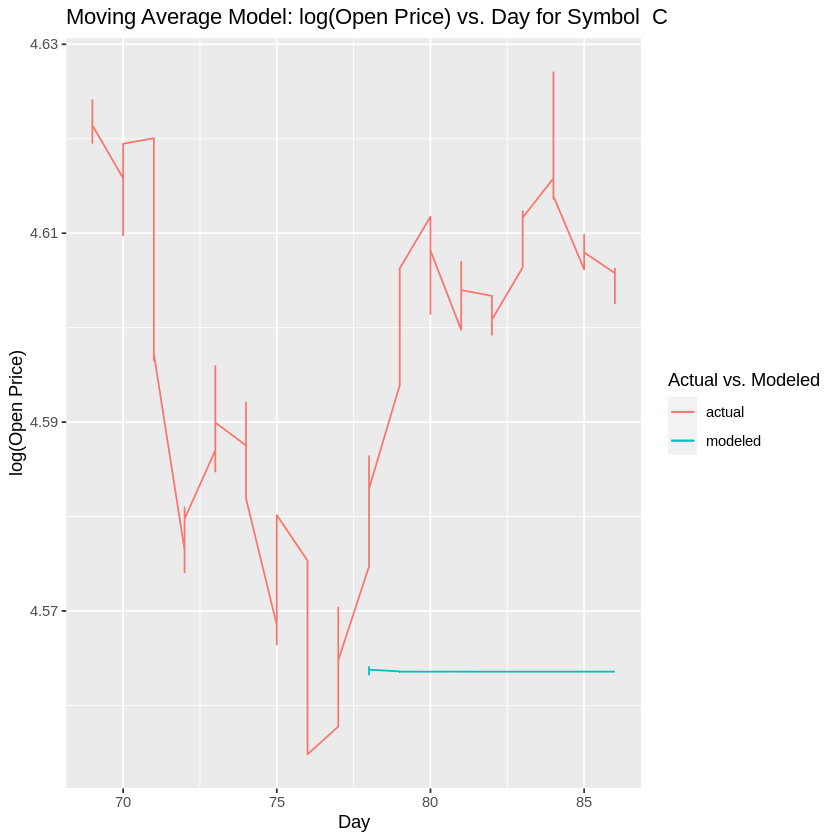

Saving 6.67 x 6.67 in image



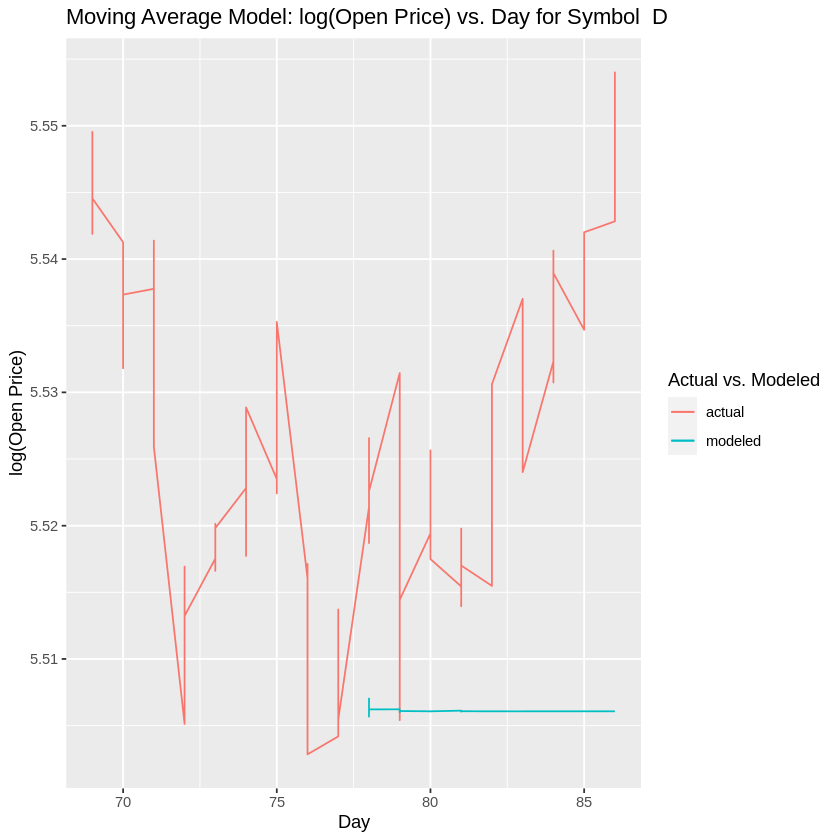

Saving 6.67 x 6.67 in image



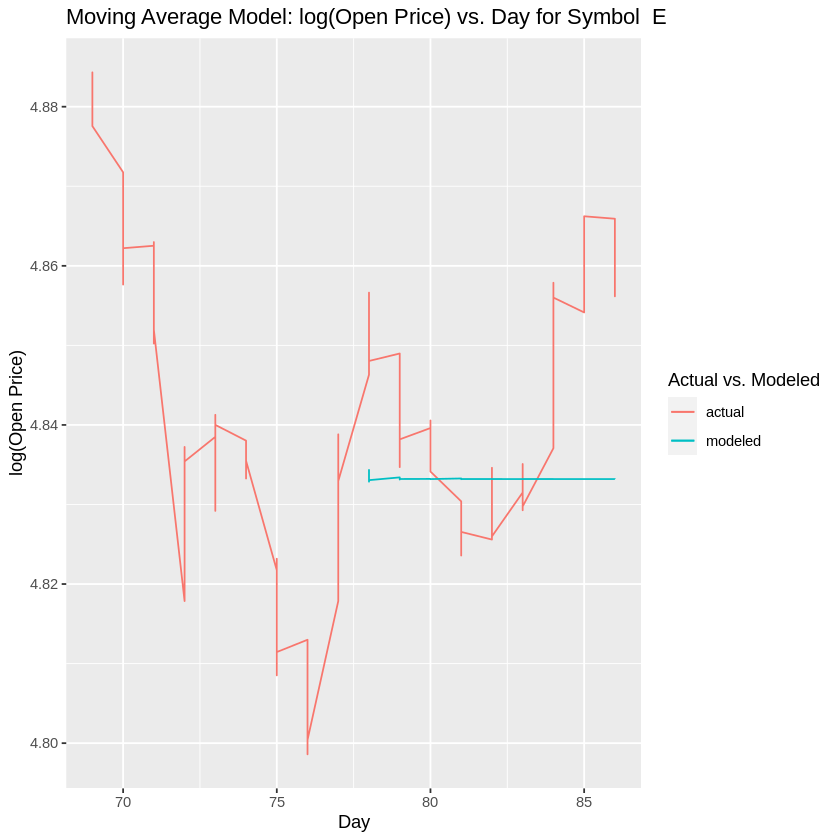

Saving 6.67 x 6.67 in image



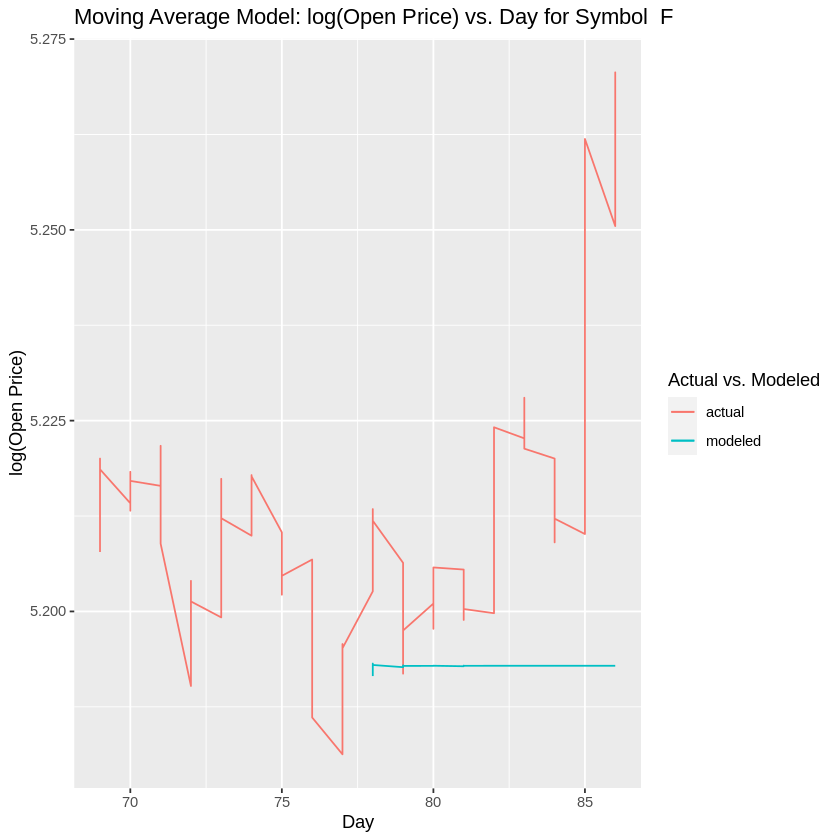

Saving 6.67 x 6.67 in image



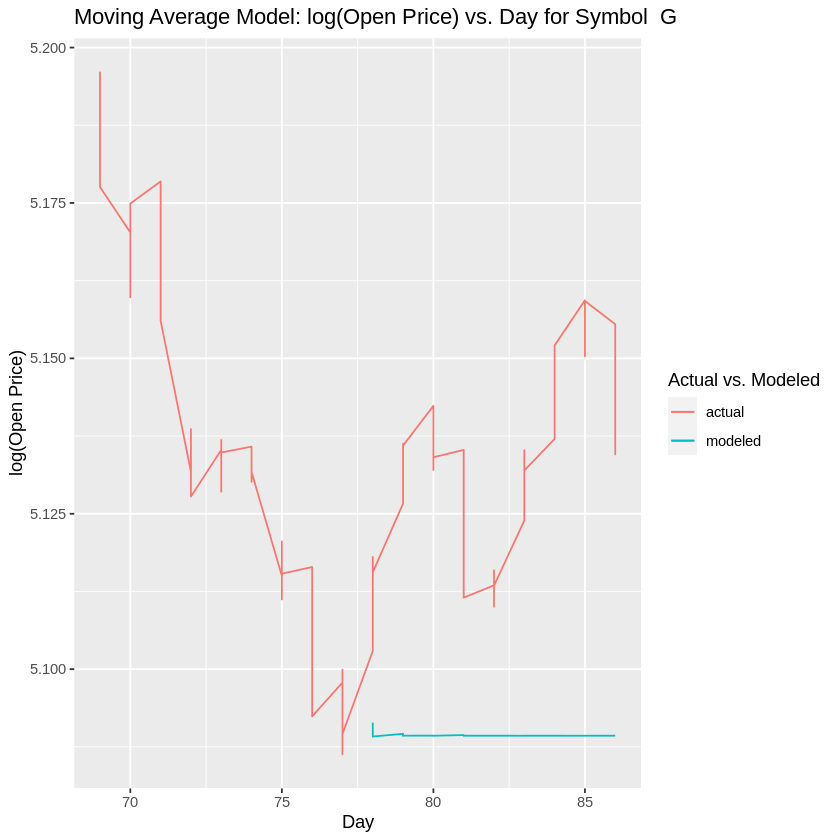

Saving 6.67 x 6.67 in image



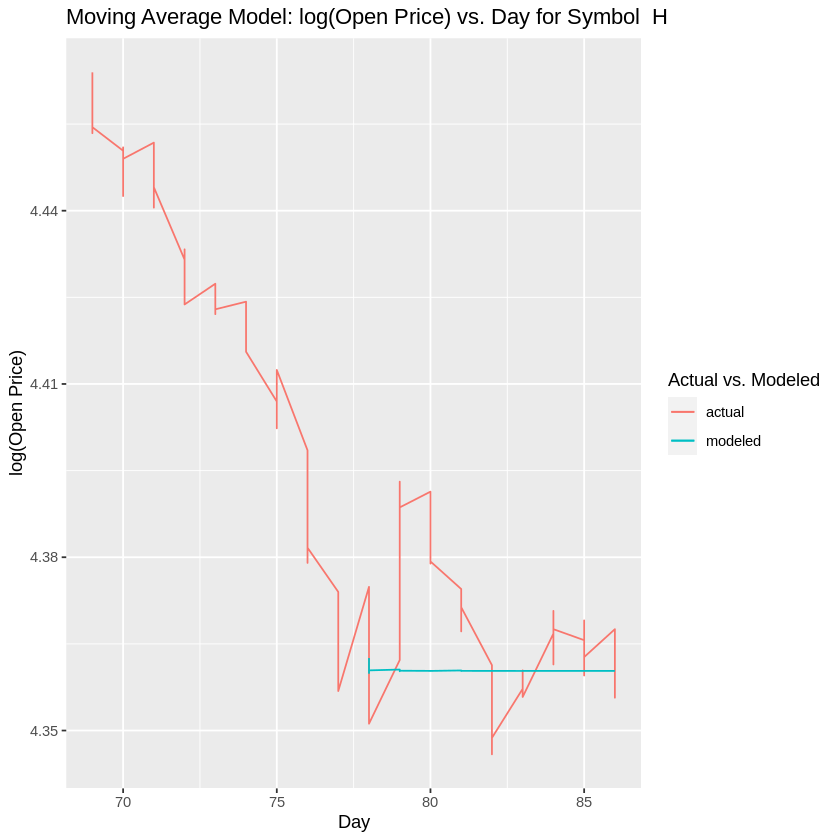

Saving 6.67 x 6.67 in image



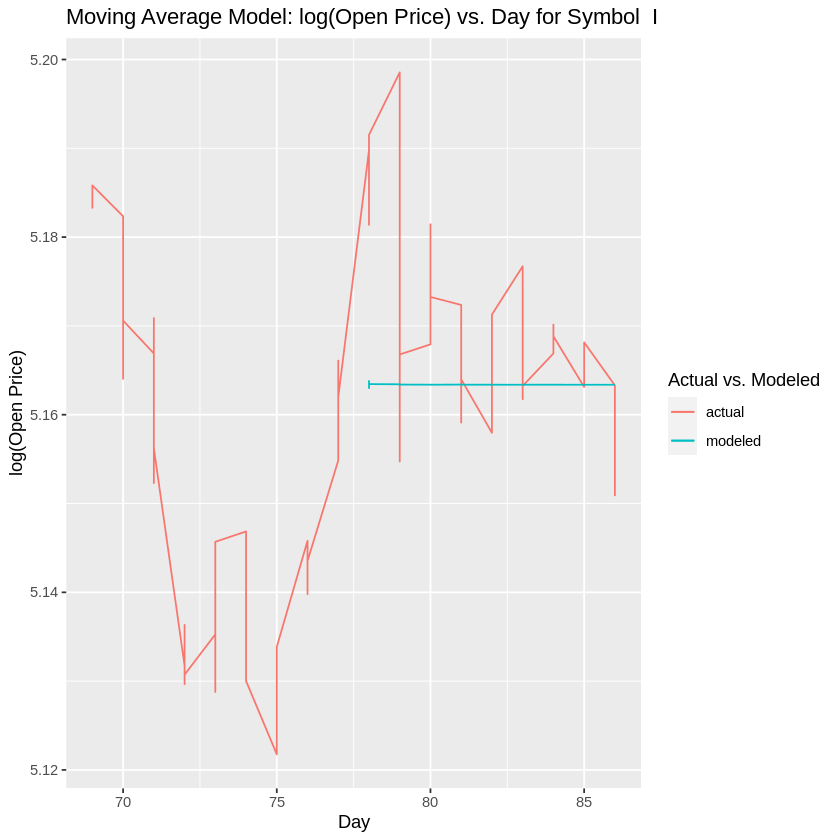

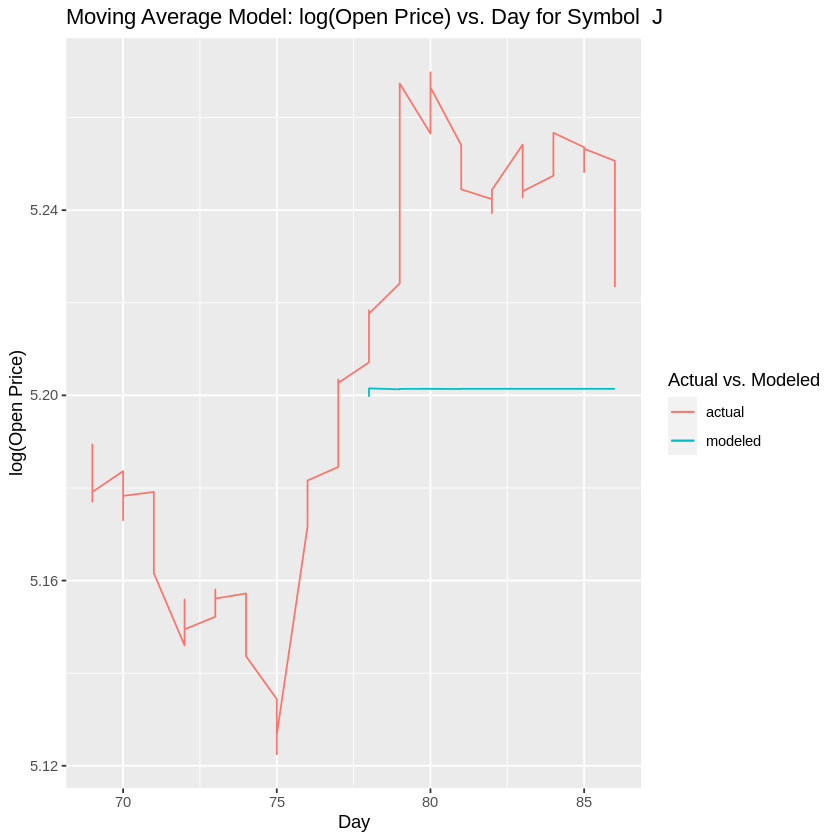

In [ ]:
# Graph of actual prices vs. predicted prices, by ticker

# Put MA predictions into a data frame. Recall that test_pred has the format
# Stock A, days 78 through 86, then stock B, days 78 through 86, then stock C, 
# days 78 through 86, etc.
t <- rep(tickers, 9*5040)
t <- sort(t)
d <- as.integer(rep(78:86, 5040))
d <- sort(d)
d <- rep(d, 10)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 10*9)

# https://stackoverflow.com/questions/19535996/avoid-rbind-cbind-conversion-
# from-numeric-to-factor
ma_pred <- data.frame(cbind.data.frame(t, d, s, test_pred))
colnames(ma_pred) <- c("symbol", "day", "time", "log_predicted_open")

# Add time to big data frame, which may be missing this element for intervals
# with missing values
s2 <- unique(df_with_miss$time)
s2 <- sort(s2)
s2 <- rep(s2, 10*87)
df_with_miss$time <- s2 

for(i in tickers){
  myplot <-
  ggplot() +
  geom_line(data = filter(df_with_miss, symbol==i, time=="06:00:00" | 
                            time=="07:00:00" | time=="08:00:00" | 
                            time=="09:00:00" | time=="10:00:00" | 
                            time=="11:00:00" | time=="12:00:00", day > 68),
            aes(x = day, y = log(open), color = "actual")) +
  geom_line(data = filter(ma_pred, symbol==i, time=="06:00:00" | 
                            time=="07:00:00" | time=="08:00:00" | 
                            time=="09:00:00" | time=="10:00:00" | 
                            time=="11:00:00" | time=="12:00:00", day > 77),
            aes(x = day, y = log_predicted_open, color = "modeled")) +
  xlab("Day") +
  ylab("log(Open Price)") +
  guides(col = guide_legend(title = "Actual vs. Modeled")) +
  ggtitle(paste('Moving Average Model: log(Open Price) vs. Day for Symbol ', i))
  
  print(myplot)
  
  ggsave(myplot,filename=paste("ma_pred_", i ,".png",sep=""))
}


In [ ]:
# Calculate the error on the test set, using formula on page 2 of 
# "final_project.pdf"

# Add actual open prices on the test set to the data frame with the predictions
ma_pred$actual <- log(df_with_miss$open[df_with_miss$day > 77])

# Calculate squared error
ma_pred$squared_error <- (exp(ma_pred$log_predicted_open) - exp(ma_pred$actual))^2

# Test error for days 78-81
first_error <- (1/4)*(1/5040)*
  (sum(ma_pred$squared_error[ma_pred$day < 82]))
first_error
                                        
# Test error for days 82-86
second_error <- (1/5)*(1/5040)* 
  (sum(ma_pred$squared_error[ma_pred$day > 81]))
second_error

[1] 175.4808

[1] 312.3083

Now we will calculate the forecasts using the moving average model for 9 days past the end of the training data.

In [ ]:
# Initialize vector to hold the forecasts; one spot per 5-second interval,
# per ticker
ma_forecast <- rep(NA, 5040*9*10)

# Calculate and store the predictions.

# Using one-day moving averages; for days 1-3 of the forecast set
for(i in tickers){
  # Put open prices for training and dev and test data into a vector
  v <- log(df_with_miss$open[df_with_miss$symbol==i])
  
  # Calculate a rolling av for each time step in forecast set for the first 
  # three days of the forecast set; 1-day moving average
  for(j in 1:(5040*3)){
      av <- mean(tail(v, n=5040*1)) # Mean of last 1*5040 elements
      v <- append(v, av) # Append the mean to the vector
      j <- j+1
  }
  
  # Calculate a rolling av for each time step in forecast set for the last 
  # six days of the forecast set; 3-day moving average
  for(k in 1:(5040*6)){ 
     av <- mean(tail(v, n=5040*3)) # Mean of last 3*5040 elements
      v <- append(v, av) # Append the mean to the vector
      k <- k+1
    } 
    
    # Select the predictions for the forecast set. (I.e., exclude the training 
    # and dev and test data.)
    ma_forecast_i <- tail(v, n=5040*9)
    
    # Store the predictions in a vector.
    ma_forecast <- append(ma_forecast, ma_forecast_i)

}

ma_forecast <- tail(ma_forecast, 5040*9*10)


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



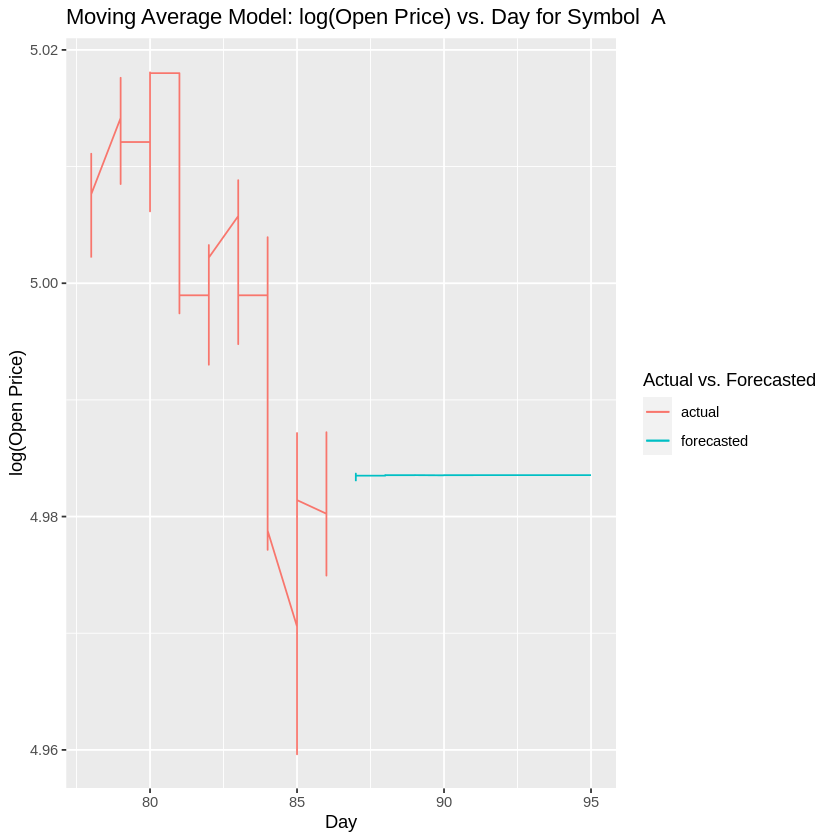

Saving 6.67 x 6.67 in image



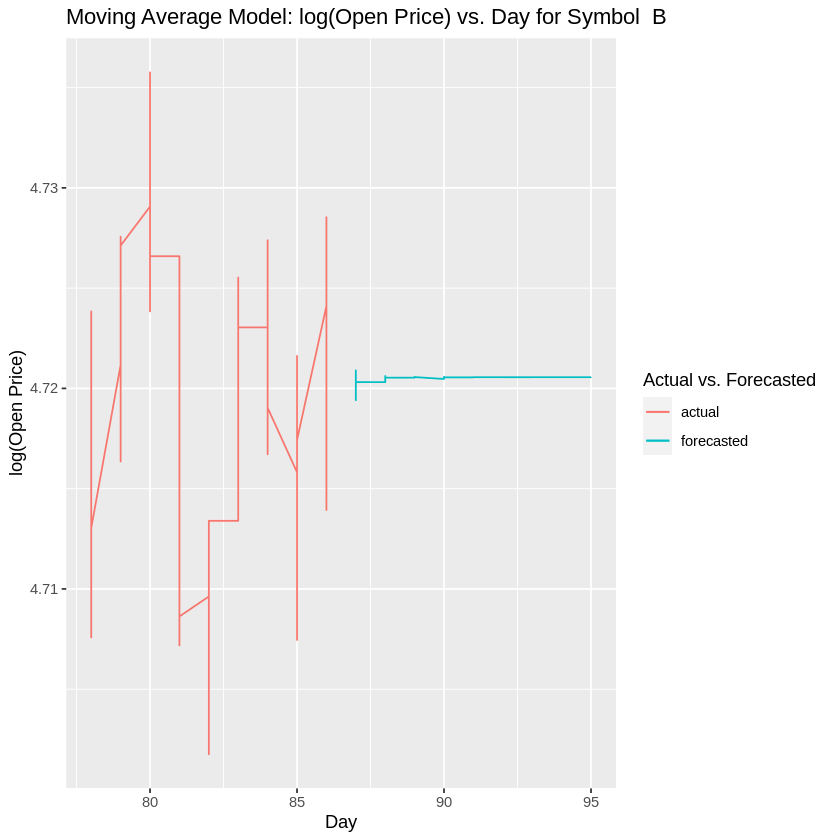

Saving 6.67 x 6.67 in image



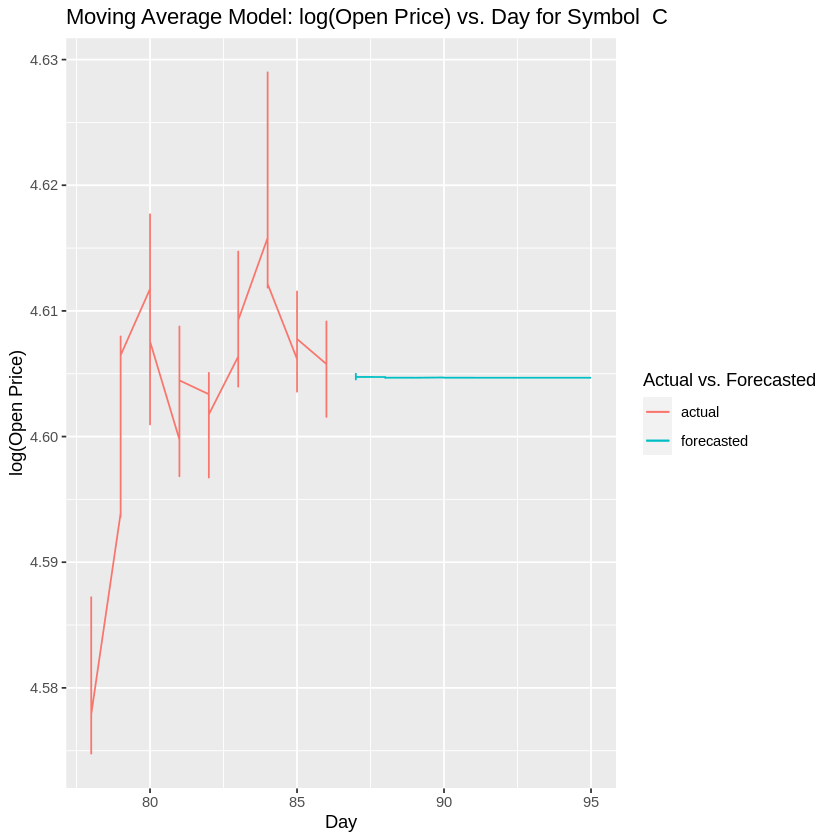

Saving 6.67 x 6.67 in image



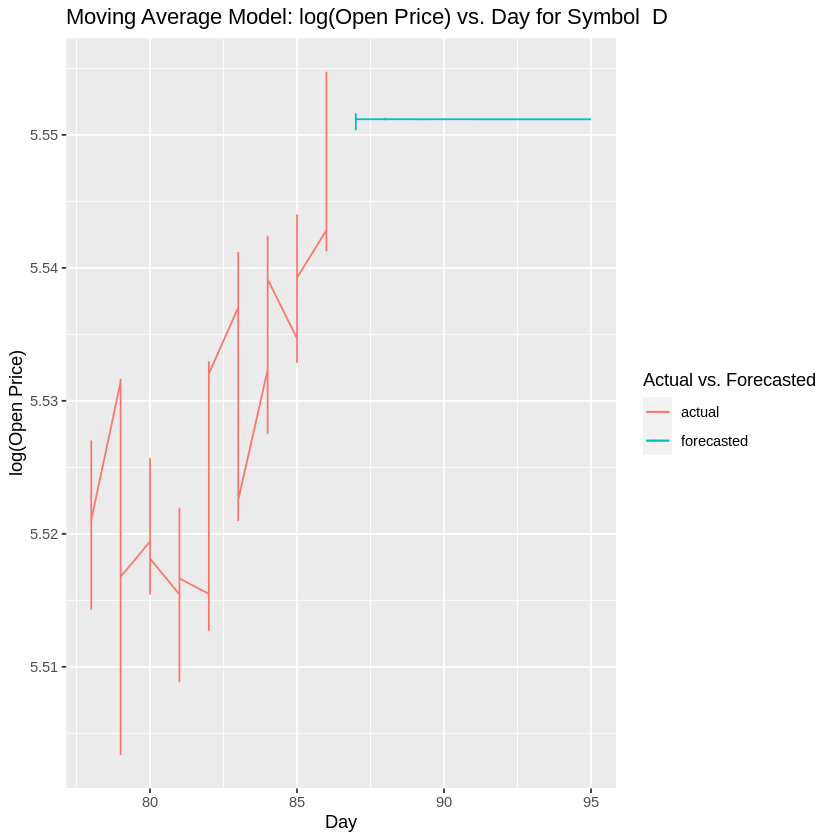

Saving 6.67 x 6.67 in image



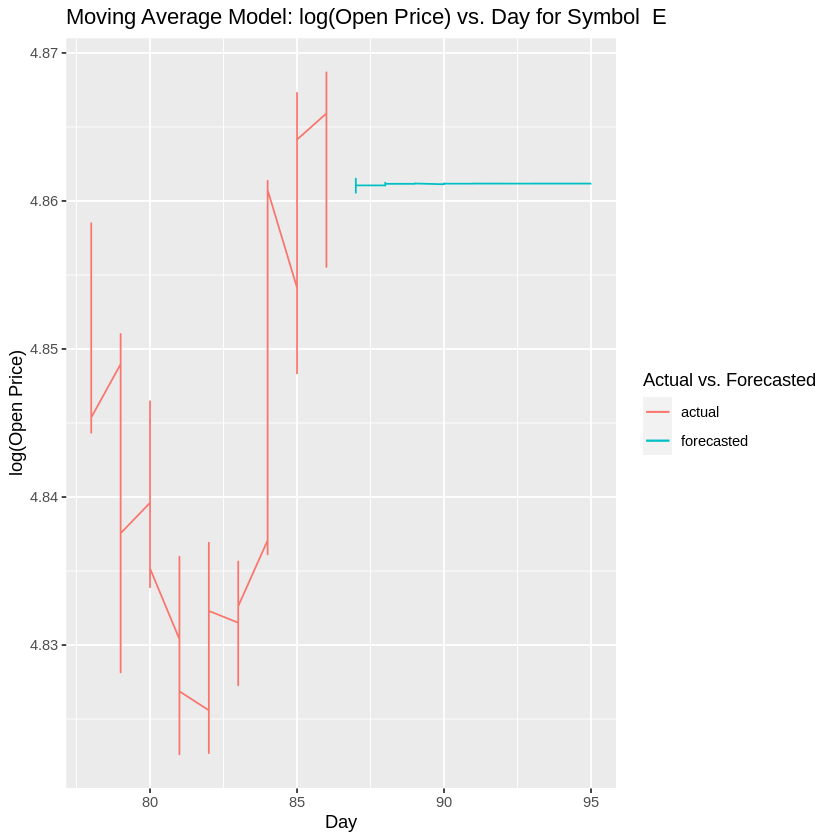

Saving 6.67 x 6.67 in image



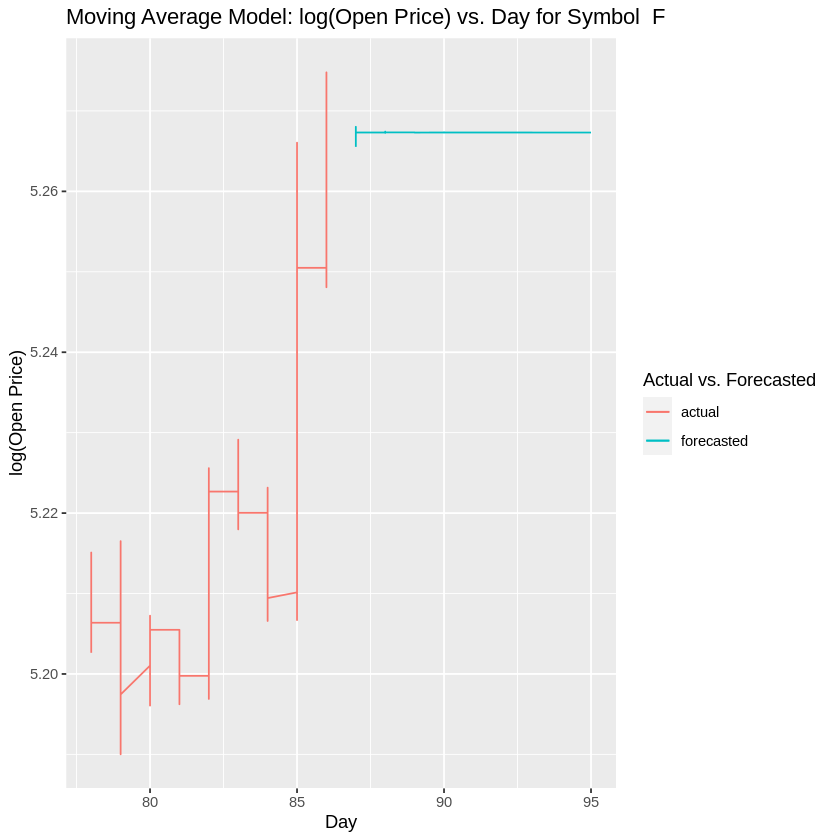

Saving 6.67 x 6.67 in image



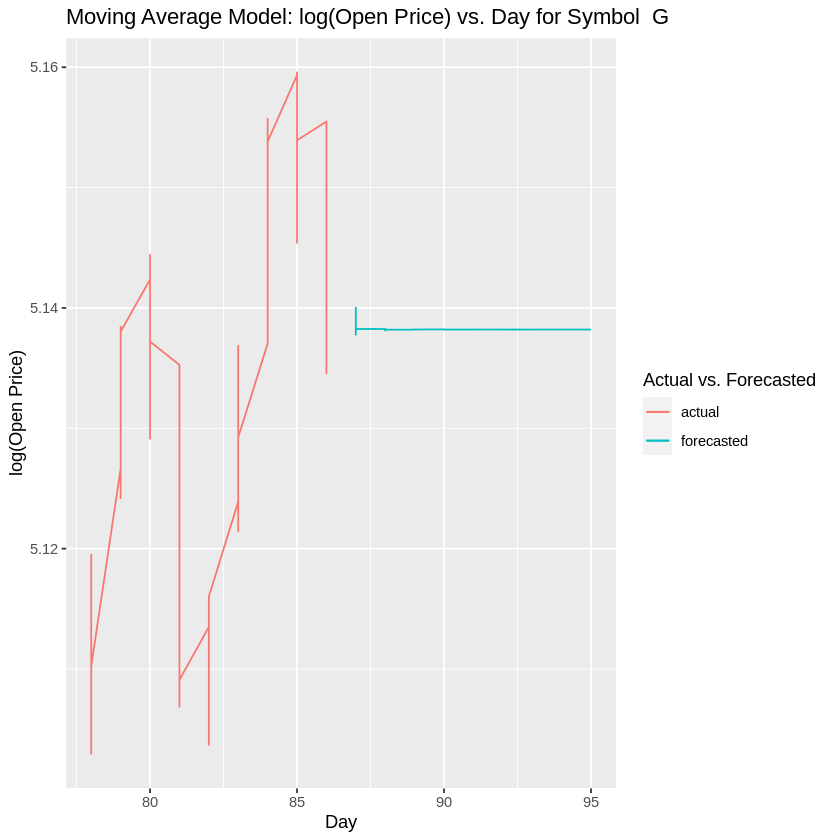

Saving 6.67 x 6.67 in image



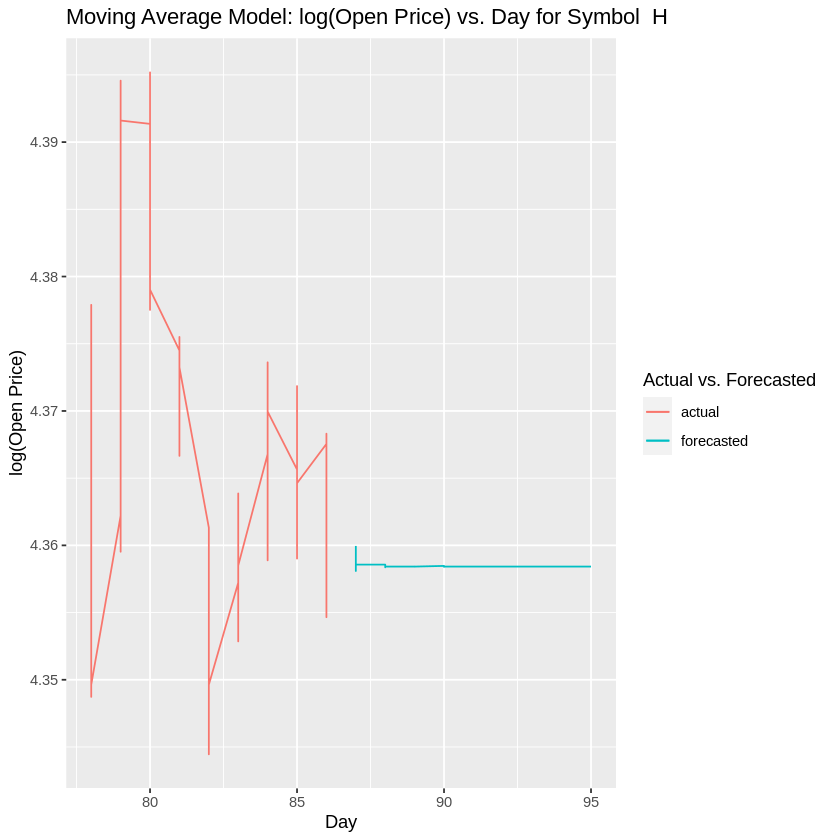

Saving 6.67 x 6.67 in image



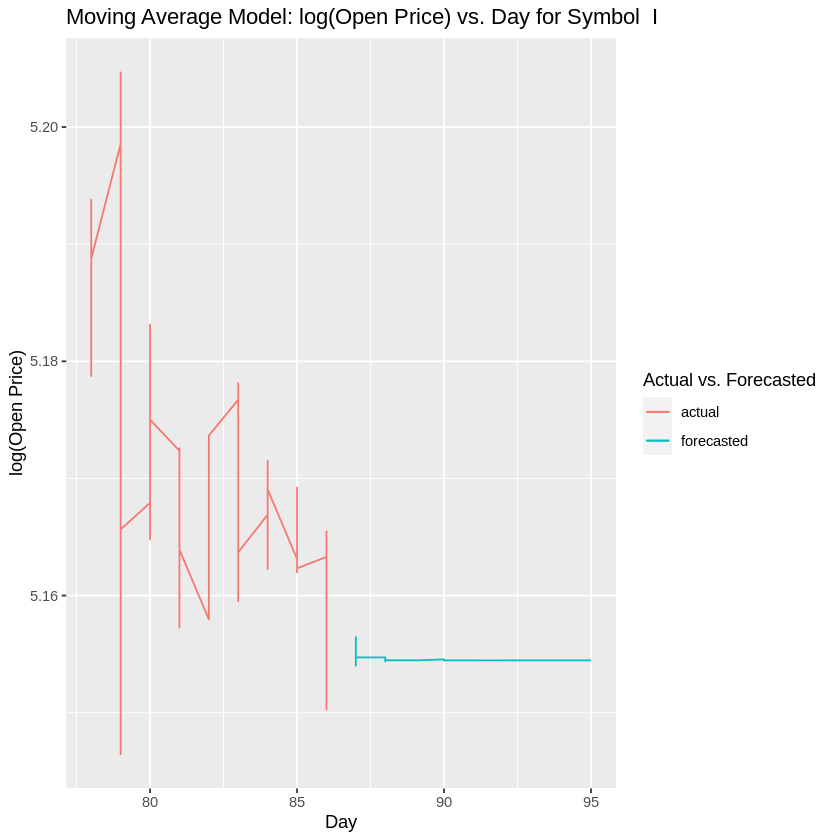

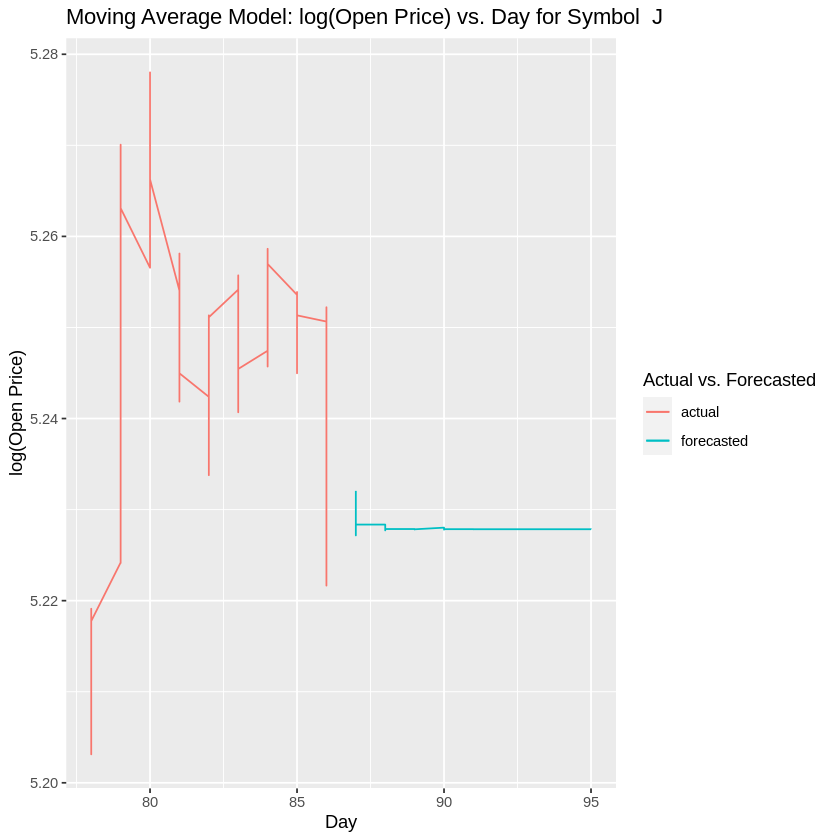

In [ ]:
# Graph of actual and forecasted prices, by ticker

# Put MA forecasts into a data frame. Recall that forecast has the format
# Stock A, days 87 through 95, then stock B, days 87 through 95, then stock C, 
# days 87 through 95, etc.
t <- rep(tickers, 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
d <- rep(d, 10)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 10*9)

# https://stackoverflow.com/questions/19535996/avoid-rbind-cbind-conversion-
# from-numeric-to-factor
ma_forecasted <- data.frame(cbind.data.frame(t, d, s, ma_forecast))
colnames(ma_forecasted) <- c("symbol", "day", "time", "log_forecasted_open")

for(i in tickers){
  myplot <-
  ggplot() +
  geom_line(data = filter(df_with_miss, symbol==i, day > 77),
            aes(x = day, y = log(open), color = "actual")) +
  geom_line(data = filter(ma_forecasted, symbol==i, day > 86),
            aes(x = day, y = log_forecasted_open, color = "forecasted")) +
  xlab("Day") +
  ylab("log(Open Price)") +
  guides(col = guide_legend(title = "Actual vs. Forecasted")) +
  ggtitle(paste('Moving Average Model: log(Open Price) vs. Day for Symbol ', i))
  
  print(myplot)
  
  ggsave(myplot,filename=paste("ma_forecast_", i ,".png",sep=""))
}


In [ ]:
# Get the moving average forecasts into the format needed by Kaggle

# Exponentiate the log prices to get raw prices
ma_forecasted$forecasted_open <- exp(ma_forecasted$log_forecasted_open)

# Order the prices by day, then time, then ticker
ma_forecasted <- ma_forecasted %>%
                  arrange(day, time)

# Remove the log(price) column to avoid confusion
ma_forecasted <- ma_forecasted[, c("symbol","day","time","forecasted_open")]

Next, we will use the arima() function with order (0,0,1), which represents a moving average regression model.

## Moving Average Regression Model


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "A" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9968     4.9428
s.e.  0.0001     0.0001

sigma^2 estimated as 0.0003364:  log likelihood = 1014100,  aic = -2028193


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "B" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9955     4.6799
s.e.  0.0001     0.0000

sigma^2 estimated as 0.0001999:  log likelihood = 1116467,  aic = -2232928


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "C" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9964     4.5712
s.e.  0.0001     0.0001

sigma^2 estimated as 0.0003815:  log likelihood = 989370.9,  aic = -1978736


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "D" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9978     5.4319
s.e.  0.0000     0.0001

sigma^2 estimated as 0.0005749:  log likelihood = 908789.7,  aic = -1817573


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "E" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9972     4.7976
s.e.  0.0001     0.0001

sigma^2 estimated as 0.0005207:  log likelihood = 928226,  aic = -1856446


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "F" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9967     5.1370
s.e.  0.0001     0.0001

sigma^2 estimated as 0.000393:  log likelihood = 983529.8,  aic = -1967054


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "G" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9960     5.1718
s.e.  0.0001     0.0001

sigma^2 estimated as 0.0003961:  log likelihood = 982018.8,  aic = -1964032


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "H" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9947     4.4782
s.e.  0.0001     0.0000

sigma^2 estimated as 0.0001832:  log likelihood = 1133620,  aic = -2267235

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”



Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "I" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.0000          0
s.e.  0.0016        NaN

sigma^2 estimated as 26.69:  log likelihood = 901706.4,  aic = -1803407


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "J" & df_with_miss$set != 
    "test"]), order = c(0, 0, 1), optim.method = "Nelder-Mead")

Coefficients:
         ma1  intercept
      0.9936      5.128
s.e.  0.0001      0.000

sigma^2 estimated as 0.0001207:  log likelihood = 1215567,  aic = -2431127

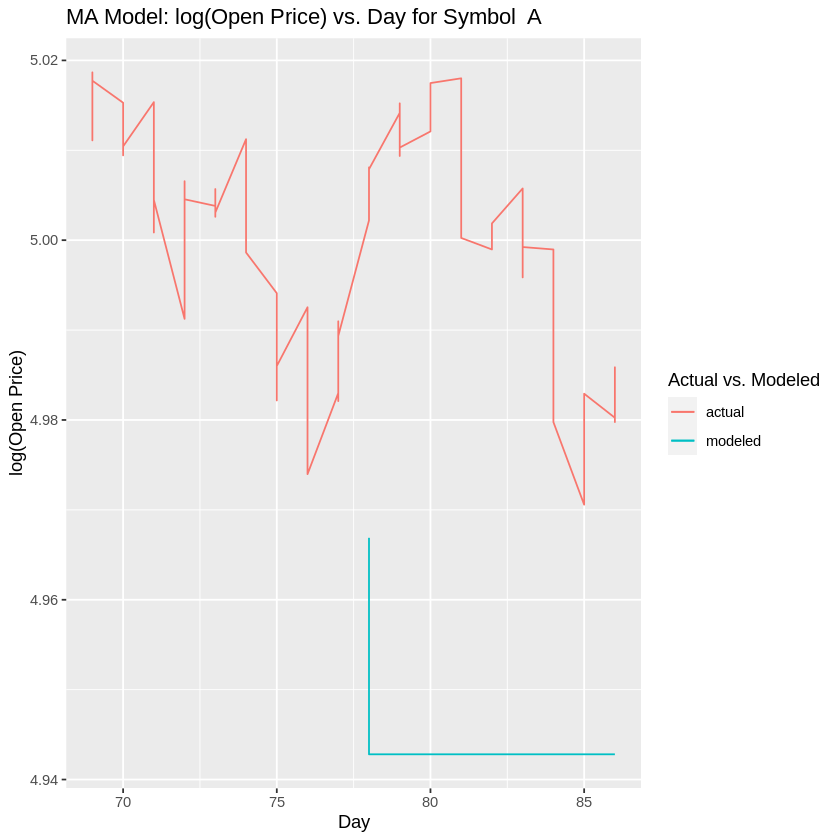

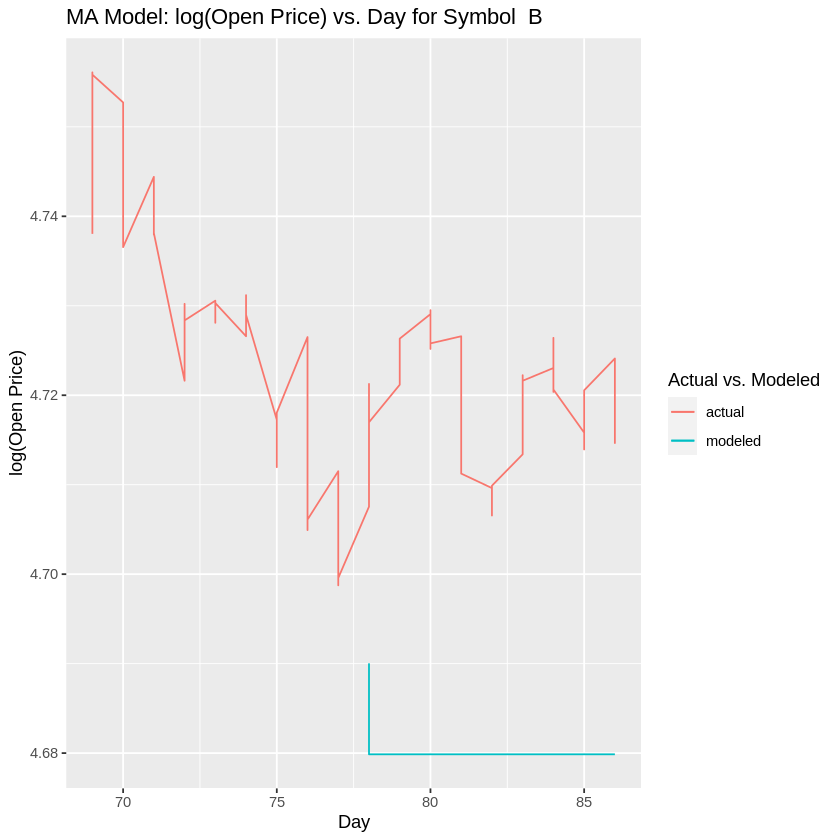

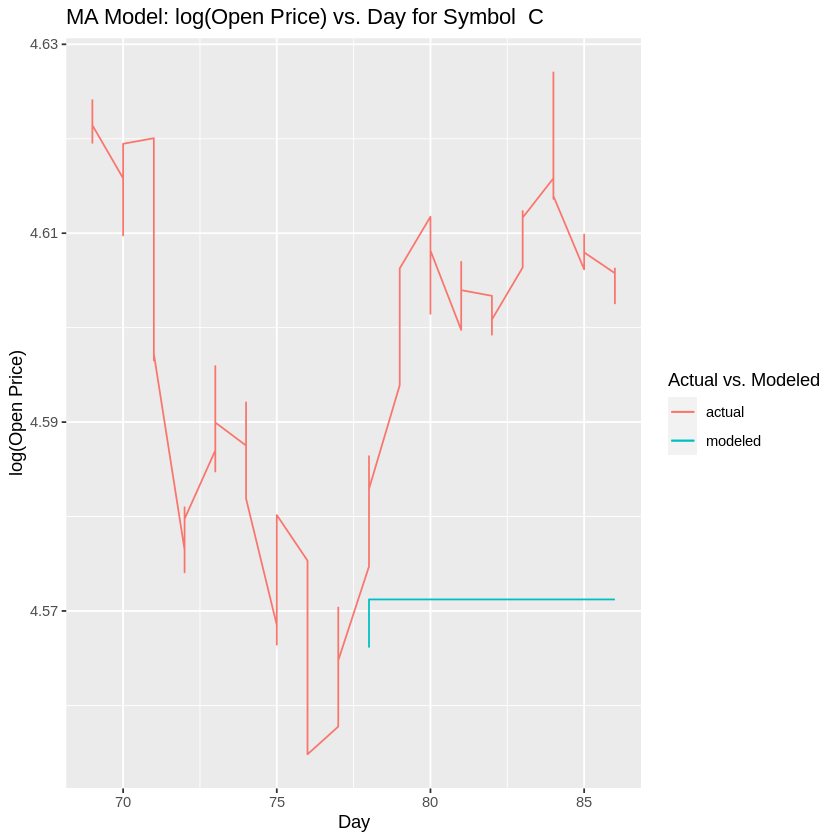

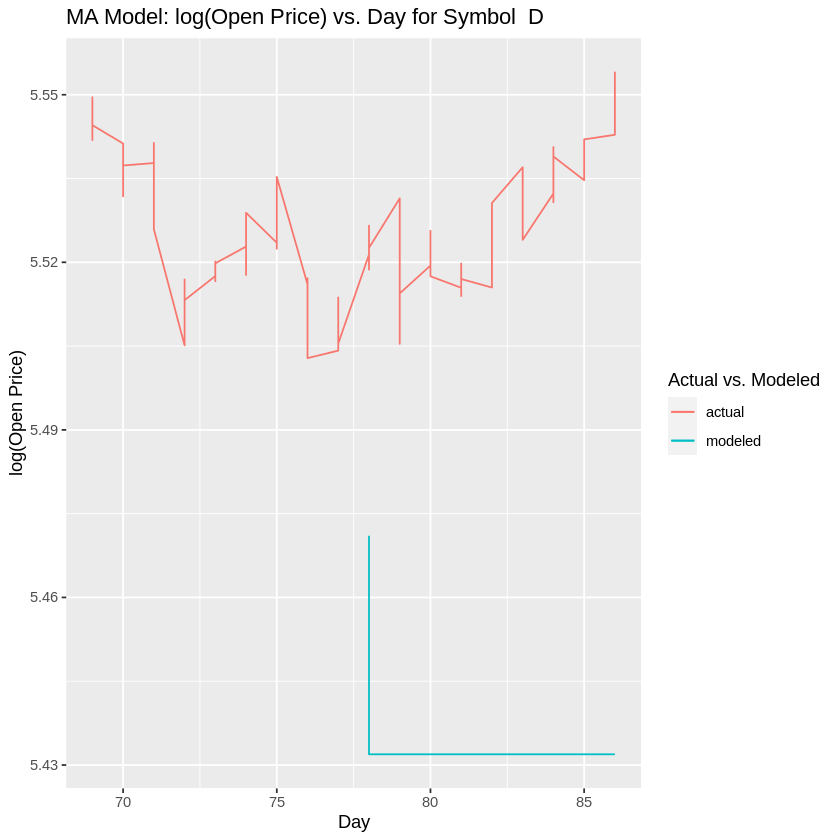

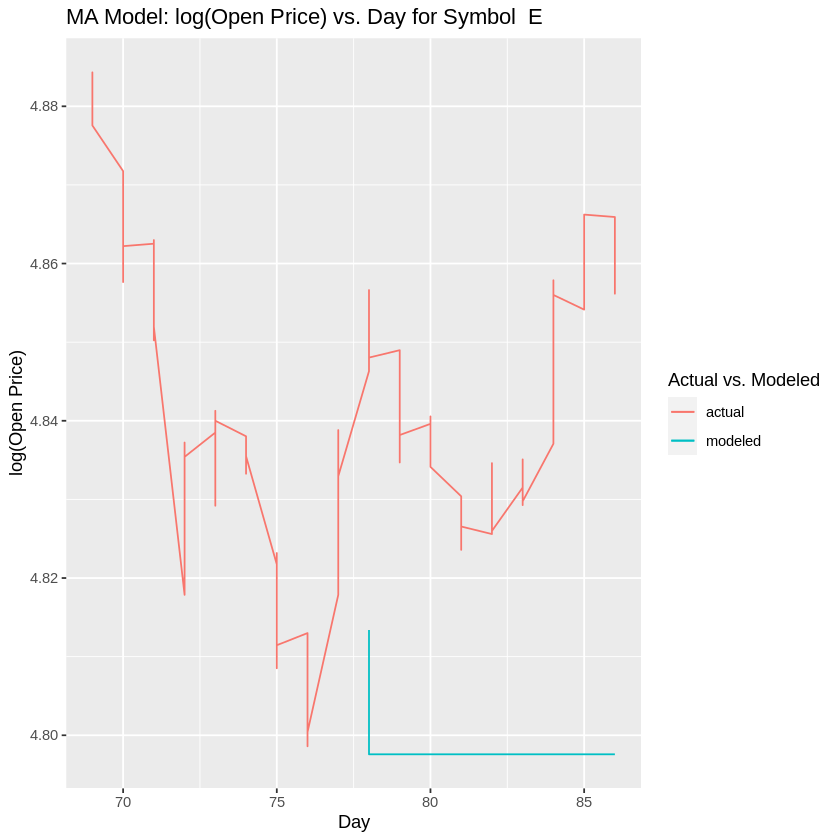

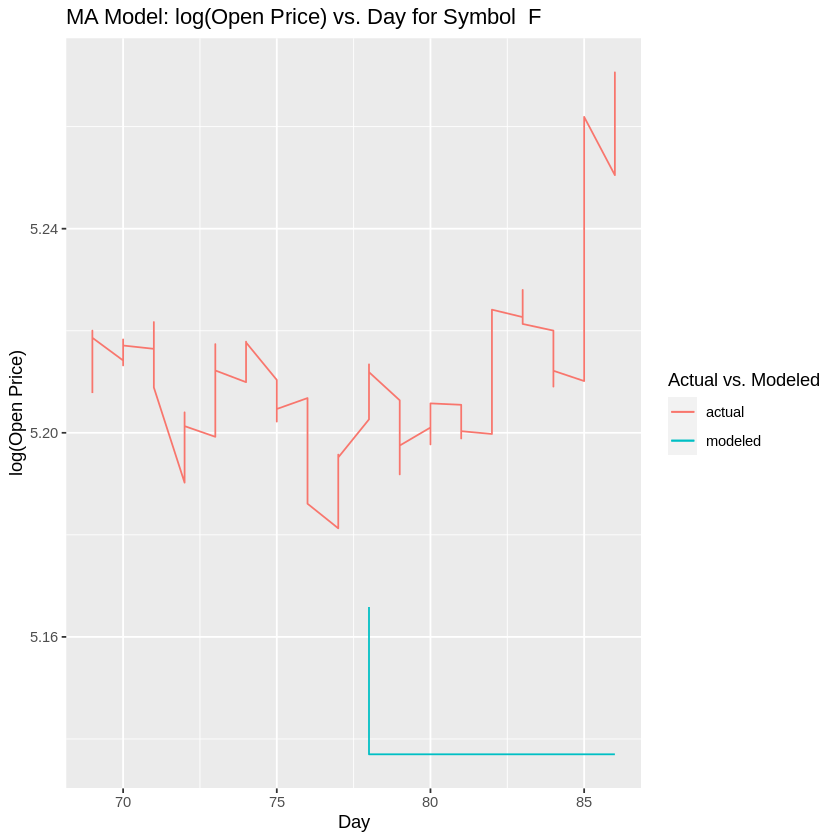

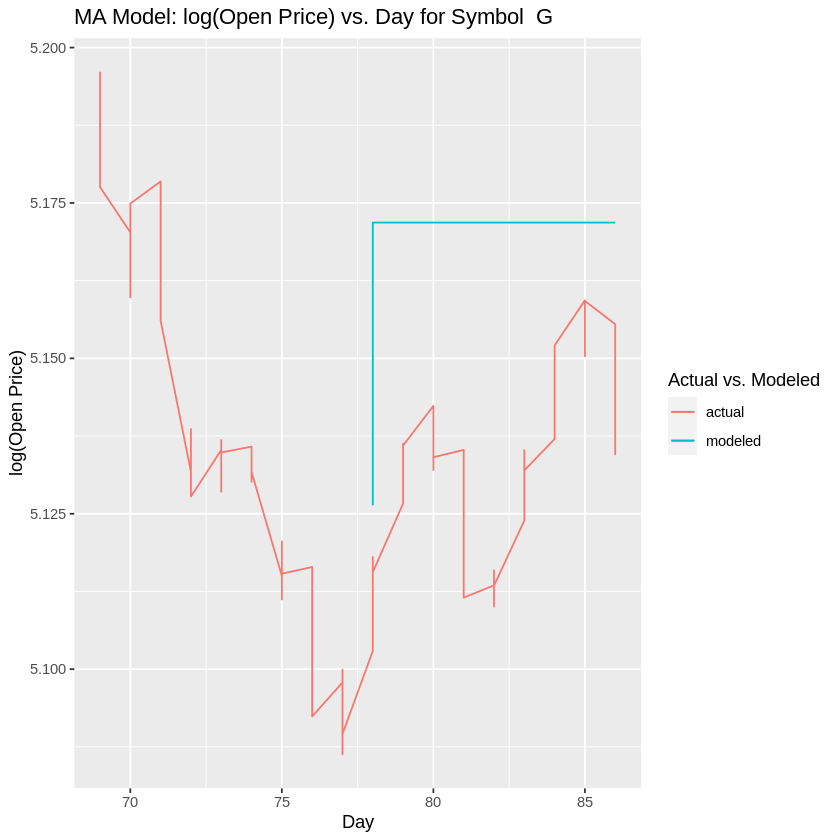

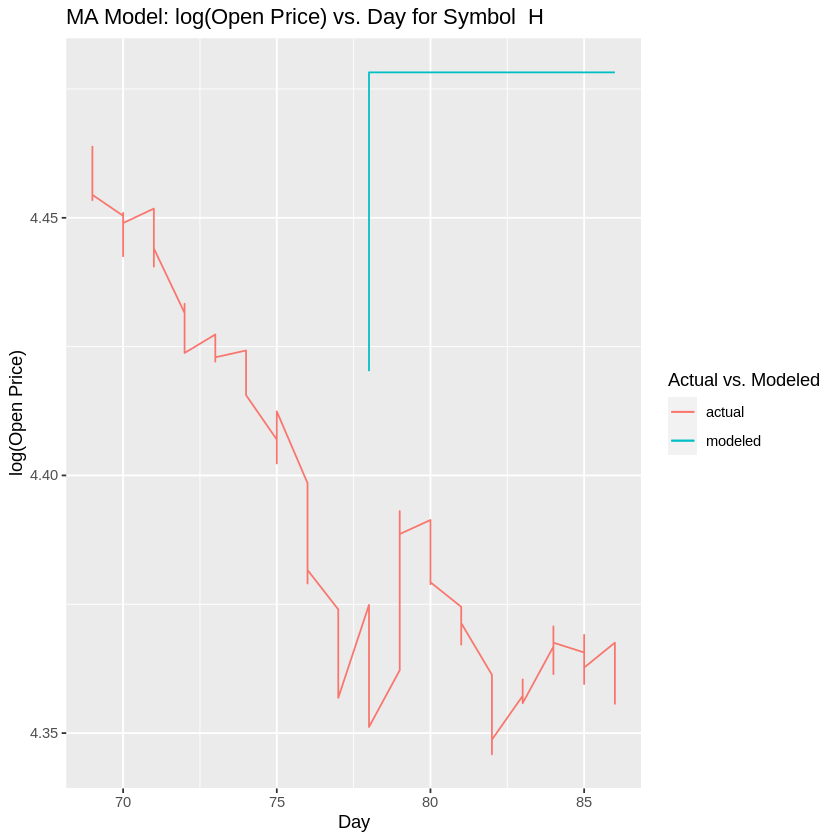

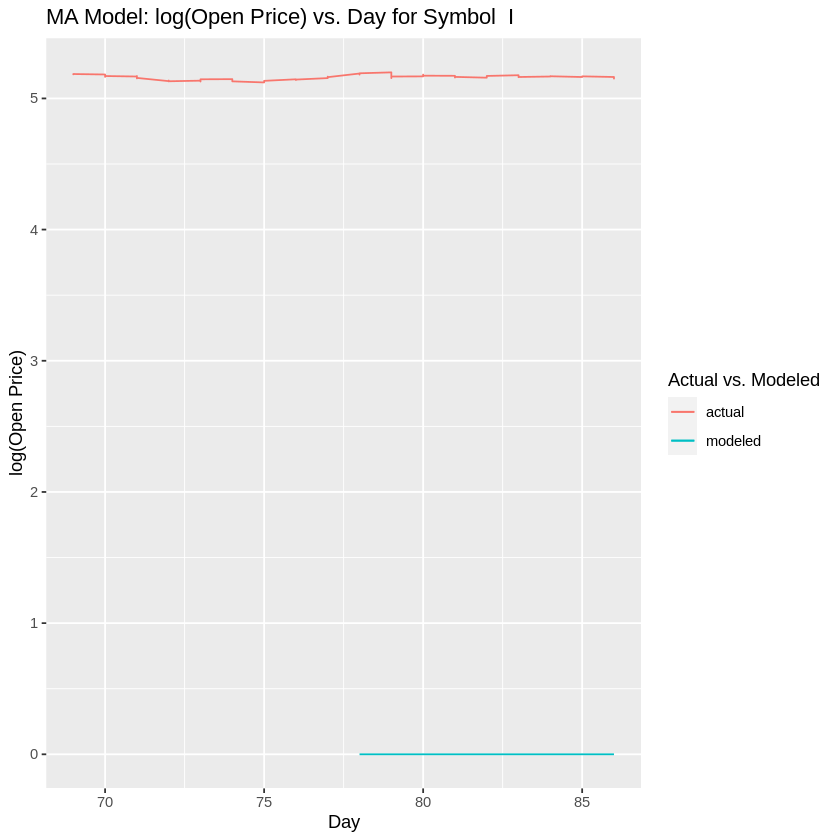

[1] 32111.84

[1] 31960.29

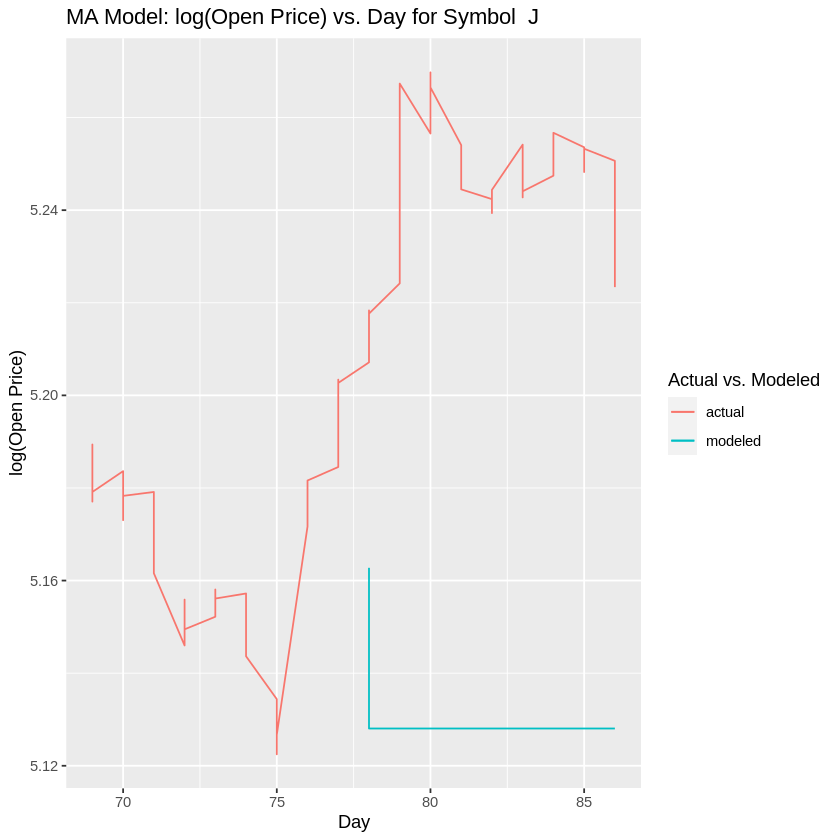

In [ ]:
# Ticker A

ma_a_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="A" 
      & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_a_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_a <- as.data.frame(predict(ma_a_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("A", 9*5040)
t <- sort(t)
d <- as.integer(rep(78:86, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
ma_a <- cbind.data.frame(t, d, s, forecast_ma_a$pred, 
      log(df_with_miss$open[df_with_miss$symbol=="A" & df_with_miss$set=="test"]))
colnames(ma_a) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_a$squared_error <- (exp(ma_a$ma_pred) - exp(ma_a$test_actual))^2

# Ticker B

ma_b_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="B" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_b_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_b <- as.data.frame(predict(ma_b_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("B", 9*5040)
t <- sort(t)
ma_b <- cbind.data.frame(t, d, s, forecast_ma_b$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="B" & df_with_miss$set=="test"]))
colnames(ma_b) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_b$squared_error <- (exp(ma_b$ma_pred) - exp(ma_b$test_actual))^2

# Ticker C

ma_c_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="C" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_c_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_c <- as.data.frame(predict(ma_c_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("C", 9*5040)
t <- sort(t)
ma_c <- cbind.data.frame(t, d, s, forecast_ma_c$pred, 
  log(df_with_miss$open[df_with_miss$symbol=="C" & df_with_miss$set=="test"]))
colnames(ma_c) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_c$squared_error <- (exp(ma_c$ma_pred) - exp(ma_c$test_actual))^2

# Ticker D

ma_d_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="D" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_d_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_d <- as.data.frame(predict(ma_d_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("D", 9*5040)
t <- sort(t)
ma_d <- cbind.data.frame(t, d, s, forecast_ma_d$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="D" & df_with_miss$set=="test"]))
colnames(ma_d) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_d$squared_error <- (exp(ma_d$ma_pred) - exp(ma_d$test_actual))^2

# Ticker E

ma_e_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="E" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_e_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_e <- as.data.frame(predict(ma_e_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("E", 9*5040)
t <- sort(t)
ma_e <- cbind.data.frame(t, d, s, forecast_ma_e$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="E" & df_with_miss$set=="test"]))
colnames(ma_e) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_e$squared_error <- (exp(ma_e$ma_pred) - exp(ma_e$test_actual))^2

# Ticker F

ma_f_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="F" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_f_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_f <- as.data.frame(predict(ma_f_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("F", 9*5040)
t <- sort(t)
ma_f <- cbind.data.frame(t, d, s, forecast_ma_f$pred, 
  log(df_with_miss$open[df_with_miss$symbol=="F" & df_with_miss$set=="test"]))
colnames(ma_f) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_f$squared_error <- (exp(ma_f$ma_pred) - exp(ma_f$test_actual))^2

# Ticker G

ma_g_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="G" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_g_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_g <- as.data.frame(predict(ma_g_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("G", 9*5040)
t <- sort(t)
ma_g <- cbind.data.frame(t, d, s, forecast_ma_g$pred, 
  log(df_with_miss$open[df_with_miss$symbol=="G" & df_with_miss$set=="test"]))
colnames(ma_g) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_g$squared_error <- (exp(ma_g$ma_pred) - exp(ma_g$test_actual))^2

# Ticker H
ma_h_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="H" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_h_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_h <- as.data.frame(predict(ma_h_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("H", 9*5040)
t <- sort(t)
ma_h <- cbind.data.frame(t, d, s, forecast_ma_h$pred, 
  log(df_with_miss$open[df_with_miss$symbol=="H" & df_with_miss$set=="test"]))
colnames(ma_h) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_h$squared_error <- (exp(ma_h$ma_pred) - exp(ma_h$test_actual))^2

# Ticker I

ma_i_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="I" 
      & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_i_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_i <- as.data.frame(predict(ma_i_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("I", 9*5040)
t <- sort(t)
ma_i <- cbind.data.frame(t, d, s, forecast_ma_i$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="I" & df_with_miss$set=="test"]))
colnames(ma_i) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_i$squared_error <- (exp(ma_i$ma_pred) - exp(ma_i$test_actual))^2

# Ticker J

ma_j_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="J" 
    & df_with_miss$set!="test"]), order = c(0,0,1), optim.method="Nelder-Mead")
ma_j_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_ma_j <- as.data.frame(predict(ma_j_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("J", 9*5040)
t <- sort(t)
ma_j <- cbind.data.frame(t, d, s, forecast_ma_j$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="J" & df_with_miss$set=="test"]))
colnames(ma_j) <- c("symbol", "day", "time", "ma_pred", "test_actual")

# Add column with squared error
ma_j$squared_error <- (exp(ma_j$ma_pred) - exp(ma_j$test_actual))^2

# Change the prediction and squared error values from class ts to class numeric
ma_a$ma_pred <- as.numeric(ma_a$ma_pred)
ma_a$squared_error <- as.numeric(ma_a$squared_error)
ma_b$ma_pred <- as.numeric(ma_b$ma_pred)
ma_b$squared_error <- as.numeric(ma_b$squared_error)
ma_c$ma_pred <- as.numeric(ma_c$ma_pred)
ma_c$squared_error <- as.numeric(ma_c$squared_error)
ma_d$ma_pred <- as.numeric(ma_d$ma_pred)
ma_d$squared_error <- as.numeric(ma_d$squared_error)
ma_e$ma_pred <- as.numeric(ma_e$ma_pred)
ma_e$squared_error <- as.numeric(ma_e$squared_error)
ma_f$ma_pred <- as.numeric(ma_f$ma_pred)
ma_f$squared_error <- as.numeric(ma_f$squared_error)
ma_g$ma_pred <- as.numeric(ma_g$ma_pred)
ma_g$squared_error <- as.numeric(ma_g$squared_error)
ma_h$ma_pred <- as.numeric(ma_h$ma_pred)
ma_h$squared_error <- as.numeric(ma_h$squared_error)
ma_i$ma_pred <- as.numeric(ma_i$ma_pred)
ma_i$squared_error <- as.numeric(ma_i$squared_error)
ma_j$ma_pred <- as.numeric(ma_j$ma_pred)
ma_j$squared_error <- as.numeric(ma_j$squared_error)

# Bind arima dfs by ticker into one data frame
ma_df <- rbind.data.frame(ma_a, ma_b, ma_c, ma_d, ma_e,
                             ma_f, ma_g, ma_h, ma_i, ma_j)

# Add time to big data frame, which may be missing this element for intervals
# with missing values
s2 <- unique(df_with_miss$time)
s2 <- sort(s2)
s2 <- rep(s2, 10*87)
df_with_miss$time <- s2 

# Plot actual vs. predicted by ticker
for(i in tickers){
  myplot <-
    ggplot() +
    geom_line(data = filter(df_with_miss, symbol==i, time=="06:00:00" | 
                              time=="07:00:00" | time=="08:00:00" | 
                              time=="09:00:00" | time=="10:00:00" | 
                              time=="11:00:00" | time=="12:00:00", day > 68),
              aes(x = day, y = log(open), color = "actual")) +
    geom_line(data = filter(ma_df, symbol==i, time=="06:00:00" | 
                              time=="07:00:00" | time=="08:00:00" | 
                              time=="09:00:00" | time=="10:00:00" | 
                              time=="11:00:00" | time=="12:00:00", day > 77),
              aes(x = day, y = ma_pred, color = "modeled")) +
    xlab("Day") +
    ylab("log(Open Price)") +
    guides(col = guide_legend(title = "Actual vs. Modeled")) +
    ggtitle(paste('MA Model: log(Open Price) vs. Day for Symbol ', i))
  
  print(myplot)
  
}

# Calculate the error on the test set, using formula on page 2 of 
# "final_project.pdf"

# Test error for days 78-81
first_error <- (1/4)*(1/5040)*
  ( sum(ma_df$squared_error[ma_df$day < 82]) )
first_error

# Test error for days 82-86
second_error <- (1/5)*(1/5040)* 
  ( sum(ma_df$squared_error[ma_df$day > 81]) )
second_error

We were not able to use the default optimization routine in arima() with order c(0,0,1); doing so yielded errors. We switched to the Nelder-Mead algorithm (https://stat.ethz.ch/pipermail/r-help/2015-February/425777.html) and were able to get output. Ticker I remained problematic, with the predictions being zero. The issues in running these models suggest that a moving average regression model may not be valid for this data set. In particular, the data set may not be stationary (https://stat.ethz.ch/pipermail/r-help/2004-September/058074.html). This means that it's not appropriate to fit a model of order (0,0,1).

## ARIMA Model

We will first use the auto.arima() function to select optimal values of parameters p, d, and q, then tune the selections as needed.

Series: log(df_with_miss$open[df_with_miss$symbol == "A" & df_with_miss$set !=      "test"]) 
ARIMA(2,1,2) 

Coefficients:
          ar1      ar2      ma1      ma2
      -0.0154  -0.0049  -0.0151  -0.0054
s.e.   0.0709   0.0932   0.0708   0.0987

sigma^2 estimated as 2.589e-08:  log likelihood=2876448
AIC=-5752886   AICc=-5752886   BIC=-5752831

Series: log(df_with_miss$open[df_with_miss$symbol == "B" & df_with_miss$set !=      "test"]) 
ARIMA(3,1,0) 

Coefficients:
          ar1      ar2     ar3
      -0.0493  -0.0126  0.0056
s.e.   0.0016   0.0016  0.0016

sigma^2 estimated as 3.028e-08:  log likelihood=2845540
AIC=-5691071   AICc=-5691071   BIC=-5691028

Series: log(df_with_miss$open[df_with_miss$symbol == "C" & df_with_miss$set !=      "test"]) 
ARIMA(0,1,5) 

Coefficients:
          ma1      ma2      ma3      ma4      ma5
      -0.0283  -0.0100  -0.0039  -0.0046  -0.0092
s.e.   0.0016   0.0016   0.0016   0.0016   0.0016

sigma^2 estimated as 3.331e-08:  log likelihood=2826766
AIC=-5653520   AICc=-5653520   BIC=-5653455

Series: log(df_with_miss$open[df_with_miss$symbol == "D" & df_with_miss$set !=      "test"]) 
ARIMA(0,1,0) 

sigma^2 estimated as 2.494e-08:  log likelihood=2883882
AIC=-5767762   AICc=-5767762   BIC=-5767751

Series: log(df_with_miss$open[df_with_miss$symbol == "E" & df_with_miss$set !=      "test"]) 
ARIMA(0,1,3) 

Coefficients:
          ma1      ma2     ma3
      -0.0275  -0.0512  0.0041
s.e.   0.0016   0.0016  0.0016

sigma^2 estimated as 3.046e-08:  log likelihood=2844371
AIC=-5688734   AICc=-5688734   BIC=-5688691

Series: log(df_with_miss$open[df_with_miss$symbol == "F" & df_with_miss$set !=      "test"]) 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.0342  -0.0069
s.e.   0.0016   0.0016

sigma^2 estimated as 3.142e-08:  log likelihood=2838317
AIC=-5676628   AICc=-5676628   BIC=-5676595

Series: log(df_with_miss$open[df_with_miss$symbol == "G" & df_with_miss$set !=      "test"]) 
ARIMA(5,2,0) 

Coefficients:
          ar1      ar2      ar3      ar4      ar5
      -0.8493  -0.6759  -0.5170  -0.3384  -0.1707
s.e.   0.0016   0.0020   0.0021   0.0020   0.0016

sigma^2 estimated as 5.1e-08:  log likelihood=2743212
AIC=-5486412   AICc=-5486412   BIC=-5486347

Series: log(df_with_miss$open[df_with_miss$symbol == "H" & df_with_miss$set !=      "test"]) 
ARIMA(5,2,0) 

Coefficients:
          ar1      ar2      ar3      ar4      ar5
      -0.9622  -0.7822  -0.5823  -0.3761  -0.1747
s.e.   0.0016   0.0021   0.0023   0.0021   0.0016

sigma^2 estimated as 3.319e-08:  log likelihood=2827715
AIC=-5655417   AICc=-5655417   BIC=-5655352

Series: log(df_with_miss$open[df_with_miss$symbol == "I" & df_with_miss$set !=      "test"]) 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.0331  -0.0043
s.e.   0.0016   0.0016

sigma^2 estimated as 3.939e-08:  log likelihood=2793821
AIC=-5587636   AICc=-5587636   BIC=-5587604

Series: log(df_with_miss$open[df_with_miss$symbol == "J" & df_with_miss$set !=      "test"]) 
ARIMA(0,1,3) 

Coefficients:
          ma1      ma2      ma3
      -0.0215  -0.0040  -0.0033
s.e.   0.0016   0.0016   0.0016

sigma^2 estimated as 3.936e-08:  log likelihood=2793996
AIC=-5587984   AICc=-5587984   BIC=-5587940

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



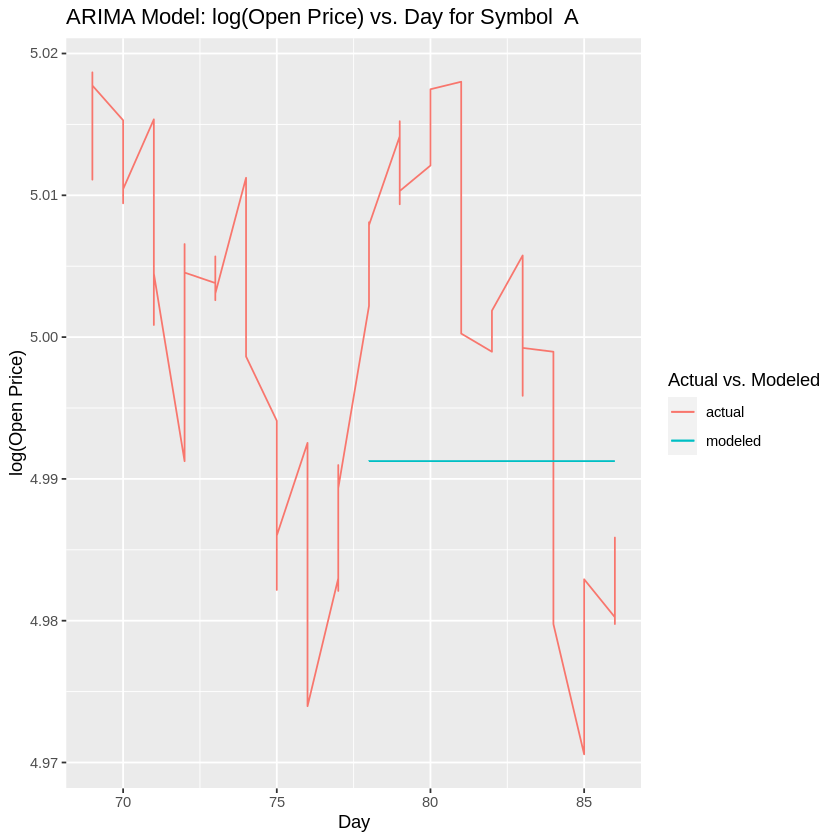

Saving 6.67 x 6.67 in image



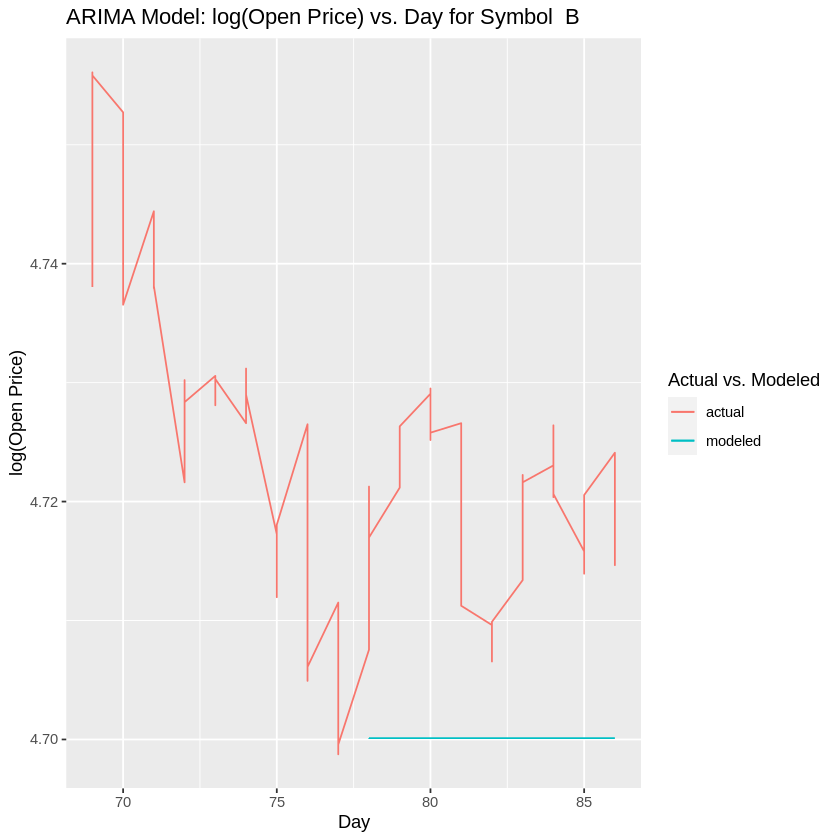

Saving 6.67 x 6.67 in image



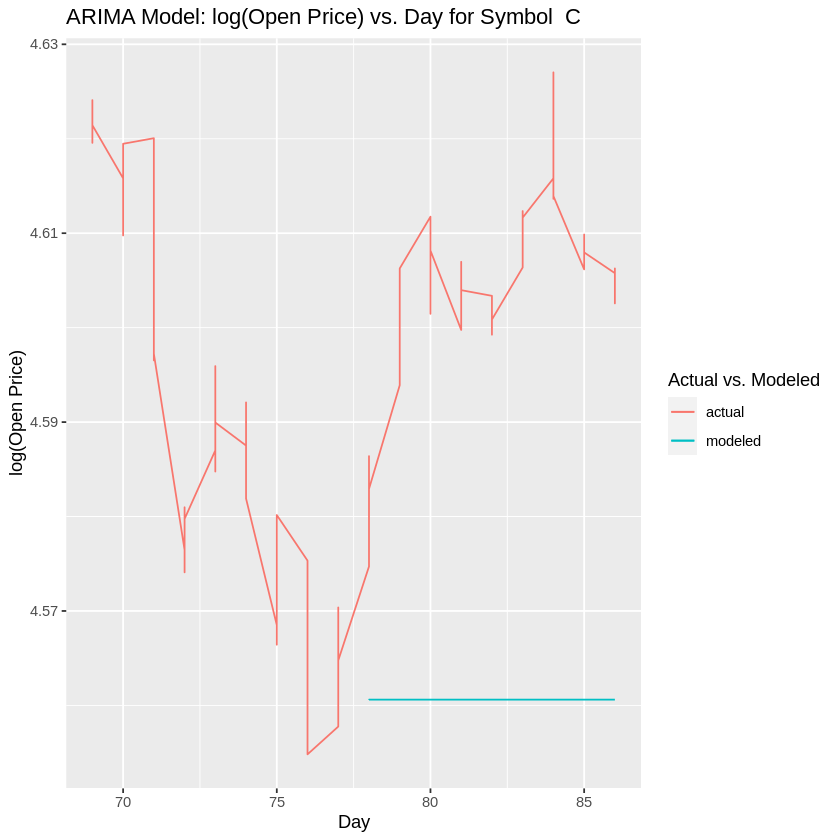

Saving 6.67 x 6.67 in image



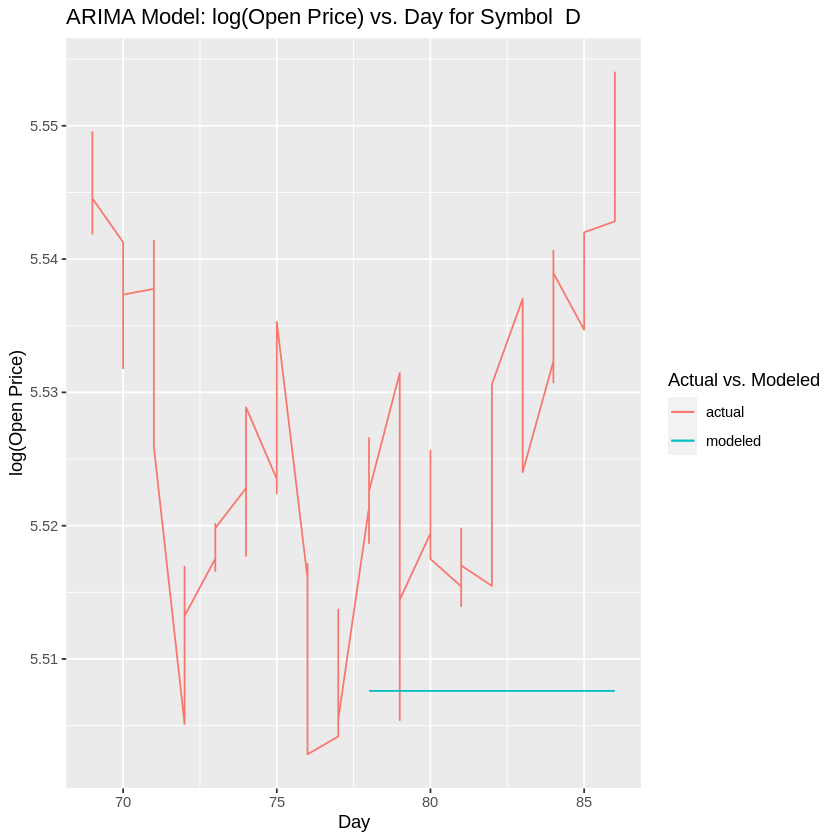

Saving 6.67 x 6.67 in image



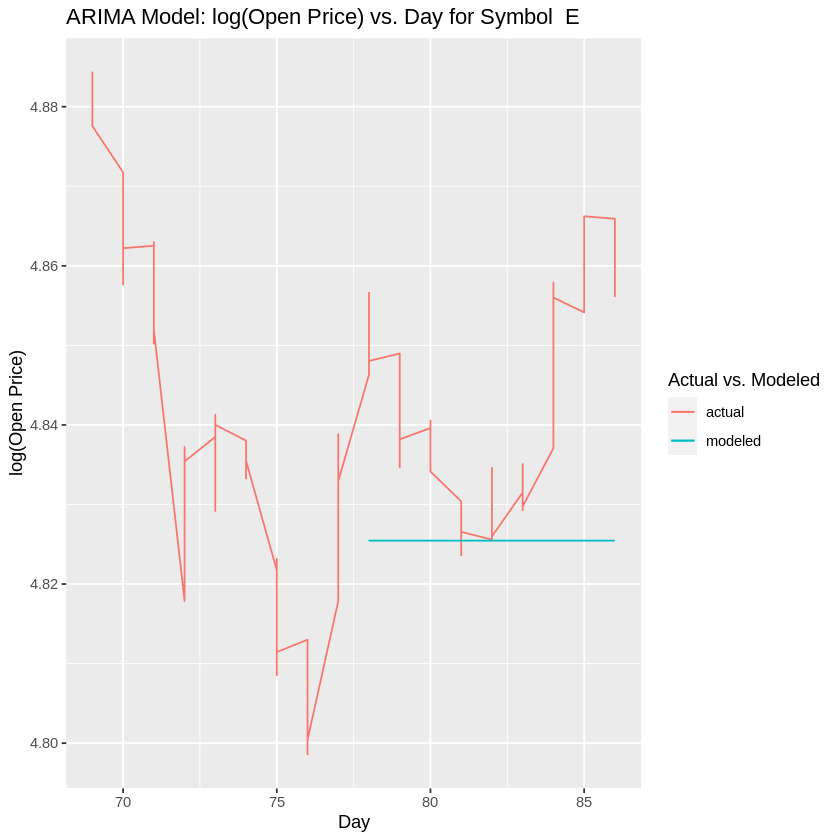

Saving 6.67 x 6.67 in image



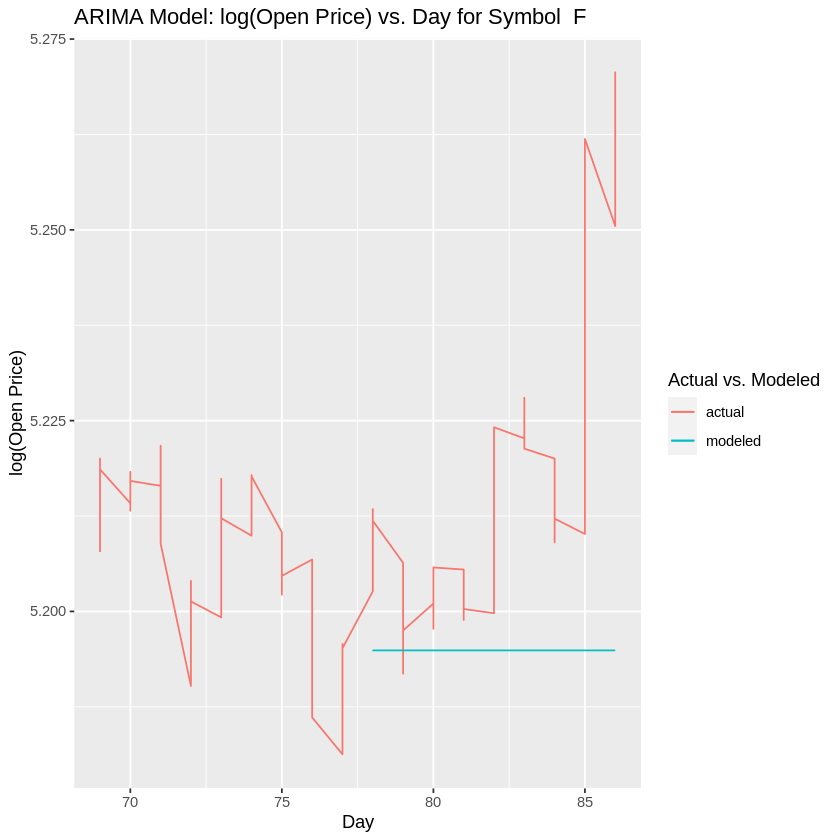

Saving 6.67 x 6.67 in image



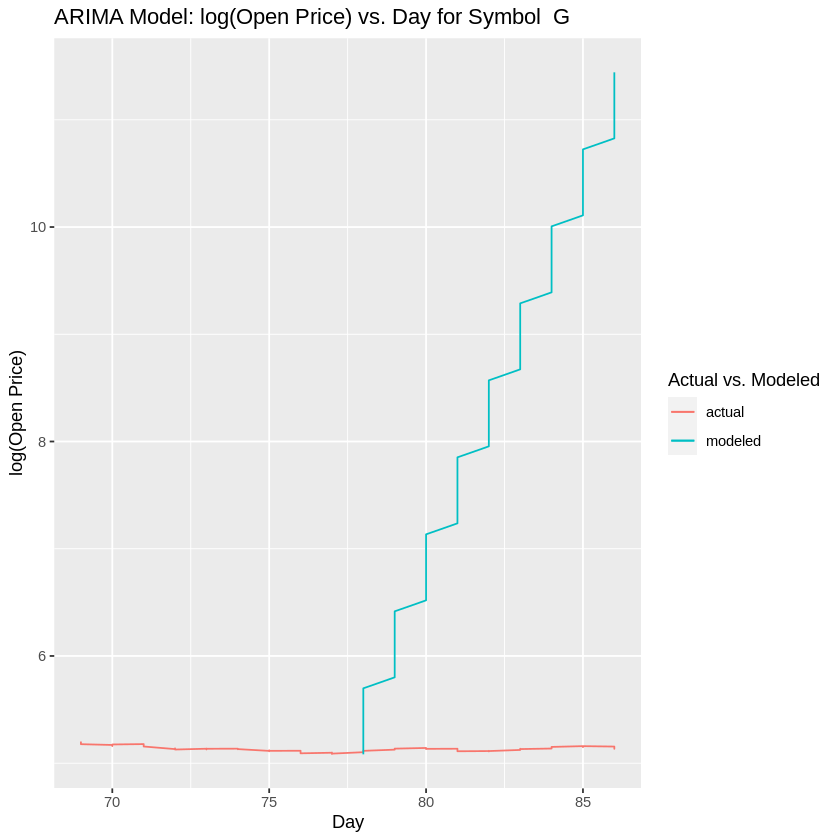

Saving 6.67 x 6.67 in image



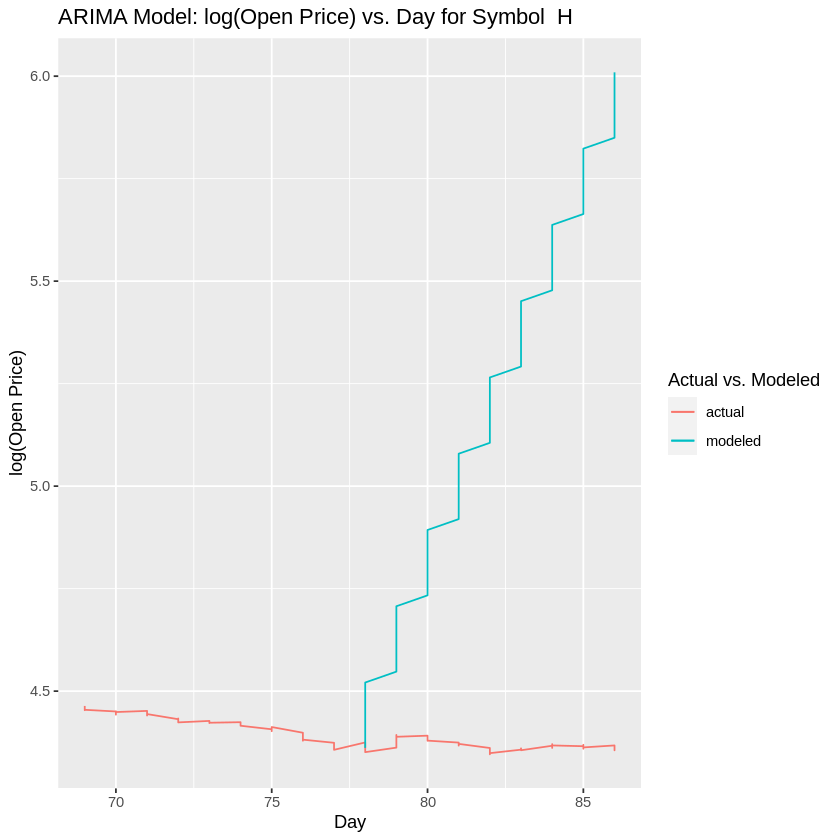

Saving 6.67 x 6.67 in image



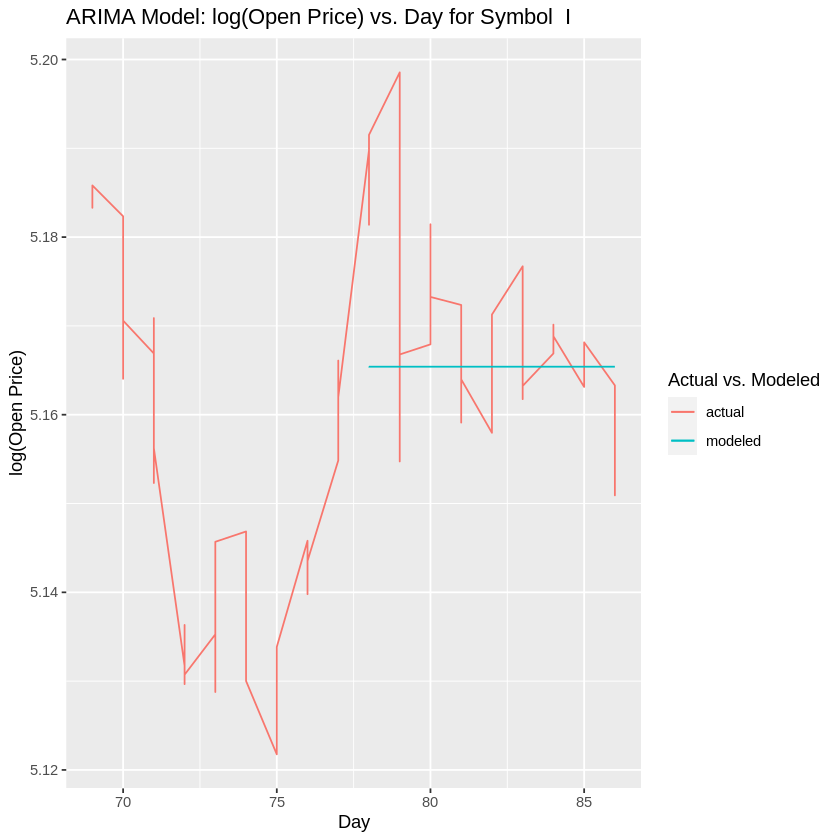

[1] 1125032

[1] 1473184569

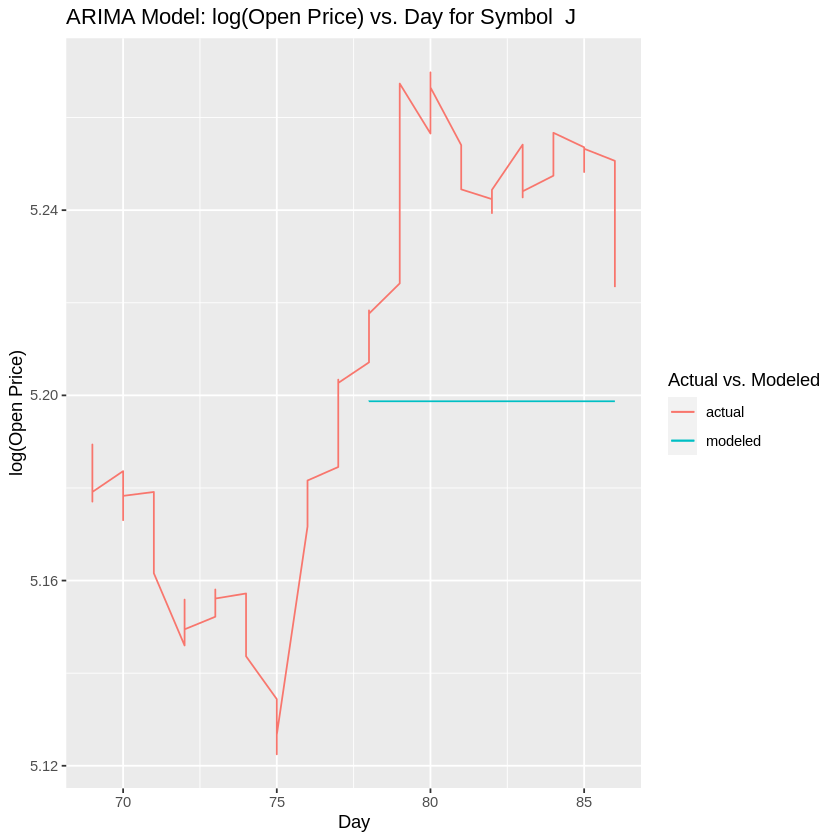

In [ ]:
# Identify the training, development, and test set observations
# Train: 0-68, dev: 69-77; test: 78-86 (user input)
dev_split <- 78
train_split <- 69
df_with_miss$set <- "test"
df_with_miss$set[df_with_miss$day < dev_split] <- "dev"
df_with_miss$set[df_with_miss$day < train_split] <- "train"

# https://rpubs.com/riazakhan94/arima_with_example
# Run ARIMA model by ticker

# Ticker A

arima_a_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="A" 
                                            & df_with_miss$set!="test"]))
arima_a_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_a <- as.data.frame(predict(arima_a_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("A", 9*5040)
t <- sort(t)
d <- as.integer(rep(78:86, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_a <- cbind.data.frame(t, d, s, forecast_arima_a$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="A" & df_with_miss$set=="test"]))
colnames(arima_a) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_a$squared_error <- (exp(arima_a$arima_pred) - exp(arima_a$test_actual))^2

# Ticker B

arima_b_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="B" 
                                            & df_with_miss$set!="test"]))
arima_b_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_b <- as.data.frame(predict(arima_b_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("B", 9*5040)
t <- sort(t)
arima_b <- cbind.data.frame(t, d, s, forecast_arima_b$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="B" & df_with_miss$set=="test"]))
colnames(arima_b) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_b$squared_error <- (exp(arima_b$arima_pred) - exp(arima_b$test_actual))^2

# Ticker C

arima_c_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="C" 
                                              & df_with_miss$set!="test"]))
arima_c_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_c <- as.data.frame(predict(arima_c_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("C", 9*5040)
t <- sort(t)
arima_c <- cbind.data.frame(t, d, s, forecast_arima_c$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="C" & df_with_miss$set=="test"]))
colnames(arima_c) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_c$squared_error <- (exp(arima_c$arima_pred) - exp(arima_c$test_actual))^2

# Ticker D

arima_d_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="D" 
                                              & df_with_miss$set!="test"]))
arima_d_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_d <- as.data.frame(predict(arima_d_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("D", 9*5040)
t <- sort(t)
arima_d <- cbind.data.frame(t, d, s, forecast_arima_d$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="D" & df_with_miss$set=="test"]))
colnames(arima_d) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_d$squared_error <- (exp(arima_d$arima_pred) - exp(arima_d$test_actual))^2

# Ticker E

arima_e_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="E" 
                                              & df_with_miss$set!="test"]))
arima_e_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_e <- as.data.frame(predict(arima_e_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("E", 9*5040)
t <- sort(t)
arima_e <- cbind.data.frame(t, d, s, forecast_arima_e$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="E" & df_with_miss$set=="test"]))
colnames(arima_e) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_e$squared_error <- (exp(arima_e$arima_pred) - exp(arima_e$test_actual))^2

# Ticker F

arima_f_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="F" 
                                              & df_with_miss$set!="test"]))
arima_f_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_f <- as.data.frame(predict(arima_f_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("F", 9*5040)
t <- sort(t)
arima_f <- cbind.data.frame(t, d, s, forecast_arima_f$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="F" & df_with_miss$set=="test"]))
colnames(arima_f) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_f$squared_error <- (exp(arima_f$arima_pred) - exp(arima_f$test_actual))^2

# Ticker G

arima_g_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="G" 
                                              & df_with_miss$set!="test"]))
arima_g_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_g <- as.data.frame(predict(arima_g_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("G", 9*5040)
t <- sort(t)
arima_g <- cbind.data.frame(t, d, s, forecast_arima_g$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="G" & df_with_miss$set=="test"]))
colnames(arima_g) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_g$squared_error <- (exp(arima_g$arima_pred) - exp(arima_g$test_actual))^2

# Ticker H
arima_h_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="H" 
                                              & df_with_miss$set!="test"]))
arima_h_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_h <- as.data.frame(predict(arima_h_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("H", 9*5040)
t <- sort(t)
arima_h <- cbind.data.frame(t, d, s, forecast_arima_h$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="H" & df_with_miss$set=="test"]))
colnames(arima_h) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_h$squared_error <- (exp(arima_h$arima_pred) - exp(arima_h$test_actual))^2

# Ticker I

arima_i_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="I" 
                                              & df_with_miss$set!="test"]))
arima_i_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_i <- as.data.frame(predict(arima_i_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("I", 9*5040)
t <- sort(t)
arima_i <- cbind.data.frame(t, d, s, forecast_arima_i$pred, 
        log(df_with_miss$open[df_with_miss$symbol=="I" & df_with_miss$set=="test"]))
colnames(arima_i) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_i$squared_error <- (exp(arima_i$arima_pred) - exp(arima_i$test_actual))^2

# Ticker J

arima_j_model <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="J" 
                                              & df_with_miss$set!="test"]))
arima_j_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_j <- as.data.frame(predict(arima_j_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("J", 9*5040)
t <- sort(t)
arima_j <- cbind.data.frame(t, d, s, forecast_arima_j$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="J" & df_with_miss$set=="test"]))
colnames(arima_j) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_j$squared_error <- (exp(arima_j$arima_pred) - exp(arima_j$test_actual))^2

# Change the prediction and squared error values from class ts to class numeric
arima_a$arima_pred <- as.numeric(arima_a$arima_pred)
arima_a$squared_error <- as.numeric(arima_a$squared_error)
arima_b$arima_pred <- as.numeric(arima_b$arima_pred)
arima_b$squared_error <- as.numeric(arima_b$squared_error)
arima_c$arima_pred <- as.numeric(arima_c$arima_pred)
arima_c$squared_error <- as.numeric(arima_c$squared_error)
arima_d$arima_pred <- as.numeric(arima_d$arima_pred)
arima_d$squared_error <- as.numeric(arima_d$squared_error)
arima_e$arima_pred <- as.numeric(arima_e$arima_pred)
arima_e$squared_error <- as.numeric(arima_e$squared_error)
arima_f$arima_pred <- as.numeric(arima_f$arima_pred)
arima_f$squared_error <- as.numeric(arima_f$squared_error)
arima_g$arima_pred <- as.numeric(arima_g$arima_pred)
arima_g$squared_error <- as.numeric(arima_g$squared_error)
arima_h$arima_pred <- as.numeric(arima_h$arima_pred)
arima_h$squared_error <- as.numeric(arima_h$squared_error)
arima_i$arima_pred <- as.numeric(arima_i$arima_pred)
arima_i$squared_error <- as.numeric(arima_i$squared_error)
arima_j$arima_pred <- as.numeric(arima_j$arima_pred)
arima_j$squared_error <- as.numeric(arima_j$squared_error)

# Bind arima dfs by ticker into one data frame
arima_df <- rbind.data.frame(arima_a, arima_b, arima_c, arima_d, arima_e,
                             arima_f, arima_g, arima_h, arima_i, arima_j)

# Add time to big data frame, which may be missing this element for intervals
# with missing values
s2 <- unique(df_with_miss$time)
s2 <- sort(s2)
s2 <- rep(s2, 10*87)
df_with_miss$time <- s2 

# Plot actual vs. predicted by ticker
for(i in tickers){
  myplot <-
  ggplot() +
  geom_line(data = filter(df_with_miss, symbol==i, time=="06:00:00" | 
                            time=="07:00:00" | time=="08:00:00" | 
                            time=="09:00:00" | time=="10:00:00" | 
                            time=="11:00:00" | time=="12:00:00", day > 68),
            aes(x = day, y = log(open), color = "actual")) +
  geom_line(data = filter(arima_df, symbol==i, time=="06:00:00" | 
                            time=="07:00:00" | time=="08:00:00" | 
                            time=="09:00:00" | time=="10:00:00" | 
                            time=="11:00:00" | time=="12:00:00", day > 77),
            aes(x = day, y = arima_pred, color = "modeled")) +
  xlab("Day") +
  ylab("log(Open Price)") +
  guides(col = guide_legend(title = "Actual vs. Modeled")) +
  ggtitle(paste('ARIMA Model: log(Open Price) vs. Day for Symbol ', i))
  
  print(myplot)
  
  ggsave(myplot,filename=paste("arima_pred_", i ,".png",sep=""))
}

# Calculate the error on the test set, using formula on page 2 of 
# "final_project.pdf"

# Test error for days 78-81
first_error <- (1/4)*(1/5040)*
  ( sum(arima_df$squared_error[arima_df$day < 82]) )
first_error
                                        
# Test error for days 82-86
second_error <- (1/5)*(1/5040)* 
  ( sum(arima_df$squared_error[arima_df$day > 81]) )
second_error

The predictions for stocks G and H stairstep upward and don't look reasonable; in addition, the squared difference between prediction and actual is extremely high. It seems that this may be because of the order of the auto regression (AR) process for these stocks, which is selected to be p=5 in both cases per the auto.arima() function. The ACF plots suggested that lagged open prices may not be very useful for predicting stocks G and H's movements.

The ARIMA model may not work for well for these two tickers. But before giving up, let's use the development set to explore different values of the parameters; maybe we can find (p,d,q) that works better for these tickers.

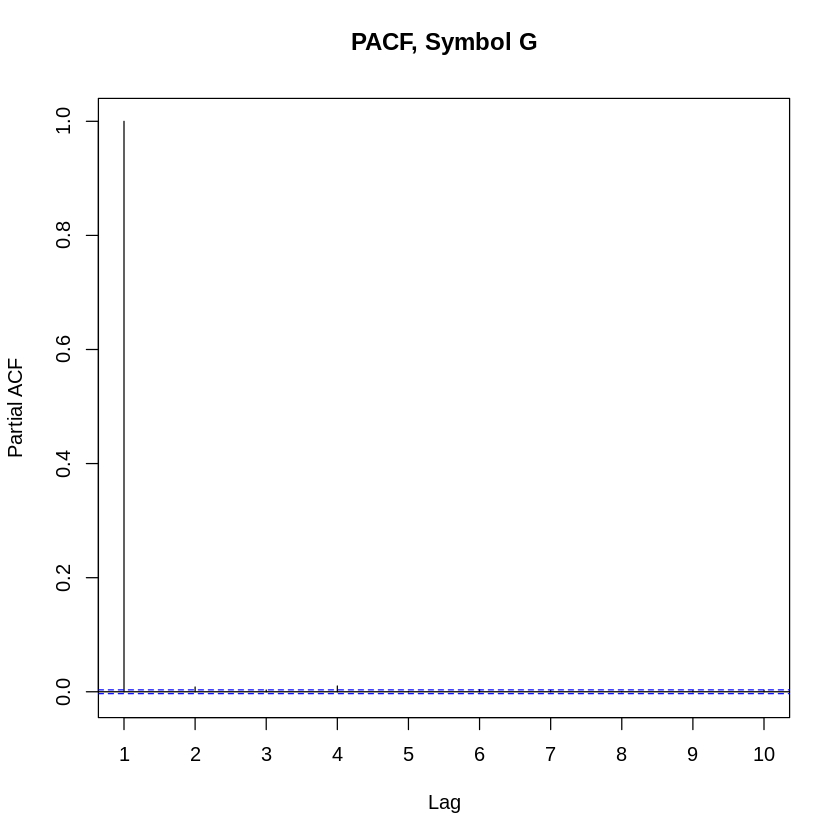

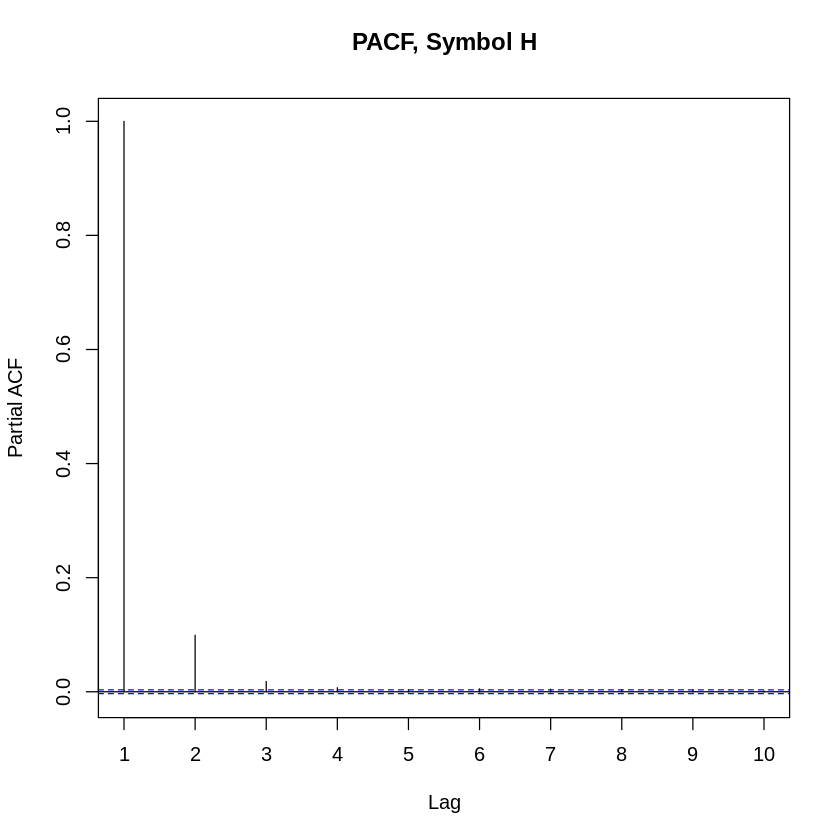

In [ ]:
# Consider sample PACF (partial auto correlation) to estimate the AR order p
# https://www.rdocumentation.org/packages/forecast/versions/8.15/topics/Acf

# Ticker G: PACF plot
Pacf(log(df_with_miss$open[df_with_miss$symbol=="G" & df_with_miss$set=="train"]), 
     lag.max = 10, main="PACF, Symbol G")


# Ticker H: PACF plot
Pacf(log(df_with_miss$open[df_with_miss$symbol=="H" & df_with_miss$set=="train"]), 
     lag.max = 10, main="PACF, Symbol H")


For ticker G, the PACF cuts off after 1 lag. For ticker H, the PACF cuts off after 2 or 3 lags. So we may find that a smaller value of p would work for both tickers (https://rpubs.com/riazakhan94/arima_with_example).

Let's test values of p, d, and q between 0 and 2 and identify the parameters that yield the lowest squared error on the development set. (We attempted to include 3 as a possible parameter value as well, but doing so yielded some errors.)

In [ ]:
# https://people.duke.edu/~rnau/411arim.htm

# Ticker G

# Test the squared error on the dev set of a variety of different parameters for
# p, d, and q.
# Initialize vector to hold the squared error between actual and predicted
err_g <- c()
for(i in 0:2){
  for (j in 0:2) {
    for (k in 0:2){
      arima_g_model_dev <- arima(log(df_with_miss$open[df_with_miss$symbol=="G" 
                    & df_with_miss$set=="train"]), order=c(i,j,k))
      forecast_arima_g_dev <- as.data.frame(predict(arima_g_model_dev, 9*5040))
      err_dev <- sum((forecast_arima_g_dev$pred - 
      log(df_with_miss$open[df_with_miss$symbol=="G" & df_with_miss$set=="dev"]))^2)
      err_g <- append(err_g, err_dev)
      print(paste("error for p = ", i, ", d = ", j, ", q = ", k, ": ", err_dev))
    }
  }
}

# Find the p, d, and q that give the smallest error.
which(err_g==min(err_g))
which.min(err_g)


[1] "error for p =  0 , d =  0 , q =  0 :  114.415904977651"
[1] "error for p =  0 , d =  0 , q =  1 :  114.415538632082"
[1] "error for p =  0 , d =  0 , q =  2 :  114.413985653333"
[1] "error for p =  0 , d =  1 , q =  0 :  200.965760086424"
[1] "error for p =  0 , d =  1 , q =  1 :  200.990126007562"
[1] "error for p =  0 , d =  1 , q =  2 :  201.004946788757"
[1] "error for p =  0 , d =  2 , q =  0 :  1493508.6513898"
[1] "error for p =  0 , d =  2 , q =  1 :  244.587057984429"
[1] "error for p =  0 , d =  2 , q =  2 :  222.543472354812"
[1] "error for p =  1 , d =  0 , q =  0 :  147.67393415034"
[1] "error for p =  1 , d =  0 , q =  1 :  148.204073673634"
[1] "error for p =  1 , d =  0 , q =  2 :  148.420724233075"
[1] "error for p =  1 , d =  1 , q =  0 :  200.989038447184"
[1] "error for p =  1 , d =  1 , q =  1 :  200.989599287653"
[1] "error for p =  1 , d =  1 , q =  2 :  201.004237347107"
[1] "error for p =  1 , d =  2 , q =  0 :  1028867.82550647"
[1] "error for p =  1 , d 

[1] 3

[1] 3

For ticker G, using parameters p=0, d=0, q=2 gives the lowest error on the development set. But the parameters p=0, d=0, q=0 give a very similar error, suggesting that ARIMA may not be a useful model for this ticker. Let's go with p=0, d=0, q=0 for parsimony and see what the plot looks like. This is a pure white noise model (https://stats.stackexchange.com/questions/236566/how-to-interpret-arima0-0-0).


In [ ]:
# Ticker H

# Test the squared error on the dev set of a variety of different parameters for
# p, d, and q.
# Initialize vector to hold the squared error between actual and predicted
err_h <- c()
for(i in 0:2){
  for (j in 0:2) {
    for (k in 0:2){
      arima_h_model_dev <- arima(log(df_with_miss$open[df_with_miss$symbol=="H" 
                    & df_with_miss$set=="train"]), order=c(i,j,k))
      forecast_arima_h_dev <- as.data.frame(predict(arima_h_model_dev, 9*5040))
      err_dev <- sum((forecast_arima_h_dev$pred - 
      log(df_with_miss$open[df_with_miss$symbol=="H" & df_with_miss$set=="dev"]))^2)
      err_h <- append(err_h, err_dev)
      print(paste("error for p = ", i, ", d = ", j, ", q = ", k, ": ", err_dev))
    }
  }
}

# Find the p, d, and q that give the smallest error.
which(err_h==min(err_h))
which.min(err_h)


[1] "error for p =  0 , d =  0 , q =  0 :  240.03795089537"
[1] "error for p =  0 , d =  0 , q =  1 :  240.037566798585"
[1] "error for p =  0 , d =  0 , q =  2 :  240.037237188601"
[1] "error for p =  0 , d =  1 , q =  0 :  116.327975760462"
[1] "error for p =  0 , d =  1 , q =  1 :  116.387022037818"
[1] "error for p =  0 , d =  1 , q =  2 :  116.399824629816"
[1] "error for p =  0 , d =  2 , q =  0 :  401600.913553209"
[1] "error for p =  0 , d =  2 , q =  1 :  109.113589870617"
[1] "error for p =  0 , d =  2 , q =  2 :  108.993866740029"
[1] "error for p =  1 , d =  0 , q =  0 :  201.826048633398"
[1] "error for p =  1 , d =  0 , q =  1 :  192.112949214663"
[1] "error for p =  1 , d =  0 , q =  2 :  190.058097099787"
[1] "error for p =  1 , d =  1 , q =  0 :  116.370298812977"
[1] "error for p =  1 , d =  1 , q =  1 :  116.402837763133"
[1] "error for p =  1 , d =  1 , q =  2 :  116.398705837574"
[1] "error for p =  1 , d =  2 , q =  0 :  741101.41108902"
[1] "error for p =  1 , d 

[1] 9

[1] 9

The movement of ticker H's open prices are erratic, with a steep drop near the end of the training period. The lowest squared error on the development set is achieved with p=0,d=2,q=2. But the predictions using those parameters still did not look reasonable, displaying a stairstep pattern. The error on the p=0,d=1,q=0 model is similar, and the predictions seem more reasonable. We will go with these parameters.


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "G" & df_with_miss$set != 
    "test"]), order = c(0, 0, 0))

Coefficients:
      intercept
         5.1718
s.e.     0.0001

sigma^2 estimated as 0.001572:  log likelihood = 711100.2,  aic = -1422196


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "H" & df_with_miss$set != 
    "test"]), order = c(0, 1, 0))


sigma^2 estimated as 2.859e-08:  log likelihood = 2856479,  aic = -5712957

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



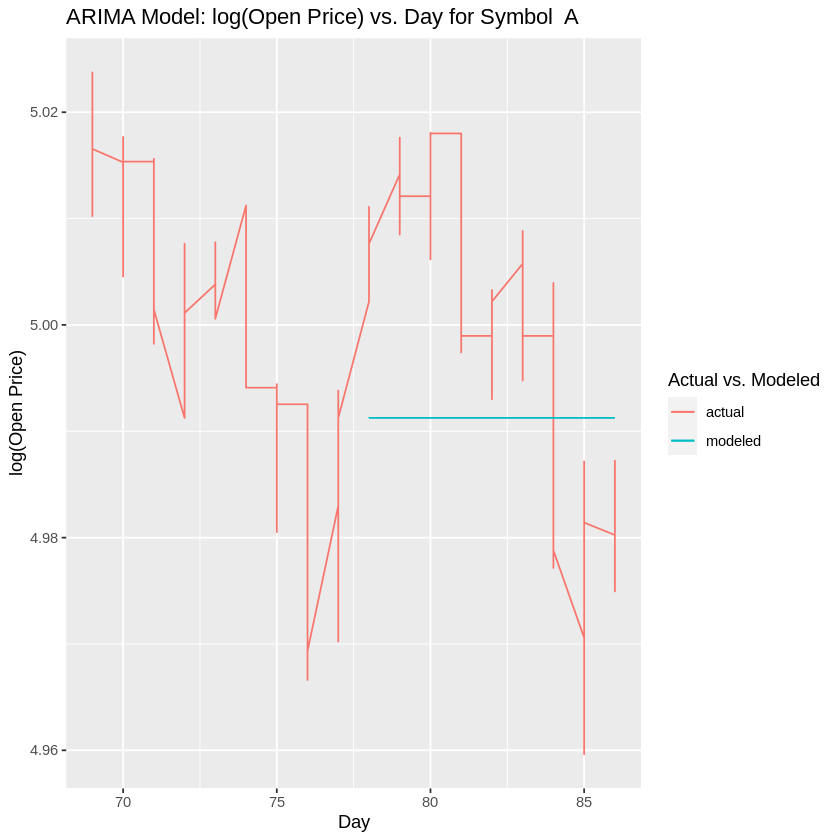

Saving 6.67 x 6.67 in image



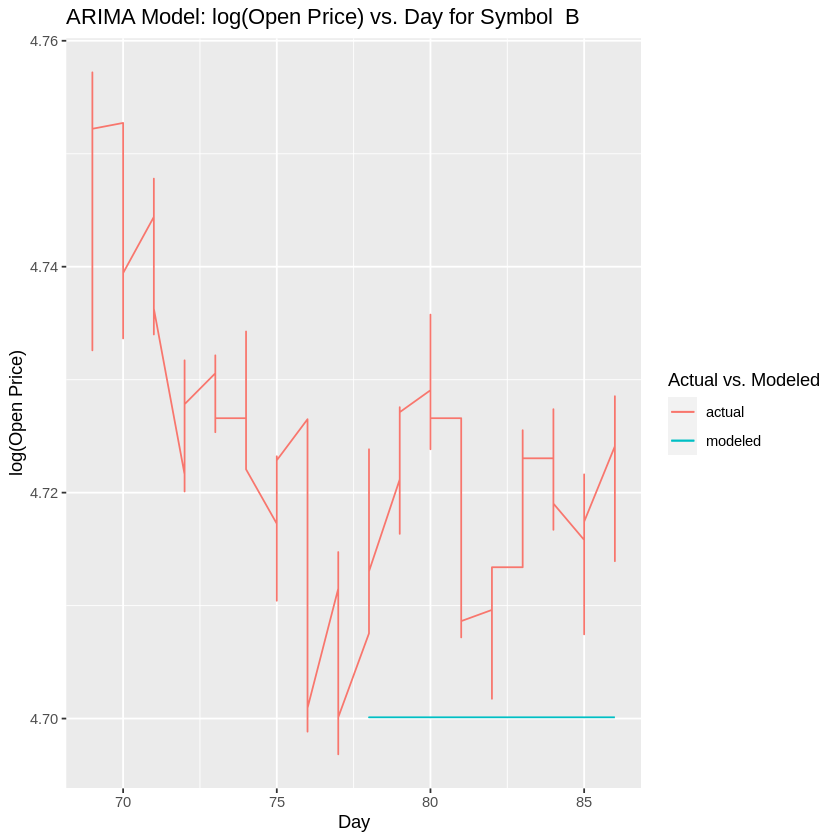

Saving 6.67 x 6.67 in image



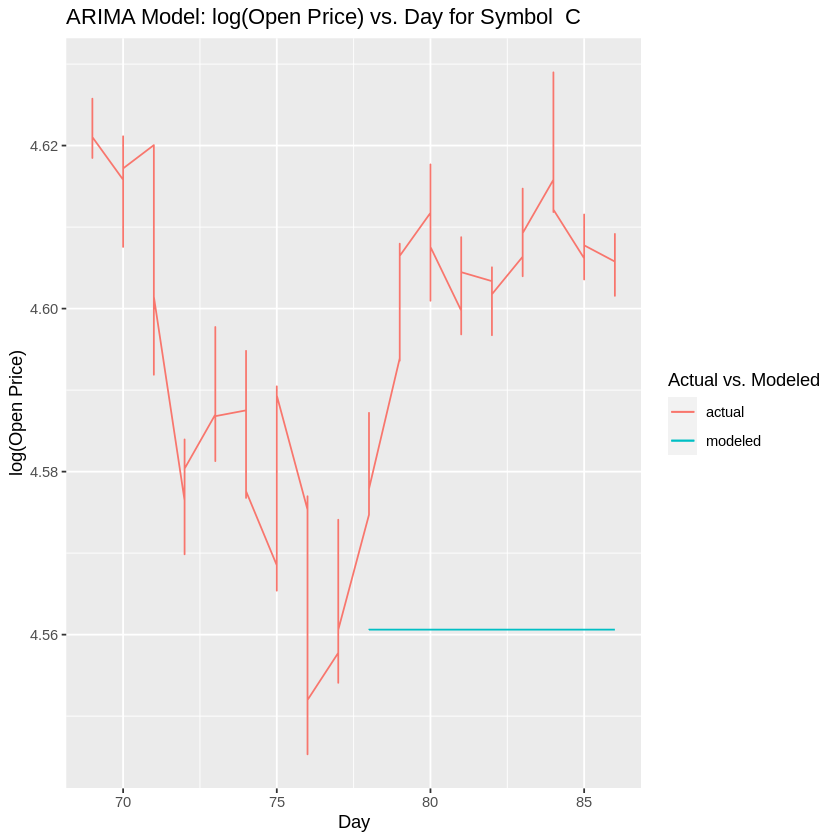

Saving 6.67 x 6.67 in image



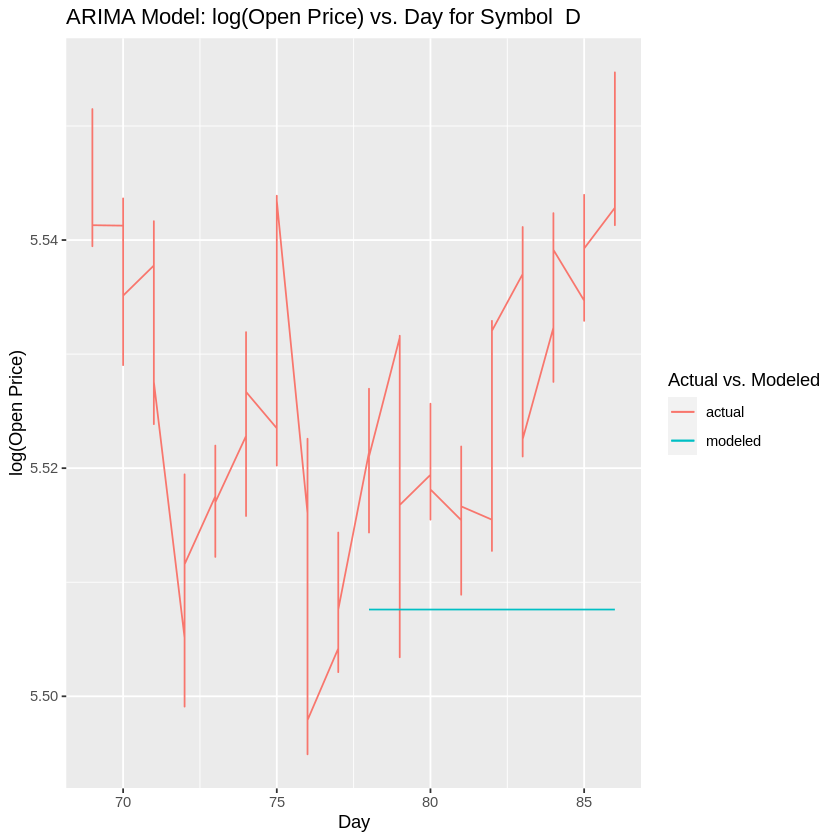

Saving 6.67 x 6.67 in image



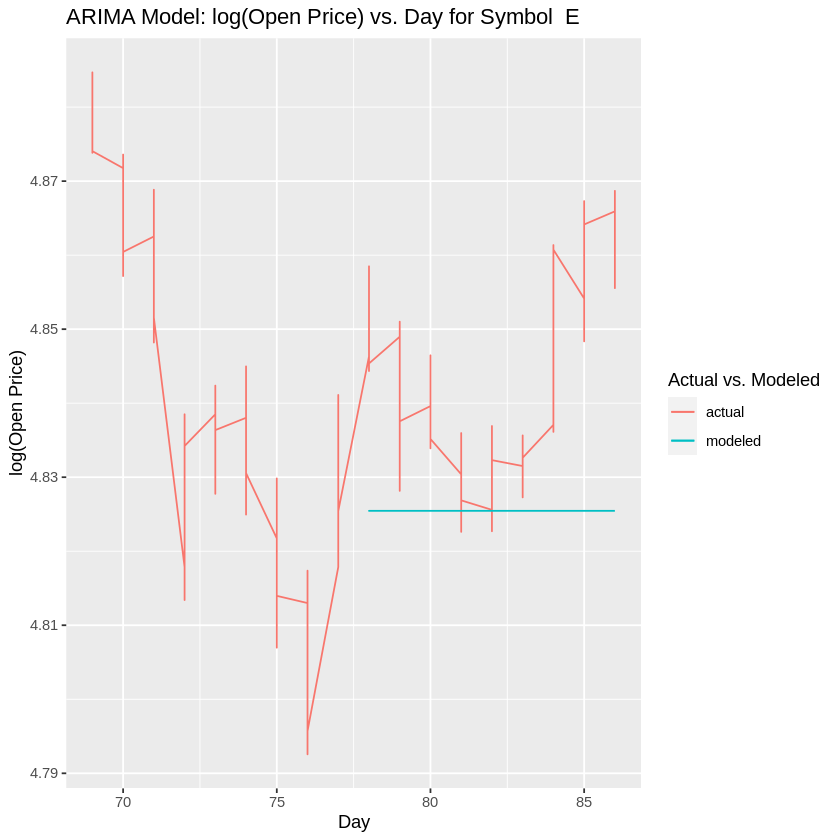

Saving 6.67 x 6.67 in image



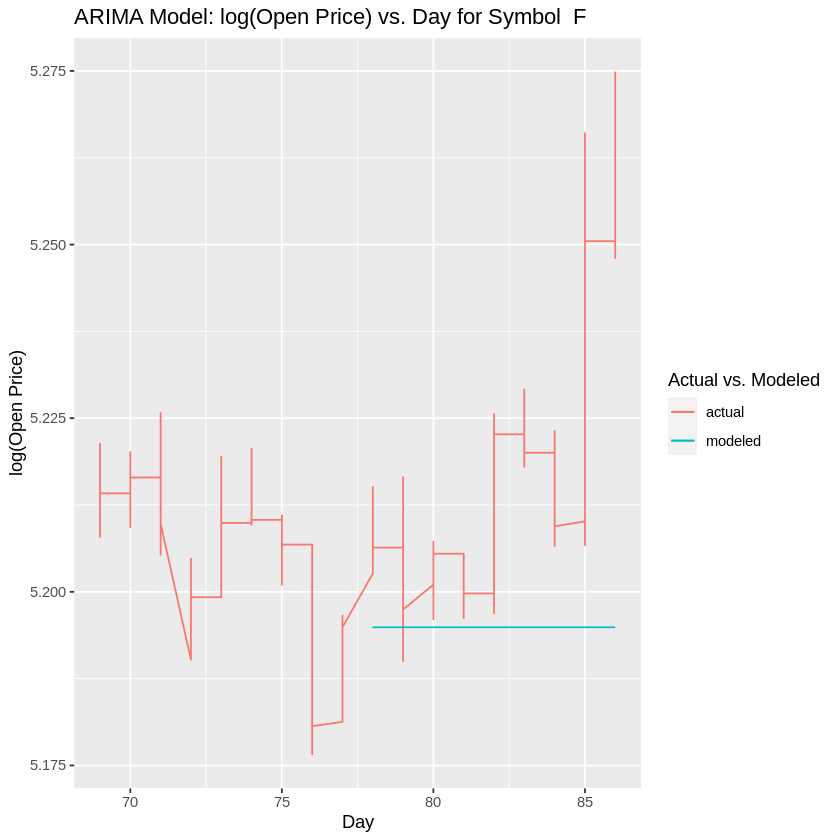

Saving 6.67 x 6.67 in image



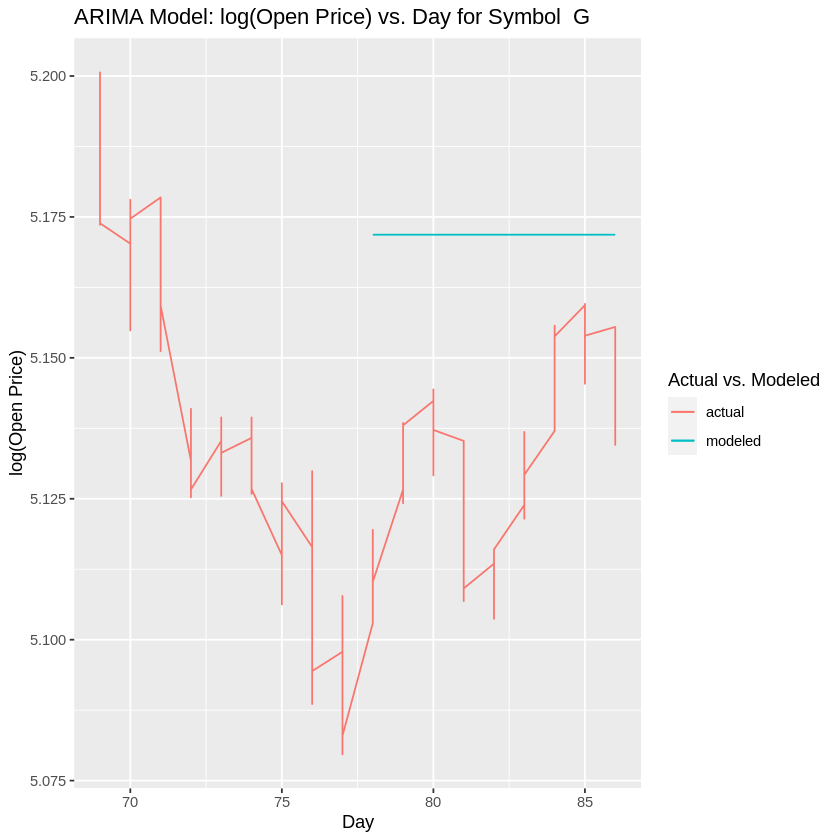

Saving 6.67 x 6.67 in image



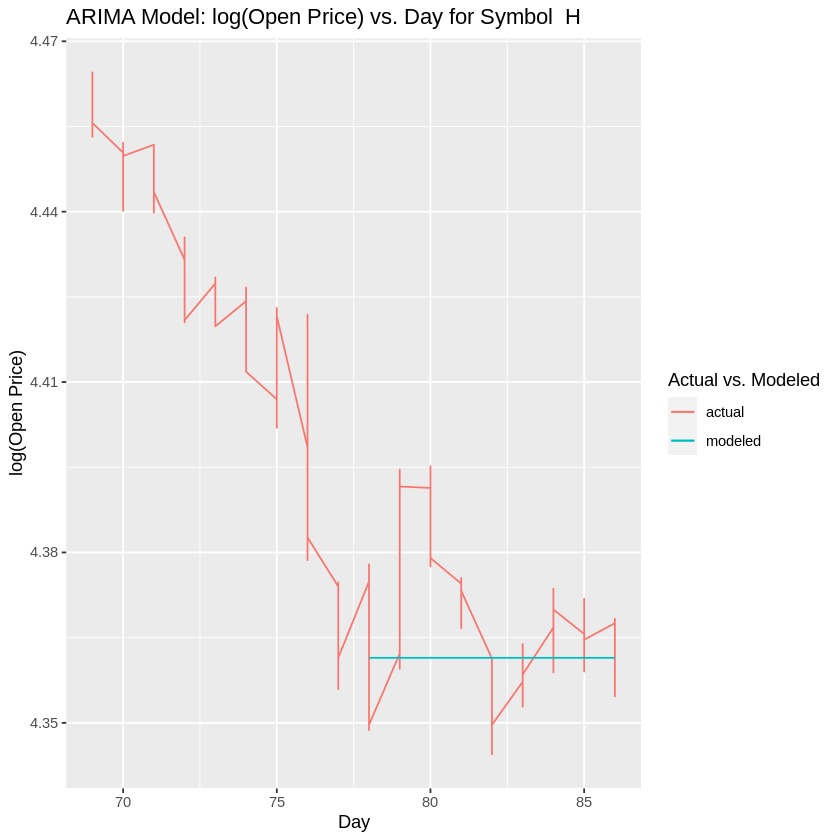

Saving 6.67 x 6.67 in image



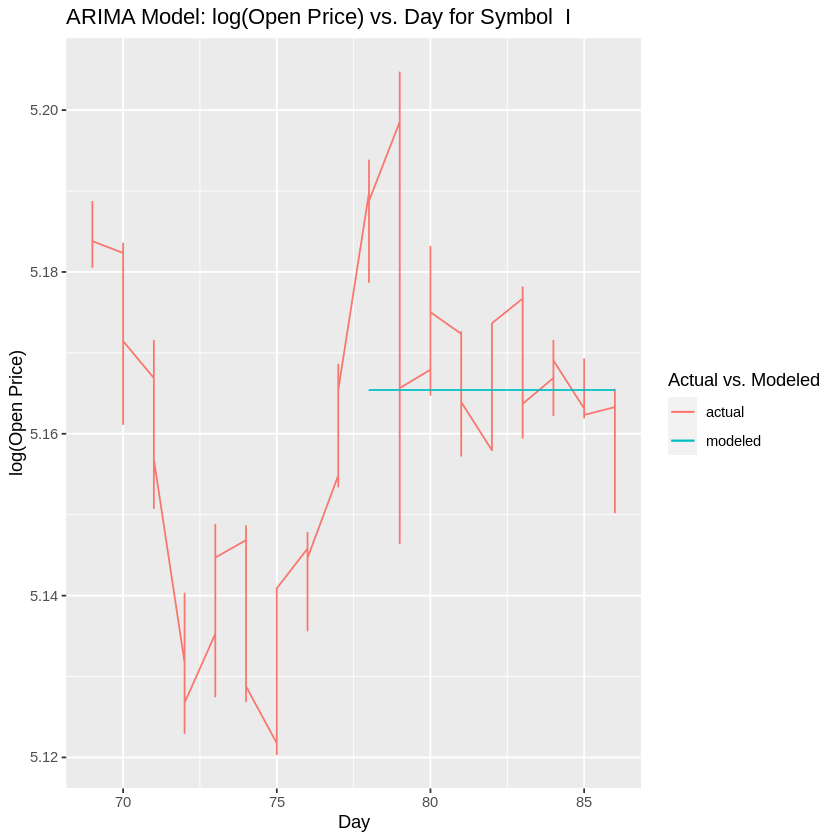

[1] 213.0638

[1] 286.8374

symbol total     
1  A       205804.37
2  B       220317.75
3  C       855252.91
4  D      1657217.62
5  E       356974.37
6  F      1815710.80
7  G      2453759.54
8  H        43803.85
9  I       142391.37
10 J      3772437.29

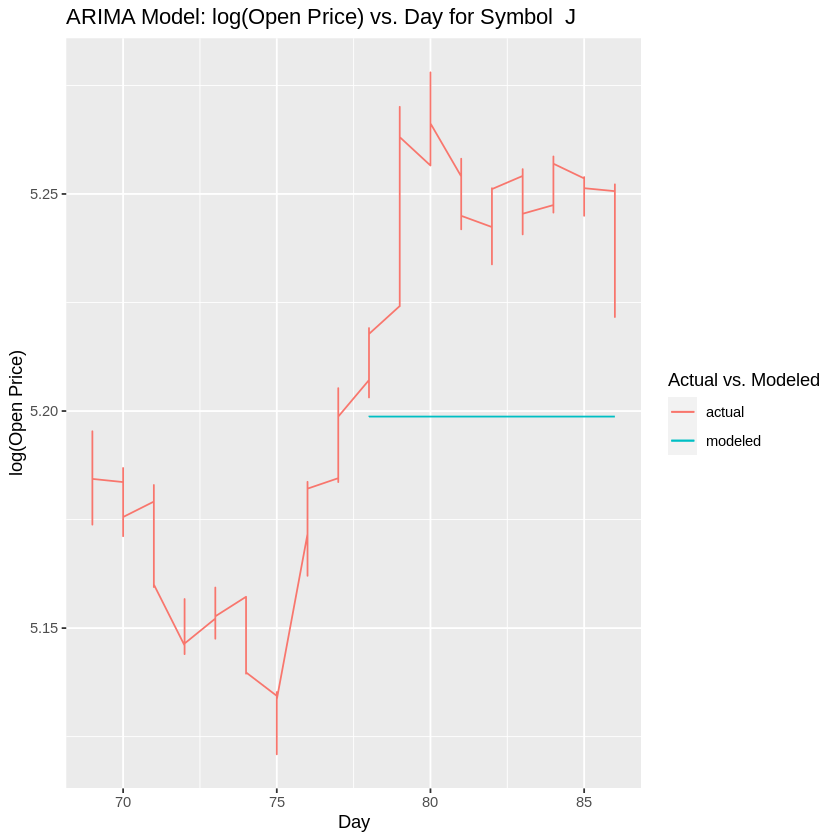

In [ ]:
# Refit G and H with the revised parameters and forecast for the test period

# Ticker G

arima_g_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="G" 
                          & df_with_miss$set!="test"]), order=c(0,0,0))
arima_g_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_g <- as.data.frame(predict(arima_g_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("G", 9*5040)
t <- sort(t)
d <- as.integer(rep(78:86, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_g <- cbind.data.frame(t, d, s, forecast_arima_g$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="G" & df_with_miss$set=="test"]))
colnames(arima_g) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_g$squared_error <- (exp(arima_g$arima_pred) - exp(arima_g$test_actual))^2

# Ticker H
arima_h_model <- arima(log(df_with_miss$open[df_with_miss$symbol=="H" 
                            & df_with_miss$set!="test"]), order=c(0,1,0))
arima_h_model

# Forecast 9 days into the future (i.e., for the test set time period)
# https://stackoverflow.com/questions/31928021/returning-predicted-values-of-
# a-forecasting-model-as-a-matrix
forecast_arima_h <- as.data.frame(predict(arima_h_model, 9*5040))

# Make a data frame with the predicted and actual results on the test set
t <- rep("H", 9*5040)
t <- sort(t)
d <- as.integer(rep(78:86, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_h <- cbind.data.frame(t, d, s, forecast_arima_h$pred, 
    log(df_with_miss$open[df_with_miss$symbol=="H" & df_with_miss$set=="test"]))
colnames(arima_h) <- c("symbol", "day", "time", "arima_pred", "test_actual")

# Add column with squared error
arima_h$squared_error <- (exp(arima_h$arima_pred) - exp(arima_h$test_actual))^2

# Change the prediction and squared error values from class ts to class numeric
arima_g$arima_pred <- as.numeric(arima_g$arima_pred)
arima_g$squared_error <- as.numeric(arima_g$squared_error)
arima_h$arima_pred <- as.numeric(arima_h$arima_pred)
arima_h$squared_error <- as.numeric(arima_h$squared_error)


# Bind arima dfs by ticker into one data frame, using the revised G and H models
arima_df <- rbind.data.frame(arima_a, arima_b, arima_c, arima_d, arima_e,
                             arima_f, arima_g, arima_h, arima_i, arima_j)

# Add time to big data frame, which may be missing this element for intervals
# with missing values
s2 <- unique(df_with_miss$time)
s2 <- sort(s2)
s2 <- rep(s2, 10*87)
df_with_miss$time <- s2 

# Plot actual vs. predicted by ticker
for(i in tickers) {
  myplot <-
  ggplot() +
  geom_line(data = filter(df_with_miss, symbol==i, day > 68),
            aes(x = day, y = log(open), color = "actual")) +
  geom_line(data = filter(arima_df, symbol==i, day > 77),
            aes(x = day, y = arima_pred, color = "modeled")) +
  xlab("Day") +
  ylab("log(Open Price)") +
  guides(col = guide_legend(title = "Actual vs. Modeled")) +
  ggtitle(paste('ARIMA Model: log(Open Price) vs. Day for Symbol ', i))
  
  print(myplot)
  
  ggsave(myplot,filename=paste("arima_pred_", i ,".png",sep=""))
}

# Calculate the error on the test set, using formula on page 2 of 
# "final_project.pdf"

# Test error for days 78-81
first_error <- (1/4)*(1/5040)*(sum(arima_df$squared_error[arima_df$day < 82]))
first_error
                                        
# Test error for days 82-86
second_error <- (1/5)*(1/5040)*(sum(arima_df$squared_error[arima_df$day > 81]))
second_error

arima_df %>% 
  group_by(symbol) %>%
  summarise(total=sum(squared_error))

The squared error on the test set is largely driven by stocks D, F, G, and J. This is not surprising given the plots. The predictions for D, F, and J lie almost entirely below the actual open prices, while the predictions for stock G lie entirely above the actual.

We will now calculate predictions using ARIMA for the forecast period. Given the volatility in the predictions on the training and development set for stocks G and H, we will set the parameters of the ARIMA model to the parameters we chose by reviewing the performance on the test set. For the other stocks, we will let auto.arima() select the parameters using the full data set (train+dev+test) and review the forecasts for reasonableness.

Series: log(df_with_miss$open[df_with_miss$symbol == "A"]) 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.0295  -0.0115
s.e.   0.0015   0.0015

sigma^2 estimated as 2.619e-08:  log likelihood=3205763
AIC=-6411520   AICc=-6411520   BIC=-6411487

Series: log(df_with_miss$open[df_with_miss$symbol == "B"]) 
ARIMA(3,1,0) 

Coefficients:
          ar1      ar2     ar3
      -0.0471  -0.0131  0.0032
s.e.   0.0015   0.0015  0.0015

sigma^2 estimated as 2.995e-08:  log likelihood=3176231
AIC=-6352454   AICc=-6352454   BIC=-6352410

Series: log(df_with_miss$open[df_with_miss$symbol == "C"]) 
ARIMA(0,1,5) 

Coefficients:
          ma1      ma2      ma3      ma4      ma5
      -0.0261  -0.0110  -0.0036  -0.0045  -0.0084
s.e.   0.0015   0.0015   0.0015   0.0015   0.0015

sigma^2 estimated as 3.348e-08:  log likelihood=3151732
AIC=-6303453   AICc=-6303453   BIC=-6303387

Series: log(df_with_miss$open[df_with_miss$symbol == "D"]) 
ARIMA(0,1,0) with drift 

Coefficients:
      drift
          0
s.e.      0

sigma^2 estimated as 2.551e-08:  log likelihood=3211616
AIC=-6423227   AICc=-6423227   BIC=-6423205

Series: log(df_with_miss$open[df_with_miss$symbol == "D"]) 
ARIMA(0,1,0) with drift 

Coefficients:
      drift
          0
s.e.      0

sigma^2 estimated as 2.551e-08:  log likelihood=3211616
AIC=-6423227   AICc=-6423227   BIC=-6423205

Series: log(df_with_miss$open[df_with_miss$symbol == "E"]) 
ARIMA(0,1,3) 

Coefficients:
          ma1      ma2     ma3
      -0.0236  -0.0451  0.0032
s.e.   0.0015   0.0015  0.0015

sigma^2 estimated as 3.089e-08:  log likelihood=3169494
AIC=-6338979   AICc=-6338979   BIC=-6338935

Series: log(df_with_miss$open[df_with_miss$symbol == "F"]) 
ARIMA(0,1,2) with drift 

Coefficients:
          ma1      ma2  drift
      -0.0367  -0.0056      0
s.e.   0.0015   0.0015      0

sigma^2 estimated as 3.283e-08:  log likelihood=3156174
AIC=-6312340   AICc=-6312340   BIC=-6312297

Series: log(df_with_miss$open[df_with_miss$symbol == "F"]) 
ARIMA(0,1,2) with drift 

Coefficients:
          ma1      ma2  drift
      -0.0367  -0.0056      0
s.e.   0.0015   0.0015      0

sigma^2 estimated as 3.283e-08:  log likelihood=3156174
AIC=-6312340   AICc=-6312340   BIC=-6312297


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "G"]), order = c(0, 0, 
    0))

Coefficients:
      intercept
         5.1677
s.e.     0.0001

sigma^2 estimated as 0.001581:  log likelihood = 791817.4,  aic = -1583631


Call:
arima(x = log(df_with_miss$open[df_with_miss$symbol == "H"]), order = c(0, 1, 
    0))


sigma^2 estimated as 2.994e-08:  log likelihood = 3175923,  aic = -6351845

Series: log(df_with_miss$open[df_with_miss$symbol == "I"]) 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.0308  -0.0040
s.e.   0.0015   0.0015

sigma^2 estimated as 3.991e-08:  log likelihood=3113234
AIC=-6226462   AICc=-6226462   BIC=-6226429

Series: log(df_with_miss$open[df_with_miss$symbol == "J"]) 
ARIMA(0,1,3) 

Coefficients:
          ma1      ma2      ma3
      -0.0207  -0.0035  -0.0032
s.e.   0.0015   0.0015   0.0015

sigma^2 estimated as 3.898e-08:  log likelihood=3118471
AIC=-6236934   AICc=-6236934   BIC=-6236890

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



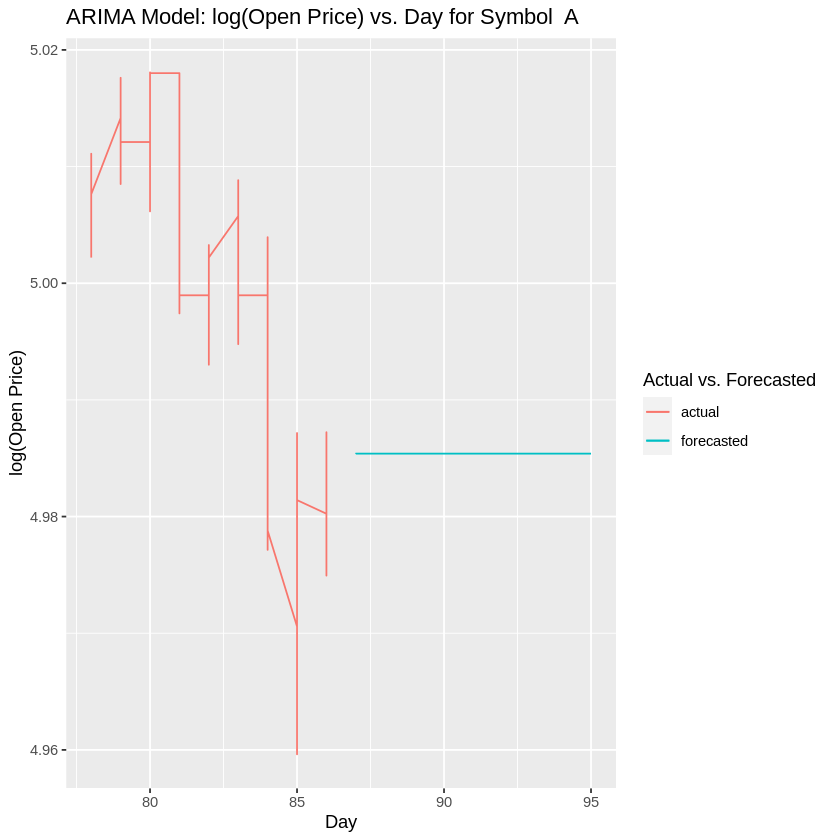

Saving 6.67 x 6.67 in image



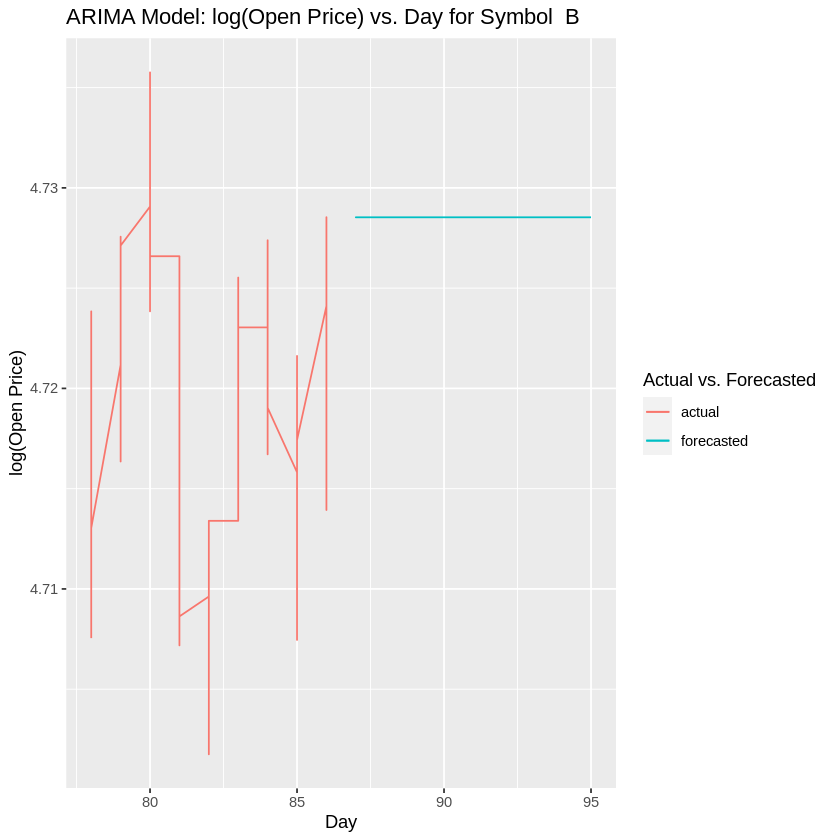

Saving 6.67 x 6.67 in image



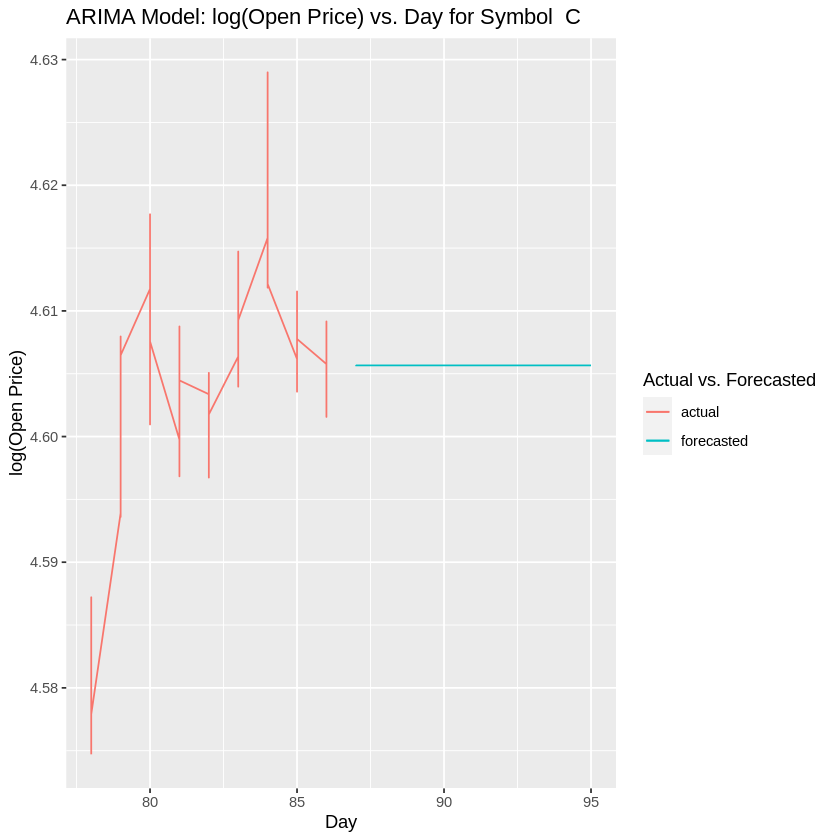

Saving 6.67 x 6.67 in image



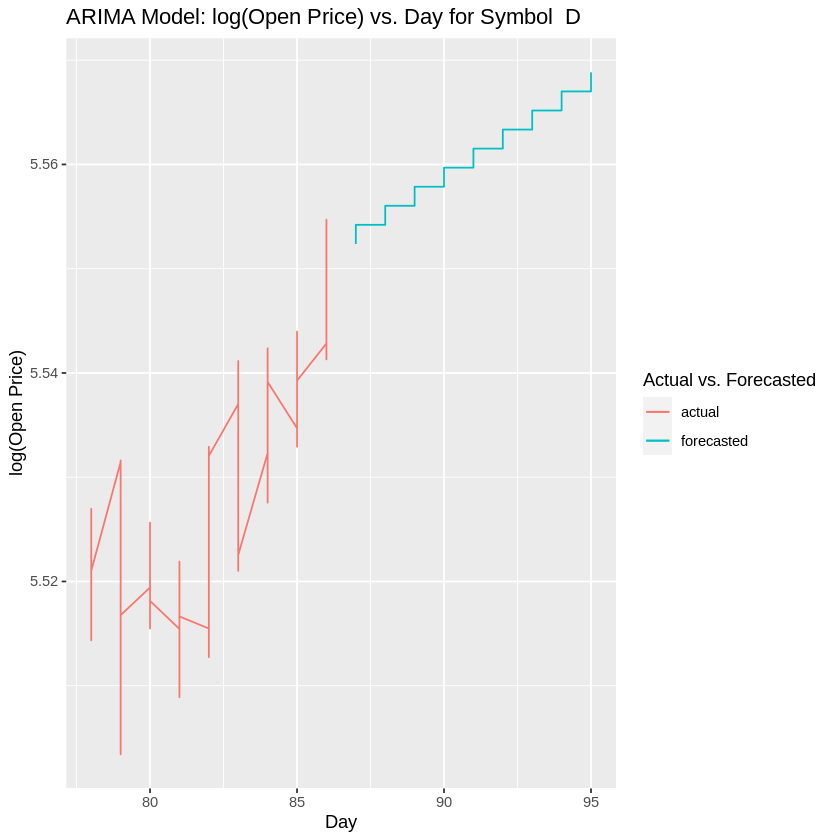

Saving 6.67 x 6.67 in image



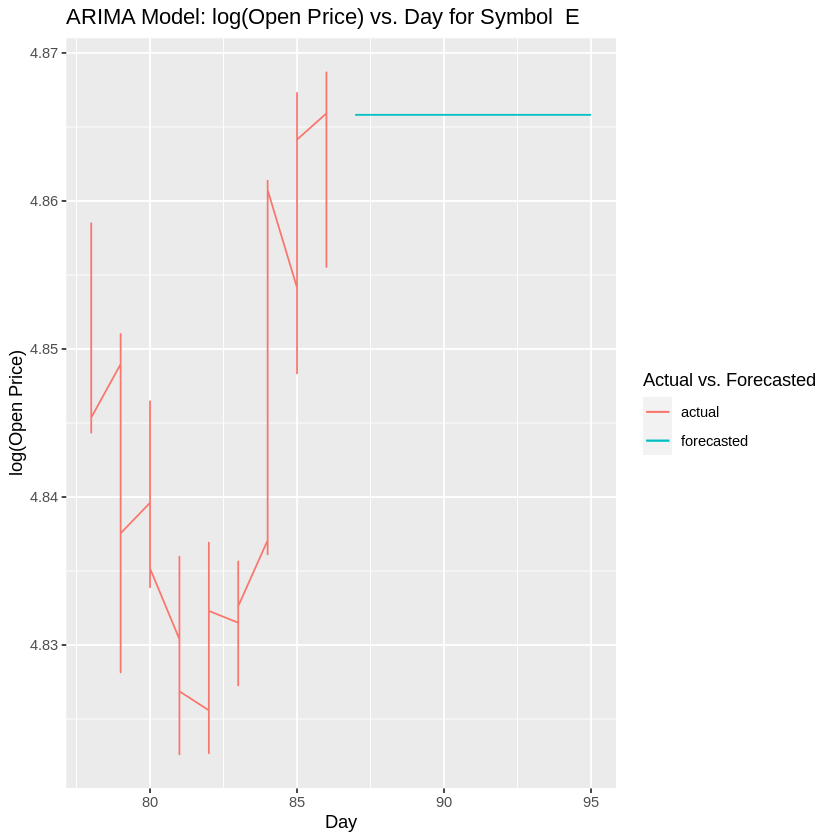

Saving 6.67 x 6.67 in image



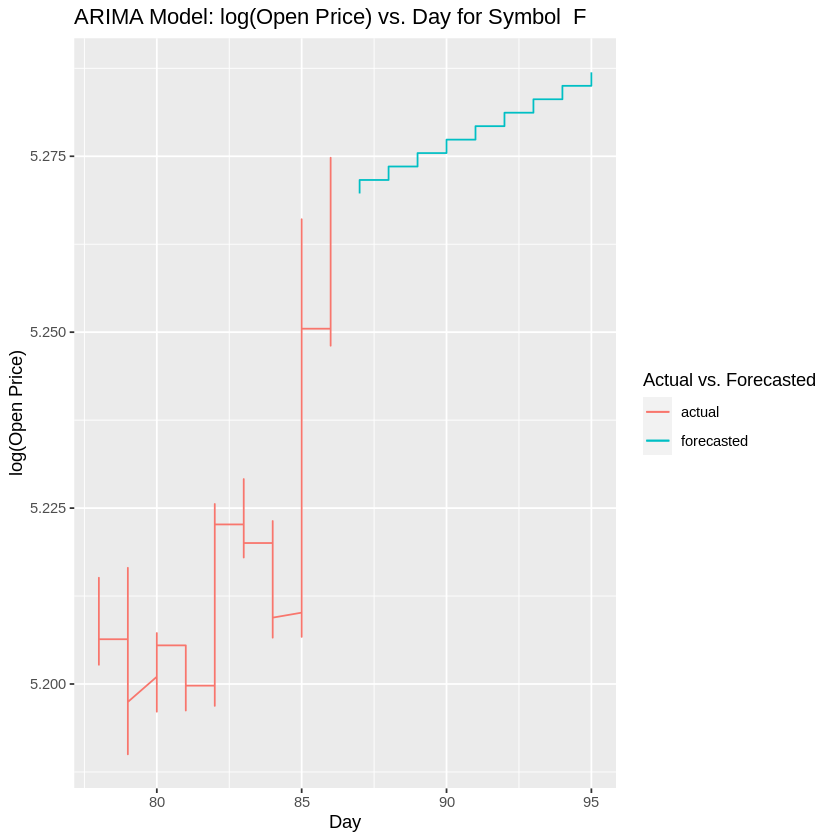

Saving 6.67 x 6.67 in image



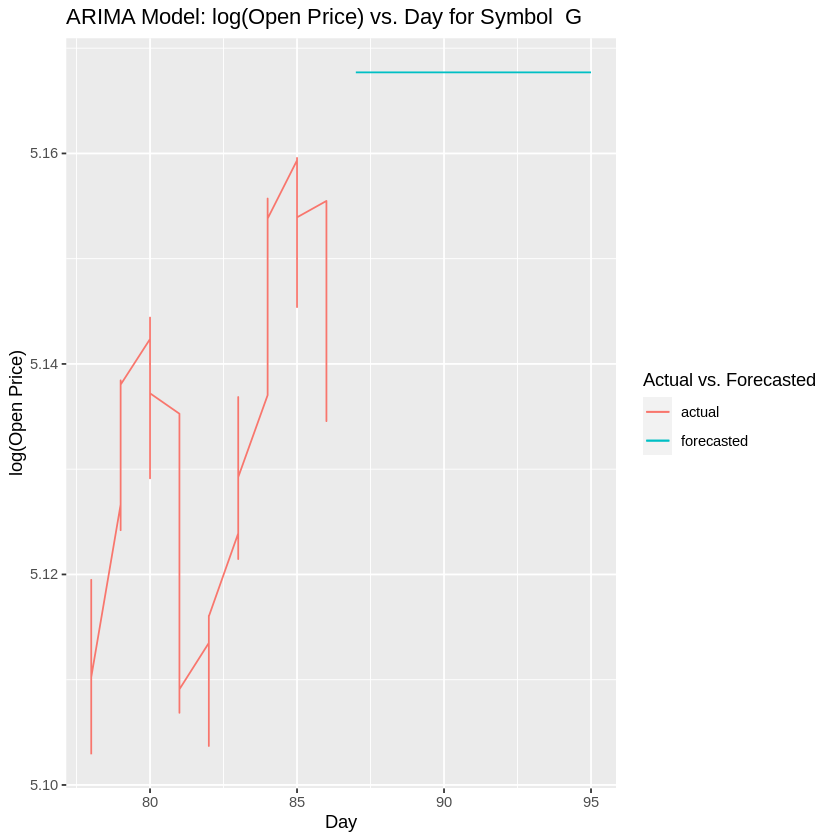

Saving 6.67 x 6.67 in image



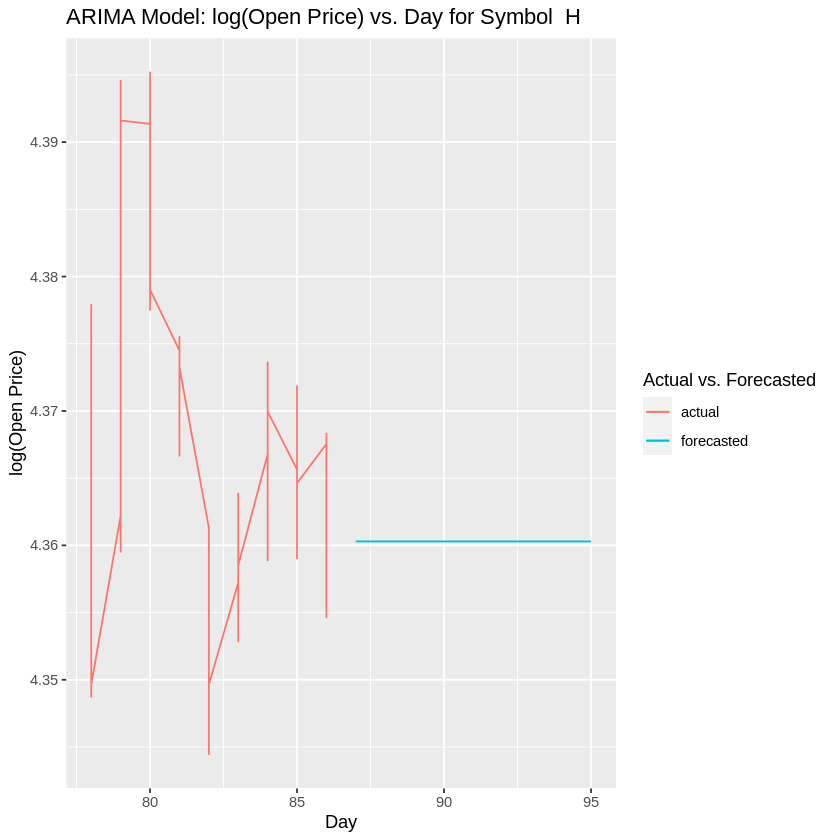

Saving 6.67 x 6.67 in image



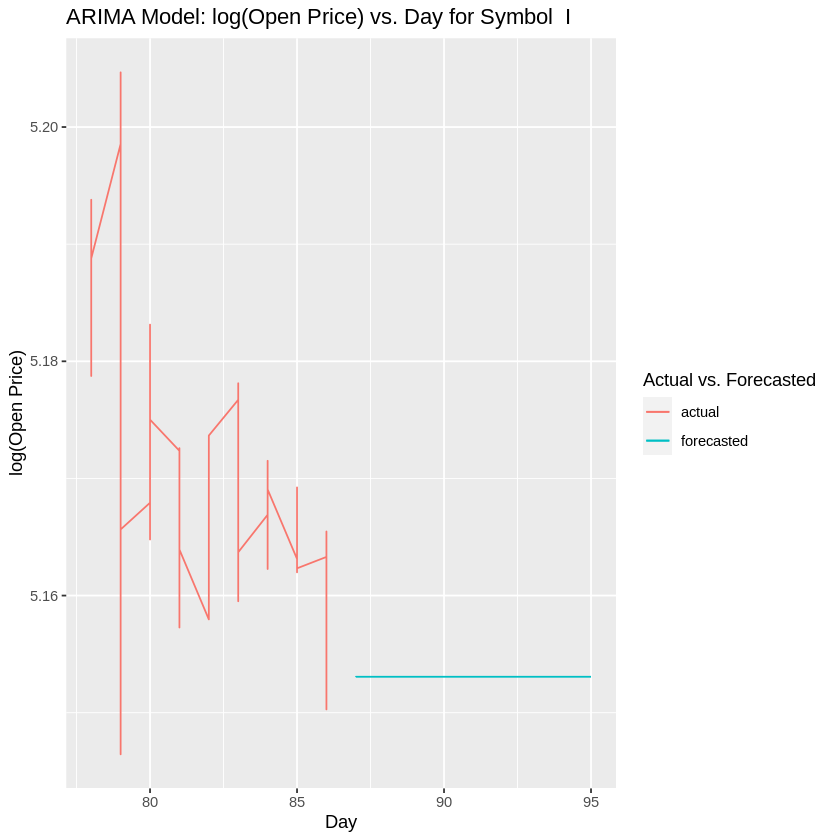

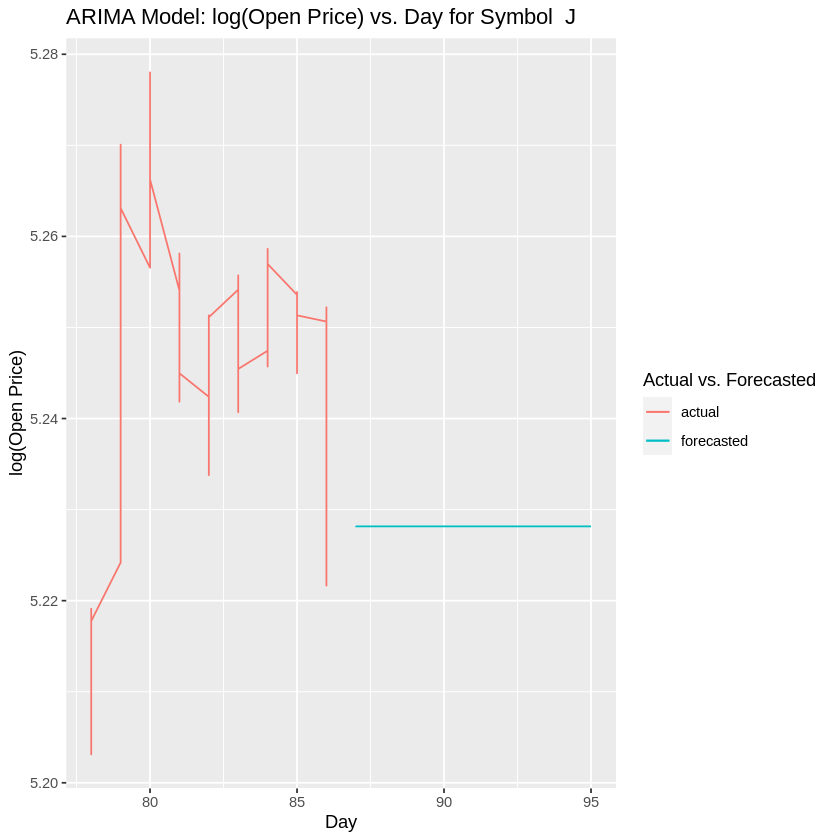

In [ ]:
# Forecasts

# Ticker A

arima_a_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="A"]))
arima_a_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_a <- as.data.frame(predict(arima_a_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("A", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_a_fore <- cbind.data.frame(t, d, s, fore_arima_a$pred)
colnames(arima_a_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker B

arima_b_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="B"]))
arima_b_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_b <- as.data.frame(predict(arima_b_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("B", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_b_fore <- cbind.data.frame(t, d, s, fore_arima_b$pred)
colnames(arima_b_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker C

arima_c_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="C"]))
arima_c_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_c <- as.data.frame(predict(arima_c_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("C", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_c_fore <- cbind.data.frame(t, d, s, fore_arima_c$pred)
colnames(arima_c_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker D

arima_d_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="D"]))
arima_d_fore

# Model is estimated to be ARIMA(0,1,0) with drift. Use Arima() in the 
# forecast library to predict.
# https://stats.stackexchange.com/questions/26926/fitting-arima-with-a-drift-on-r

arima_d_fore <- Arima(log(df_with_miss$open[df_with_miss$symbol=="D"]),
                               order=c(0,1,0), include.drift=TRUE)
arima_d_fore

# Forecast 9 days into the future (days 87-95)
# https://cran.r-project.org/web/packages/forecast/forecast.pdf
fore_arima_d <- as.data.frame(forecast::forecast(arima_d_fore, h=9*5040))

# Make a data frame with the forecasted values
t <- rep("D", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_d_fore <- cbind.data.frame(t, d, s, fore_arima_d[,"Point Forecast"])
colnames(arima_d_fore) <- c("symbol", "day", "time", "log_arima_fore")


# Ticker E

arima_e_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="E"]))
arima_e_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_e <- as.data.frame(predict(arima_e_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("E", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_e_fore <- cbind.data.frame(t, d, s, fore_arima_e$pred)
colnames(arima_e_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker F

arima_f_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="F"]))
arima_f_fore

# Model is estimated to be ARIMA(0,1,2) with drift. Use Arima() in the 
# forecast library to predict.
# https://stats.stackexchange.com/questions/26926/fitting-arima-with-a-drift-on-r

arima_f_fore <- Arima(log(df_with_miss$open[df_with_miss$symbol=="F"]),
                               order=c(0,1,2), include.drift=TRUE)
arima_f_fore

# Forecast 9 days into the future (days 87-95)
# https://cran.r-project.org/web/packages/forecast/forecast.pdf
fore_arima_f <- as.data.frame(forecast::forecast(arima_f_fore, h=9*5040))

# Make a data frame with the forecasted values
t <- rep("F", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_f_fore <- cbind.data.frame(t, d, s, fore_arima_f[,"Point Forecast"])
colnames(arima_f_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker G

# Use order (0,0,0), NOT auto.arima

arima_g_fore <- arima(log(df_with_miss$open[df_with_miss$symbol=="G"]),
                      order = c(0,0,0))
arima_g_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_g <- as.data.frame(predict(arima_g_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("G", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_g_fore <- cbind.data.frame(t, d, s, fore_arima_g$pred)
colnames(arima_g_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker H

# Use order (0,1,0), NOT auto.arima

arima_h_fore <- arima(log(df_with_miss$open[df_with_miss$symbol=="H"]),
                      order = c(0,1,0))
arima_h_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_h <- as.data.frame(predict(arima_h_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("H", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_h_fore <- cbind.data.frame(t, d, s, fore_arima_h$pred)
colnames(arima_h_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker I

arima_i_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="I"]))
arima_i_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_i <- as.data.frame(predict(arima_i_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("I", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_i_fore <- cbind.data.frame(t, d, s, fore_arima_i$pred)
colnames(arima_i_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Ticker J

arima_j_fore <- auto.arima(log(df_with_miss$open[df_with_miss$symbol=="J"]))
arima_j_fore

# Forecast 9 days into the future (days 87-95)
fore_arima_j <- as.data.frame(predict(arima_j_fore, 9*5040))

# Make a data frame with the forecasted values
t <- rep("J", 9*5040)
t <- sort(t)
d <- as.integer(rep(87:95, 5040))
d <- sort(d)
s <- unique(df_with_miss$time)
s <- sort(s)
s <- rep(s, 9)
arima_j_fore <- cbind.data.frame(t, d, s, fore_arima_j$pred)
colnames(arima_j_fore) <- c("symbol", "day", "time", "log_arima_fore")

# Change the prediction and squared error values from class ts to class numeric
arima_a_fore$log_arima_fore <- as.numeric(arima_a_fore$log_arima_fore)
arima_b_fore$log_arima_fore <- as.numeric(arima_b_fore$log_arima_fore)
arima_c_fore$log_arima_fore <- as.numeric(arima_c_fore$log_arima_fore)
arima_d_fore$log_arima_fore <- as.numeric(arima_d_fore$log_arima_fore)
arima_e_fore$log_arima_fore <- as.numeric(arima_e_fore$log_arima_fore)
arima_f_fore$log_arima_fore <- as.numeric(arima_f_fore$log_arima_fore)
arima_g_fore$log_arima_fore <- as.numeric(arima_g_fore$log_arima_fore)
arima_h_fore$log_arima_fore <- as.numeric(arima_h_fore$log_arima_fore)
arima_i_fore$log_arima_fore <- as.numeric(arima_i_fore$log_arima_fore)
arima_j_fore$log_arima_fore <- as.numeric(arima_j_fore$log_arima_fore)


# Bind arima dfs by ticker into one data frame
arima_df_fore <- rbind.data.frame(arima_a_fore, arima_b_fore, arima_c_fore, 
                                  arima_d_fore, arima_e_fore, arima_f_fore, 
                                  arima_g_fore, arima_h_fore, arima_i_fore, 
                                  arima_j_fore)

# Plot forecasts by ticker
for(i in tickers){
  myplot <-
  ggplot() +
  geom_line(data = filter(df_with_miss, symbol==i, day > 77),
            aes(x = day, y = log(open), color = "actual")) +
  geom_line(data = filter(arima_df_fore, symbol==i, day > 86),
            aes(x = day, y = log_arima_fore, color = "forecasted")) +
  xlab("Day") +
  ylab("log(Open Price)") +
  guides(col = guide_legend(title = "Actual vs. Forecasted")) +
  ggtitle(paste('ARIMA Model: log(Open Price) vs. Day for Symbol ', i))
  
  print(myplot)
  
  ggsave(myplot,filename=paste("arima_forecast_", i ,".png",sep=""))
}

Plot D and F's open prices over time to see if a drift component in ARIMA seems reasonable.


Saving 6.67 x 6.67 in image



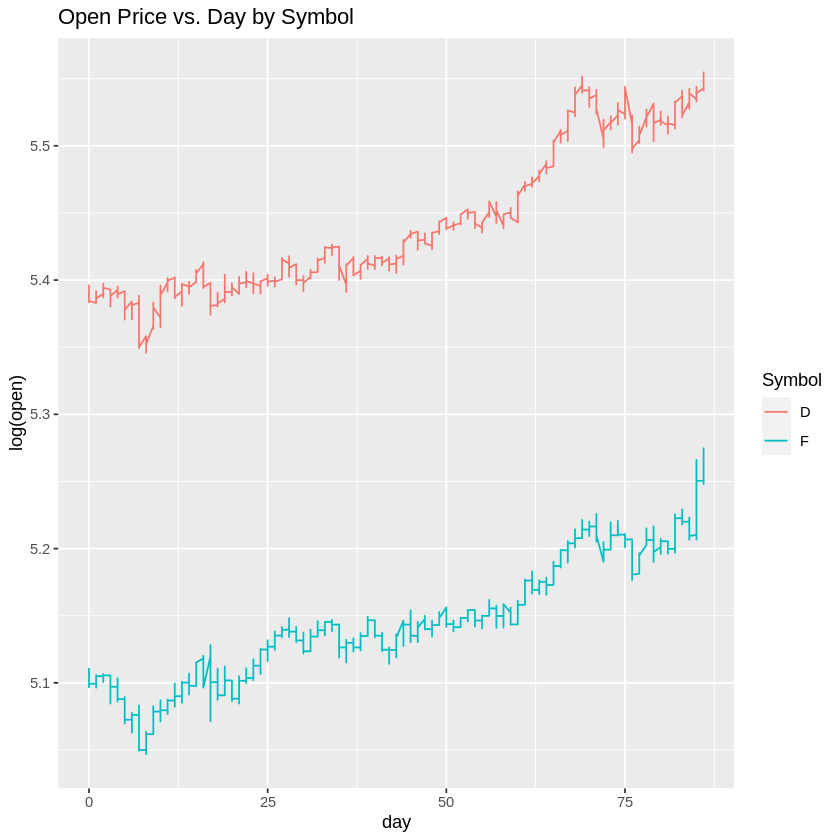

In [ ]:
ggplot(data = filter(df_with_miss, symbol=="D" | symbol=="F"),
aes(x = day, y = log(open), colour = symbol)) +
geom_line() + 
guides(col = guide_legend(title = "Symbol")) +
ggtitle('Open Price vs. Day by Symbol')

ggsave("drift_df.png")

# Forecast ML

### Models and Predictions Setup

Code for training models and predictions

In [ ]:
model_functions <- hash()

# lasso
# cite from forecastML package documentation https://cran.r-project.org/web/packages/forecastML/vignettes/package_overview.html
model_functions['lasso'] <- function(data, outcome_col = 1) {
  data <- na.omit(data)
  constant_features <-
    which(unlist(lapply(data[, -1], function(x) {
      !(length(unique(x)) > 1)
    })))
  
  if (length(constant_features) > 1) {
    data <-
      data[, -c(constant_features + 1)]  # +1 because we're skipping over the outcome column.
  }
  
  x <- data[, -(1), drop = FALSE]
  y <- data[, 1, drop = FALSE]
  x <- as.matrix(x, ncol = ncol(x))
  y <- as.matrix(y, ncol = ncol(y))
  
  model <- glmnet::cv.glmnet(x, y, nfolds = 3)
  return(list("model" = model, "constant_features" = constant_features))
}

# randomForest
# cite from forecastML package documentation https://cran.r-project.org/web/packages/forecastML/vignettes/package_overview.html
model_functions['rf'] <- function(data, outcome_col = 1) {
  # randomForest
  outcome_names <- names(data)[outcome_col]
  model_formula <- formula(paste0(outcome_names,  "~ ."))
  
  model <-
    randomForest::randomForest(
      formula = model_formula,
      data = data,
      ntree = 10,
      na.action = na.exclude
    )
  
  return(model)
}

# xgboost
# cite from forecastML package documentation: https://cran.r-project.org/web/packages/forecastML/vignettes/grouped_forecast.html
model_functions['xgboost'] <- function(data, outcome_col = 1) {
  # xgboost cannot handle missing outcomes data.
  data <- data[!is.na(data[, outcome_col]), ]
  
  indices <- 1:nrow(data)
  
  set.seed(224)
  train_indices <-
    sample(1:nrow(data), ceiling(nrow(data) * .8), replace = FALSE)
  test_indices <- indices[!(indices %in% train_indices)]
  
  data_train <-
    xgboost::xgb.DMatrix(data = as.matrix(data[train_indices, -(outcome_col), drop = FALSE]),
                         label = as.matrix(data[train_indices,
                                                outcome_col, drop = FALSE]))
  
  data_test <-
    xgboost::xgb.DMatrix(data = as.matrix(data[test_indices, -(outcome_col), drop = FALSE]),
                         label = as.matrix(data[test_indices,
                                                outcome_col, drop = FALSE]))
  
  params <- list("objective" = "reg:squarederror")
  watchlist <- list(train = data_train, test = data_test)
  
  set.seed(224)
  model <-
    xgboost::xgb.train(
      data = data_train,
      params = params,
      nrounds = 100,
      verbose = 0,
      watchlist = watchlist
    )
  
  return(model)
}

In [ ]:
prediction_functions <- hash()

# lasso
# cite from forecastML package documentation https://cran.r-project.org/web/packages/forecastML/vignettes/package_overview.html
prediction_functions['lasso'] <- function(model, data_features) {
  if (length(model$constant_features) > 1) {
    # 'model' was passed as a list.
    data_features <- data_features[,-c(model$constant_features)]
  }
  
  x <- as.matrix(data_features, ncol = ncol(data_features))
  
  data_pred <-
    data.frame("y_pred" = predict(model$model, x, s = "lambda.min"))
  return(data_pred)
}

# randomForest
# cite from forecastML package documentation https://cran.r-project.org/web/packages/forecastML/vignettes/package_overview.html
prediction_functions['rf'] <- function(model, data_features) {
  data_pred <-
    data.frame("y_pred" = predict(model, data_features))
  return(data_pred)
}

# xgboost
# cite from forecastML package documentation: https://cran.r-project.org/web/packages/forecastML/vignettes/grouped_forecast.html
prediction_functions['xgboost'] <-
  function(model, data_features) {
    x <- xgboost::xgb.DMatrix(data = as.matrix(data_features))
    data_pred <- data.frame("y_pred" = predict(model, x))
    return(data_pred)
  }

## Model Parameters Search

### Code

Function wrapper for forecastML framework to quickly test out a bunch of model configs and get their cross validated errors.

In [ ]:
gen_model <-
  function(name,
           data = df_hours_features,
           symbol_list = list(LETTERS[1:10]),
           horizon_list = c(1, 7, 21, 42, 63),
           lag_lookback = c(seq(1, 98)),
           stationary_transform = 'none',
           lag_cols,
           model_name,
           # split up our data into 3 areas to cross validate
           cv_windows = c(25, 50, 77)) {
    # pick the type of stationary transform we want
    outcome_column_name <-
      ifelse(
        stationary_transform == 'diff',
        'open_hours_diff',
        ifelse(
          stationary_transform == 'log_diff',
          'open_hours_log_diff',
          'open_hours'
        )
      )
    
    return_df <- data.frame()
    
    for (w in cv_windows) {
      for (sym in symbol_list) {
        # Set parameters
        data_load <-
          data %>% filter((day <= w) & (symbol %in% sym))
        horizons <- horizon_list # 3 days, 9 days
        lookback <- lag_lookback
        dates <- data_load['timestamp_index']
        data_load <-
          data_load %>% select(all_of(outcome_column_name),
                               all_of(lag_cols))
        outcome_col <-
          which(colnames(data_load) == outcome_column_name)
        frequency <- "720 sec" # predict per hour
        dynamic_features <-
          c('day',
            'hours',
            'day_of_week')
        groups <- 'symbol_id'
        
        # Generate lagged df for training data
        data_train <-
          create_lagged_df(
            data_load,
            type = 'train',
            outcome_col = outcome_col,
            horizons = horizons,
            lookback = lookback,
            dates = dates,
            frequency = frequency,
            dynamic_features = dynamic_features,
            groups = groups,
            use_future = FALSE
          )
        
        # Generate lagged df for test/forecast data
        data_forecast_load <-
          create_lagged_df(
            data_load,
            type = 'forecast',
            outcome_col = outcome_col,
            horizons = horizons,
            lookback = lookback,
            dates = dates,
            frequency = frequency,
            dynamic_features = dynamic_features,
            groups = groups,
            use_future = FALSE
          )
        
        # Fill out dynamic forecast features
        for (i in seq_along(data_forecast_load)) {
          data_forecast_load[[i]] <- data_forecast_load[[i]] %>%
            mutate(
              time_index = as.integer(difftime(
                index,
                as.POSIXct(0, origin = "2021-01-01", tz = "GMT"),
                units = "secs"
              )),
              day = lookup_time_index(time_index)$day,
              hours = lookup_time_index(time_index)$hours,
              day_of_week = (day %% 5)
            ) %>%
            select(-time_index)
        } # filling in forecast dynamic features
        
        # train with all data in the current cv window
        windows <-
          create_windows(data_train,
                         window_length = 0)
        
        model_results <- train_model(
          lagged_df = data_train,
          windows = windows,
          model_name = model_name,
          model_function = model_functions[[model_name]],
          use_future = FALSE
        )
        
        # make forecasts
        data_forecasts <-
          predict(
            model_results,
            prediction_function = list(prediction_functions[[model_name]]),
            data = data_forecast_load
          )
        
        data_combined <- combine_forecasts(data_forecasts)
        
        # join forecasts to actuals
        data_combined <- data_combined %>%
          left_join(
            select(
              df_hours_features,
              timestamp_index,
              symbol_id,
              all_of(outcome_column_name)
            ),
            by = c("symbol_id" = "symbol_id", "forecast_period" = "timestamp_index")
          ) %>%
          left_join(
            df_hours_features %>%
              filter(day <= w) %>%
              group_by(symbol_id) %>%
              summarize(last_price = open_hours.x[which.max(time_index)]),
            by = c("symbol_id" = "symbol_id")
          ) %>%
          group_by(symbol_id) %>%
          arrange(symbol_id, forecast_period) %>%
          mutate(
            outcome = !!as.name(outcome_column_name),
            outcome_pred = !!as.name(paste(outcome_column_name, '_pred', sep = '')),
            timestamp = convert_to_real_timestamp(forecast_period),
            symbol = LETTERS[symbol_id]
          ) %>% {
            if (stationary_transform == 'diff') {
              mutate(
                .,
                outcome_scaled = cumsum(outcome) + last_price,
                outcome_pred_scaled = cumsum(outcome_pred) + last_price
              )
            } else if (stationary_transform == 'log_diff') {
              mutate(
                .,
                outcome_scaled = exp(cumsum(outcome)) * last_price,
                outcome_pred_scaled = exp(cumsum(outcome_pred)) * last_price
              )
            } else{
              mutate(.,
                     outcome_scaled = outcome,
                     outcome_pred_scaled = outcome_pred)
            }
          } %>%
          ungroup()
        
        return_df <-
          return_df %>% bind_rows(data_combined %>%
                                    mutate(window = w,
                                           test_name = name))
      } # symbol list loop
    } # cross validation loop
    
    return (return_df)
  }

# Errors at the 5 sec level
calc_errors <- function(data) {
  # use hourly predictions for every second of that hour
  df_filled %>%
    select(symbol,
           symbol_id,
           open,
           day,
           hours,
           minutes,
           seconds,
           timestamp_index) %>%
    inner_join(
      data %>%
        mutate(
          day = lookup_time_index(lookup_timestamp(forecast_period))$day,
          hours = lookup_time_index(lookup_timestamp(forecast_period))$hours
        ) %>%
        select(test_name, window, symbol_id, outcome_pred_scaled, day, hours),
      by = c(
        "symbol_id" = "symbol_id",
        "day" = "day",
        "hours" = "hours"
      )
    ) %>%
    rename(outcome_scaled = open) %>%
    relocate(test_name,
             window,
             outcome_pred_scaled,
             outcome_scaled,
             timestamp_index) %>%
    
    # split into each cross validation window first
    group_by(window) %>%
    mutate(first_batch = ifelse(day <= (window + 4), 'days 0-3', 'days 4-9')) %>%
    # sum the squared error for all symbols within each 5 sec segment
    group_by(test_name, window, first_batch, day, timestamp_index) %>%
    summarize(
      .groups = 'keep',
      segment_rmse = sum((outcome_pred_scaled - outcome_scaled)^2)
    ) %>%
    # average the 5 sec segment errors over the day
    group_by(test_name, window, first_batch, day) %>%
    summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
    # average the errors per day over the 
    group_by(test_name, window, first_batch) %>%
    summarize(.groups = 'keep', rmse = mean(avg_rmse)) %>%
    group_by(test_name, first_batch) %>%
    summarize(.groups = 'keep', cv_rmse = mean(rmse)) %>%
    pivot_wider(names_from = first_batch, values_from = cv_rmse)
}

Calculating errors from function outputs

### Models Tested
This is where we run QQ hammer

There are several parameters that we want to test to better understand how they would affect our modeling performance.

Stationary Transform - does taking difference of open price and log differences help improve the model?

Lag Window Size - how far back do we look when we include lag predictors?

Horizons - how many horizons into the future do we build models for before combining into an ensemble model?

Symbol Split - should we split the training of our symbols? grouping only those with high correlations together?

Lag Columns - Which lag features do we want to include in our prediction?

Testing all possible combinations of these would be computationally challenging and impractical, so we will do a greedy search and iterate through each of the characteristics one at a time. We will start with default values set by intuition and adjust one characteristic at a time to figure out which seems to perform the best. After each characteristic, we will take the best performing choice and set that as the new default - then move on to the next characteristic. This approach is heavily reliant on the order in which we pick our characteristics, but should get us at least to some sort of local minimum and give us a better understanding as to whether adjusting a characteristic has any effect.

See https://docs.google.com/spreadsheets/d/1HDwtfBPXTdKJhSszUcI6LVT1lUtuWeEHR9nCuVXl0vc/edit?usp=sharing for full list of things we tested.



In [ ]:
# create hash to store model results
model_exp = hash()

These tests take a long time to run, so I wrote the resulting predictions into a csv. Import the results directly here to view the performance.

### Import Test Results

In [ ]:
system("gdown --id 14ghFoDoSHj4ngm0NpGQ0zW5ZMV1V-IFW")

In [ ]:
write_df <- read.csv(file = 'model_tests.csv')

# populate the hash we created so that it can be used with later code
for (testname in unique(write_df$test_name)) {
  model_exp[testname] <-
    write_df %>% 
    filter(test_name == testname) %>% 
    # csv datetime is read in as char, convert back to POSIXct
    mutate(
      forecast_period = as.POSIXct(forecast_period, format = "%Y-%m-%d %H:%M:%S", tz = "GMT"),
      timestamp = as.POSIXct(timestamp, format = "%Y-%m-%d %H:%M:%S", tz = "GMT")
    )
}

# populate our error dataframe
cv_errors <- data.frame()
cv_errors_last_window <- data.frame()

for (testname in ls(model_exp)) {
  cv_errors <-
    bind_rows(calc_errors(model_exp[[testname]]), cv_errors)
}

for (testname in ls(model_exp)) {
  cv_errors_last_window <-
    bind_rows(calc_errors(filter(model_exp[[testname]], window == 77)), cv_errors_last_window)
}

df_errors <- cflo_errors %>%
  group_by(first_batch) %>%
  summarize(rmse = mean(rmse)) %>%
  pivot_wider(names_from = first_batch, values_from = rmse) %>%
  mutate(test_name = 'cflo') %>%
  relocate(test_name) %>% bind_rows(cv_errors) %>%
  arrange(test_name) %>%
  mutate(window = 'cv') %>% bind_rows(
    cflo_errors_last_window %>%
      group_by(first_batch) %>%
      summarize(rmse = mean(rmse)) %>%
      pivot_wider(names_from = first_batch, values_from = rmse) %>%
      mutate(test_name = 'cflo') %>%
      relocate(test_name) %>% bind_rows(cv_errors_last_window) %>%
      arrange(test_name) %>%
      mutate(window = 'latest')
  ) %>% 
  rename(days3 = `days 0-3`, days9 = `days 4-9`)

### Optimal Config

The best performing model is features_all_symbol_sep_lasso. This uses default lag windows (14 days) and horizon predictions (5 horizons) along with all the features and trains a lasso model separately for each ticker symbol.

These are the top performing models. Note that most of the models we built didn't beat CFLO, likely since the general trends of these stock prices are pretty stable and trying to model more complicated movements end up penalizing the other models when they get it completely wrong (high risk high reward).

In [ ]:
# top 10 per cv window
df_errors %>%
  group_by(window) %>% 
  mutate(avg_error = (days3+days9)/2) %>% 
  slice_min(order_by = (days3+days9)/2, n = 10)

test_name                     days3     days9     window avg_error
1  features_all_symbol_sep_lasso  64.68160  86.94952 cv      75.81556
2  symbol_sep_lasso               66.26076  91.40634 cv      78.83355
3  symbol_cor_lasso               67.25961  97.92074 cv      82.59018
4  features_all_lasso             65.07020 103.71902 cv      84.39461
5  features_none_lasso            70.45452 140.71225 cv     105.58338
6  horizon_26_lasso               73.16039 141.54974 cv     107.35506
7  transform_diff_lasso           71.51903 146.22767 cv     108.87335
8  lag_10_lasso                   73.37670 148.70420 cv     111.04045
9  cflo                           80.79056 147.30198 cv     114.04627
10 lag_20_lasso                   73.76920 168.19271 cv     120.98096
11 features_all_symbol_sep_lasso 138.80948 166.57450 latest 152.69199
12 features_all_lasso            143.62009 178.60153 latest 161.11081
13 symbol_sep_lasso              146.61265 180.88542 latest 163.74903
14 symbol_cor_lasso              147.53250 199.76545 latest 173.64897
15 symbol_cor_xgboost            154.37847 274.60505 latest 214.49176
16 horizon_26_lasso              154.69455 307.18238 latest 230.93847
17 transform_diff_lasso          150.73770 318.15960 latest 234.44865
18 features_none_lasso           159.41159 311.30535 latest 235.35847
19 lag_10_lasso                  168.14572 354.48210 latest 261.31391
20 cflo                          193.70530 331.71430 latest 262.70980

In [ ]:
# Full List
write_errors <- df_errors %>%
  mutate(avg_error = (days3+days9)/2) %>%
  pivot_wider(names_from = window, values_from = c(days3, days9, avg_error)) %>%
  arrange(avg_error_cv)

write_errors

test_name                     days3_cv  days3_latest days9_cv   days9_latest
1  features_all_symbol_sep_lasso  65.84930 154.0795       82.65435  154.3120   
2  symbol_sep_lasso               67.11519 161.4690       86.78819  167.7451   
3  symbol_cor_lasso               68.32314 162.3256       92.27879  183.6634   
4  features_all_lasso             65.98199 158.4878       96.82166  165.3374   
5  features_none_lasso            71.11956 172.3021      128.67011  279.5445   
6  horizon_26_lasso               74.61606 169.9903      129.42367  274.1199   
7  transform_diff_lasso           72.56115 166.0905      133.25517  282.5796   
8  lag_10_lasso                   75.06444 178.3506      135.30575  318.3236   
9  cflo                           85.74647 208.3858      133.73879  301.3726   
10 lag_20_lasso                   76.21755 180.9662      151.23128  352.9043   
11 horizon_1_lasso                80.82316 191.5962      149.83772  331.4274   
12 transform_logdiff_lasso        79.93442 189.1192      165.28066  391.5540   
13 lag_14skip_lasso               79.75224 193.3343      189.49657  448.0795   
14 horizon_1_rf                   81.20005 177.9212      190.33244  408.9385   
15 transform_diff_xgboost        108.87704 247.3385      201.65521  409.4756   
16 transform_none_lasso          101.16534 253.2434      210.29983  482.0154   
17 lag_20_rf                      84.72946 181.2107      231.07803  515.9199   
18 horizon_1_xgboost             100.76513 243.6890      219.39571  515.8717   
19 transform_diff_rf              87.82315 213.8872      247.73331  655.7707   
20 lag_20_xgboost                 96.03408 207.3723      244.49174  549.1196   
21 lag_10_rf                      88.68129 204.3968      256.11656  576.5687   
22 lag_10_xgboost                 90.67420 191.8733      254.39582  598.8531   
23 transform_logdiff_xgboost     111.83997 237.8896      235.27489  470.4018   
24 transform_logdiff_rf          101.05254 247.1922      278.59301  659.1404   
25 horizon_26_xgboost            103.59108 241.8281      287.51947  737.1145   
26 lag_14skip_rf                 114.40476 258.0868      297.98342  676.9422   
27 symbol_cor_xgboost             83.61740 165.6554      361.69811  248.9288   
28 transform_none_xgboost        139.67307 267.8025      313.00233  598.3762   
29 horizon_26_rf                  80.01858 186.5517      376.14348 1026.7511   
30 transform_none_rf             137.06039 294.5376      335.21082  802.8631   
31 symbol_sep_xgboost             91.71106 184.0956      518.24089  594.0614   
32 symbol_sep_rf                 133.05377 184.1849      720.90147  572.8163   
33 lag_14skip_xgboost             78.59053 186.5354     1407.37597 4114.5415   
34 symbol_cor_rf                  88.84528 159.1460     1992.07415  367.4565   
   avg_error_cv avg_error_latest
1    74.25182    154.1957       
2    76.95169    164.6071       
3    80.30097    172.9945       
4    81.40182    161.9126       
5    99.89483    225.9233       
6   102.01987    222.0551       
7   102.90816    224.3350       
8   105.18509    248.3371       
9   109.74263    254.8792       
10  113.72442    266.9353       
11  115.33044    261.5118       
12  122.60754    290.3366       
13  134.62441    320.7069       
14  135.76624    293.4298       
15  155.26612    328.4070       
16  155.73258    367.6294       
17  157.90374    348.5653       
18  160.08042    379.7804       
19  167.77823    434.8290       
20  170.26291    378.2460       
21  172.39892    390.4827       
22  172.53501    395.3632       
23  173.55743    354.1457       
24  189.82278    453.1663       
25  195.55527    489.4713       
26  206.19409    467.5145       
27  222.65776    207.2921       
28  226.33770    433.0893       
29  228.08103    606.6514       
30  236.13560    548.7003       
31  304.97598    389.0785       
32  426.97762    378.5006       
33  742.98325   2150.5384       
34 1040.45971    263.3013

In [ ]:
# writing errors to file
write_errors %>% write.csv("model_testing_errors.csv")

In [ ]:
# features_all_symbol_sep_lasso
model_exp['features_all_symbol_sep_lasso'] <- gen_model(
  name = 'features_all_symbol_sep_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'open_day',
    'close_day',
    'high_day',
    'low_day',
    'average_day',
    'sd_day',
    'range_day',
    'open_hours.y',
    'close_hours.y',
    'high_hours.y',
    'low_hours.y',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  symbol_list = LETTERS[1:10]
)

### Stationary Transform



Transforming our outcome variable to be more stationary by taking the 1 day difference seems to improve our model predictions across all methods.

Doing log diff transform seems to perform less well than just diff transform, especially for lasso. The log transform stabilizes the variance of the time series. However, we know that variance increases, especially near latest values at the end. Therefore, stabilizing the variance may have reduced an important signal, and thus performs less well than just doing diff transform. We can see that 

Plots

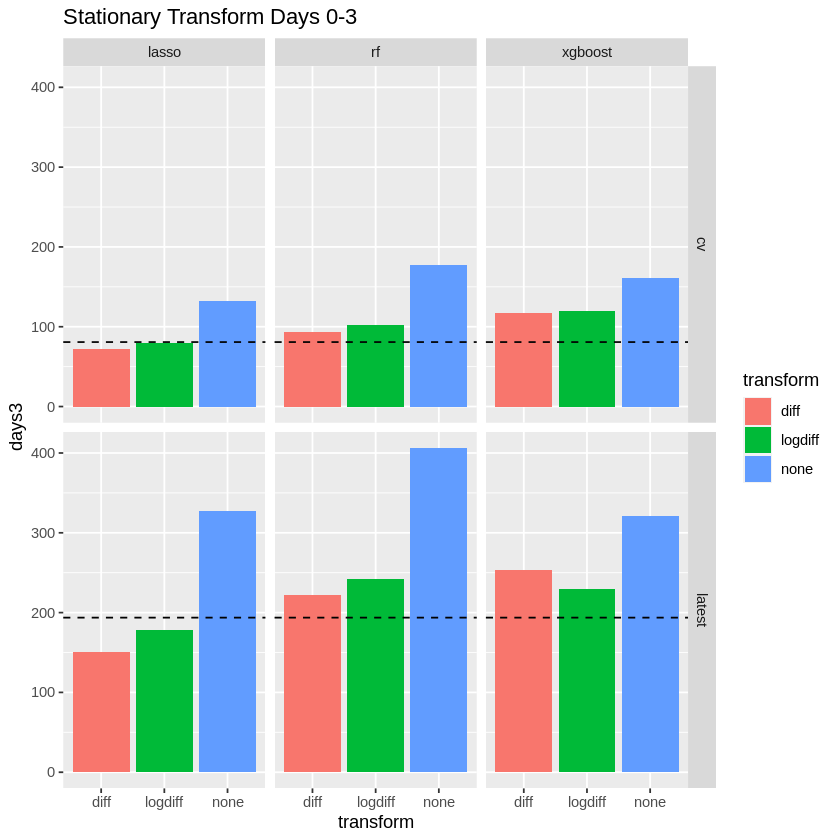

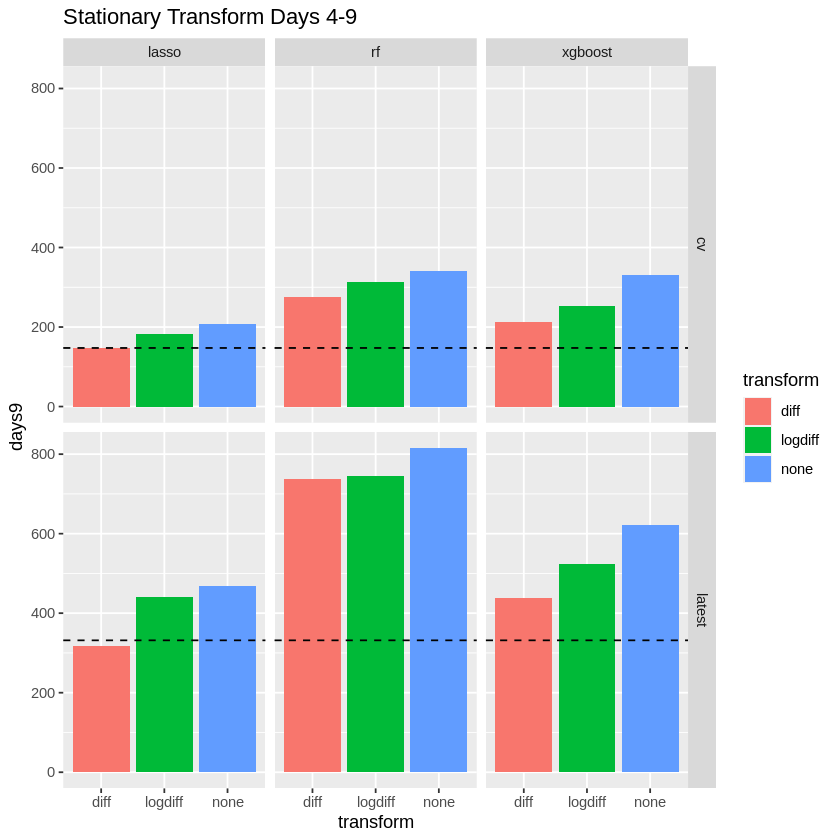

In [ ]:
df_errors %>%
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>% 
  filter(grepl('transform', test_name)) %>% 
  mutate(transform = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>% 
  ggplot(aes(x = transform, y = days3, fill = transform)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') + 
  geom_hline(aes(yintercept = cflo_days3), linetype = 'dashed') +
  ggtitle('Stationary Transform Days 0-3')

df_errors %>%
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>% 
  filter(grepl('transform', test_name)) %>% 
  mutate(transform = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>% 
  ggplot(aes(x = transform, y = days9, fill = transform)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days9), linetype = 'dashed') +
  ggtitle('Stationary Transform Days 4-9')

Code:

In [ ]:
# transform_none_lasso
model_exp['transform_none_lasso'] <- gen_model(
  name = 'transform_none_lasso',
  data = df_hours_features,
  stationary_transform = 'none',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso'
)

# transform_none_rf
model_exp['transform_none_rf'] <- gen_model(
  name = 'transform_none_rf',
  data = df_hours_features,
  stationary_transform = 'none',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf'
)

# transform_none_xgboost
model_exp['transform_none_xgboost'] <- gen_model(
  name = 'transform_none_xgboost',
  data = df_hours_features,
  stationary_transform = 'none',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost'
)

# transform_diff_lasso
model_exp['transform_diff_lasso'] <- gen_model(
  name = 'transform_diff_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso'
)

# transform_diff_rf
model_exp['transform_diff_rf'] <- gen_model(
  name = 'transform_diff_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf'
)

# transform_diff_xgboost
model_exp['transform_diff_xgboost'] <- gen_model(
  name = 'transform_diff_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost'
)

# transform_logdiff_lasso
model_exp['transform_logdiff_lasso'] <- gen_model(
  name = 'transform_logdiff_lasso',
  data = df_hours_features,
  stationary_transform = 'log_diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso'
)

# transform_logdiff_rf
model_exp['transform_logdiff_rf'] <- gen_model(
  name = 'transform_logdiff_rf',
  data = df_hours_features,
  stationary_transform = 'log_diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf'
)

# transform_logdiff_xgboost
model_exp['transform_logdiff_xgboost'] <- gen_model(
  name = 'transform_logdiff_xgboost',
  data = df_hours_features,
  stationary_transform = 'log_diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost'
)

### Lag Window

Skip doesn't seem to work too well, but could likely be due to how we are only taking the exact hour of every day when the prices likely rely more on prices closer to the time period of prediction.

20 doesn't seem to significantly boost short term performance, but seems to help for longer term time window. 20 definitely seems more stable overall.

14 seems like a decent balance still.

When narrowing to last window, 20 still seems most stable, even though it isn't the best.

The best way is likely to have longer lookback for longer horizons and shorter lookback for shorter horizons, such that we use a fixed number of predictors for our forecasts.

However, overall differences aren't drastically different, so we'll just stick with 14 days for now.

Plots

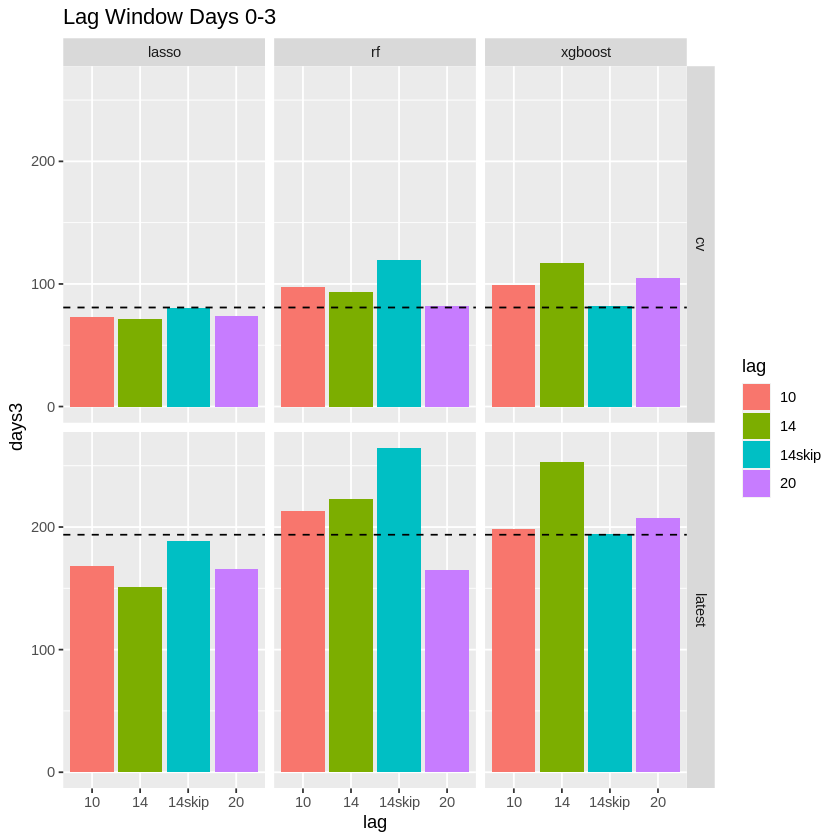

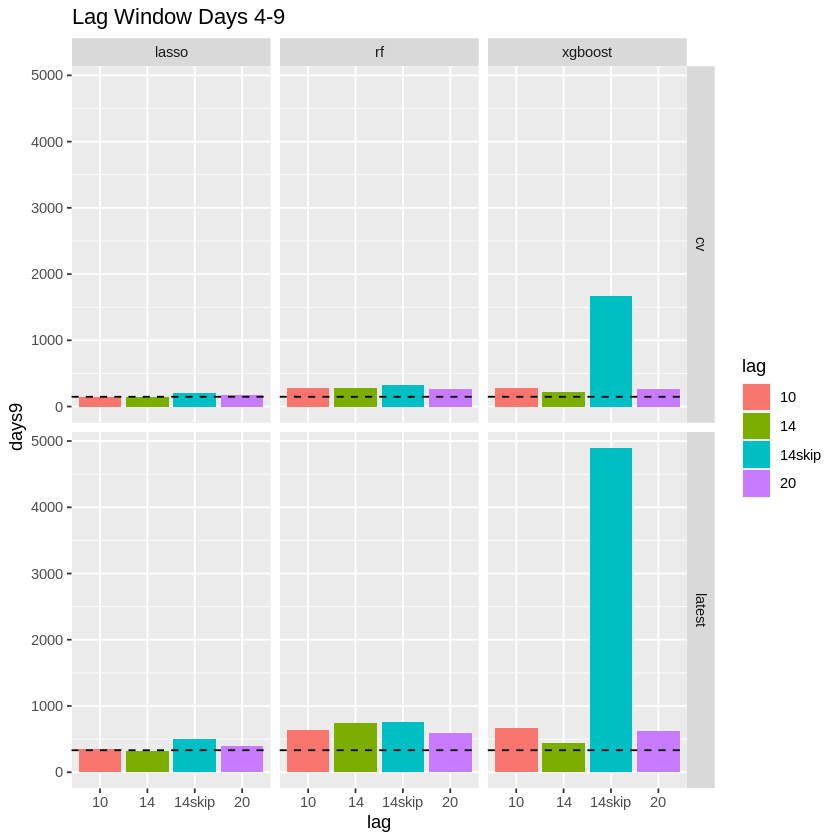

In [ ]:
df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'lag_14')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('lag', test_name)) %>%
  mutate(lag = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = lag, y = days3, fill = lag)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days3), linetype = 'dashed') +
  ggtitle('Lag Window Days 0-3')

df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'lag_14')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('lag', test_name)) %>%
  mutate(lag = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = lag, y = days9, fill = lag)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days9), linetype = 'dashed') +
  ggtitle('Lag Window Days 4-9')

Code

In [ ]:
# lag_10_lasso
model_exp['lag_10_lasso'] <- gen_model(
  name = 'lag_10_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  lag_lookback = c(seq(1, 70))
)

# lag_10_rf
model_exp['lag_10_rf'] <- gen_model(
  name = 'lag_10_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  lag_lookback = c(seq(1, 70))
)

# lag_10_xgboost
model_exp['lag_10_xgboost'] <- gen_model(
  name = 'lag_10_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  lag_lookback = c(seq(1, 70))
)

# lag_20_lasso
model_exp['lag_20_lasso'] <- gen_model(
  name = 'lag_20_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  lag_lookback = c(seq(1, 140))
)

# lag_20_rf
model_exp['lag_20_rf'] <- gen_model(
  name = 'lag_20_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  lag_lookback = c(seq(1, 140))
)

# lag_20_xgboost
model_exp['lag_20_xgboost'] <- gen_model(
  name = 'lag_20_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  lag_lookback = c(seq(1, 140))
)

# lag_14skip_lasso
model_exp['lag_14skip_lasso'] <- gen_model(
  name = 'lag_14skip_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  lag_lookback = c(seq(1, 98, 7))
)

# lag_14skip_rf
model_exp['lag_14skip_rf'] <- gen_model(
  name = 'lag_14skip_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  lag_lookback = c(seq(1, 98, 7))
)

# lag_14skip_xgboost
model_exp['lag_14skip_xgboost'] <- gen_model(
  name = 'lag_14skip_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  lag_lookback = c(seq(1, 98, 7))
)

### Prediction Horizons

Note, lasso here for lots of horizons takes a long time to run.

longer horizons didn't seem to help. having just 1 horizon wasn't too bad either. our 5 horizon default still seems the best. lasso gets better with more horizons.

Plots

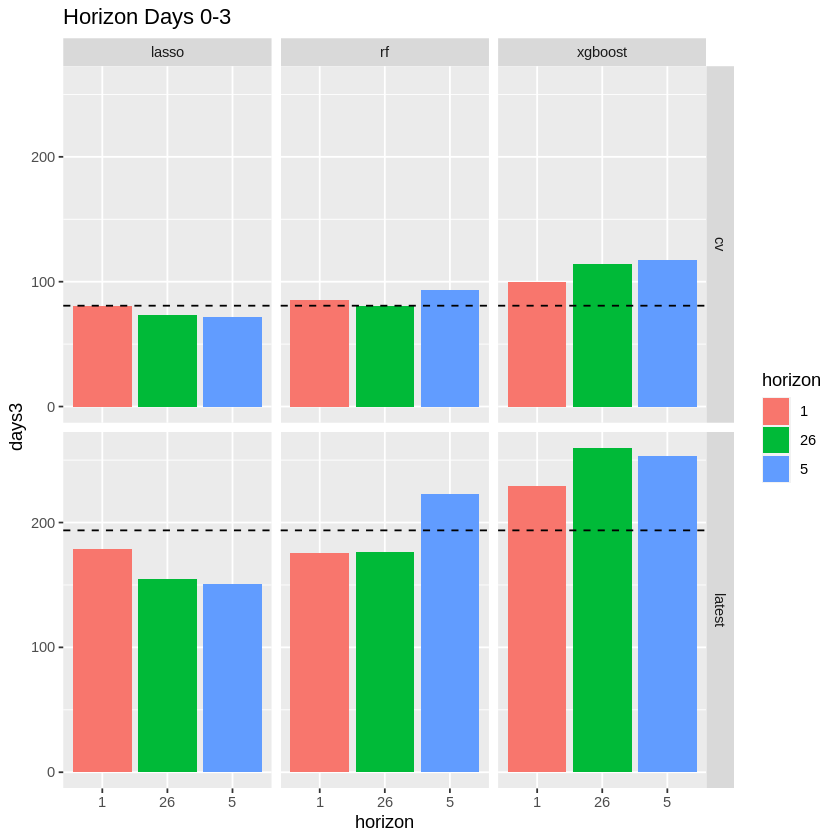

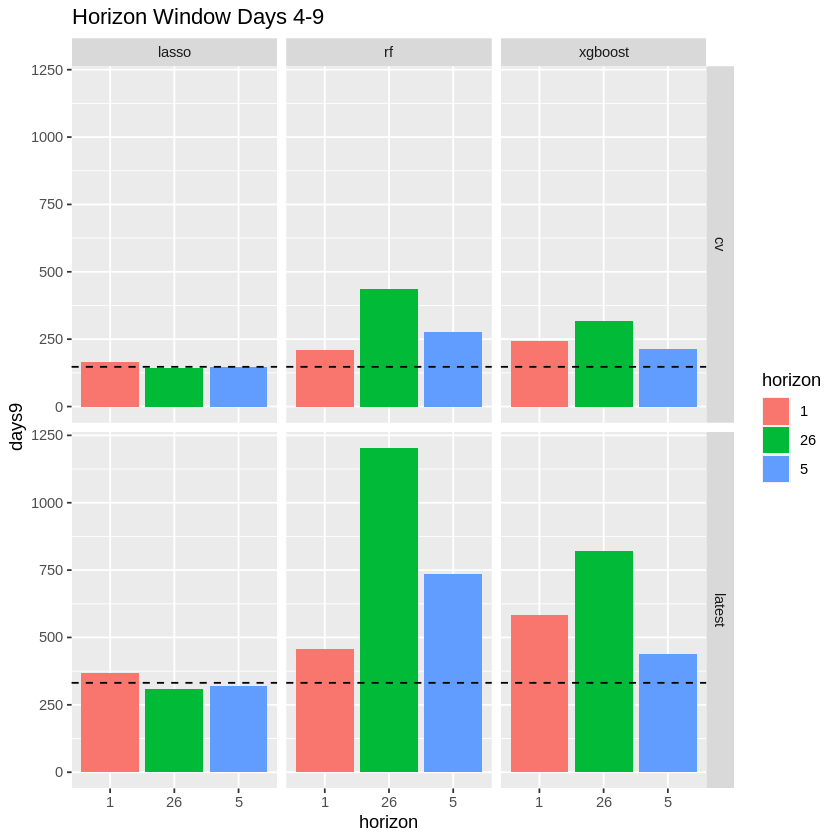

In [ ]:
df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'horizon_5')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('horizon', test_name)) %>%
  mutate(horizon = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = horizon, y = days3, fill = horizon)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days3), linetype = 'dashed') +
  ggtitle('Horizon Days 0-3')

df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'horizon_5')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('horizon', test_name)) %>%
  mutate(horizon = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = horizon, y = days9, fill = horizon)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days9), linetype = 'dashed') +
  ggtitle('Horizon Window Days 4-9')

Code

In [ ]:
# horizon_1_lasso
model_exp['horizon_1_lasso'] <- gen_model(
  name = 'horizon_1_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  horizon_list = c(63)
)

# horizon_1_rf
model_exp['horizon_1_rf'] <- gen_model(
  name = 'horizon_1_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  horizon_list = c(63)
)

# horizon_1_xgboost
model_exp['horizon_1_xgboost'] <- gen_model(
  name = 'horizon_1_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  horizon_list = c(63)
)

# horizon_26_lasso
model_exp['horizon_26_lasso'] <- gen_model(
  name = 'horizon_26_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  horizon_list = c(1:21, seq(28,63,7))
)

# horizon_26_rf
model_exp['horizon_26_rf'] <- gen_model(
  name = 'horizon_26_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  horizon_list = c(1:21, seq(28,63,7))
)

# horizon_26_xgboost
model_exp['horizon_26_xgboost'] <- gen_model(
  name = 'horizon_26_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  horizon_list = c(1:21, seq(28,63,7))
)

### Correlated Symbols

Correlated does very poorly for rf and xgboost in the long term. correlated does extremely well with lasso. separated actually does even better.

If we look at the last window, correlated definitely does well for rf and xgboost compared to sep. separated lasso still does the best. correlated symbols may be inflating the variance of our predictors specifically for lasso and making it it worse, so lasso probably benefits from just training the symbols separately.

For the last 7 days, cflo starts performing much worse since there is likly more variability. lasso somehow holds its error for both the 3 day window and the last 5 day window.

Plots

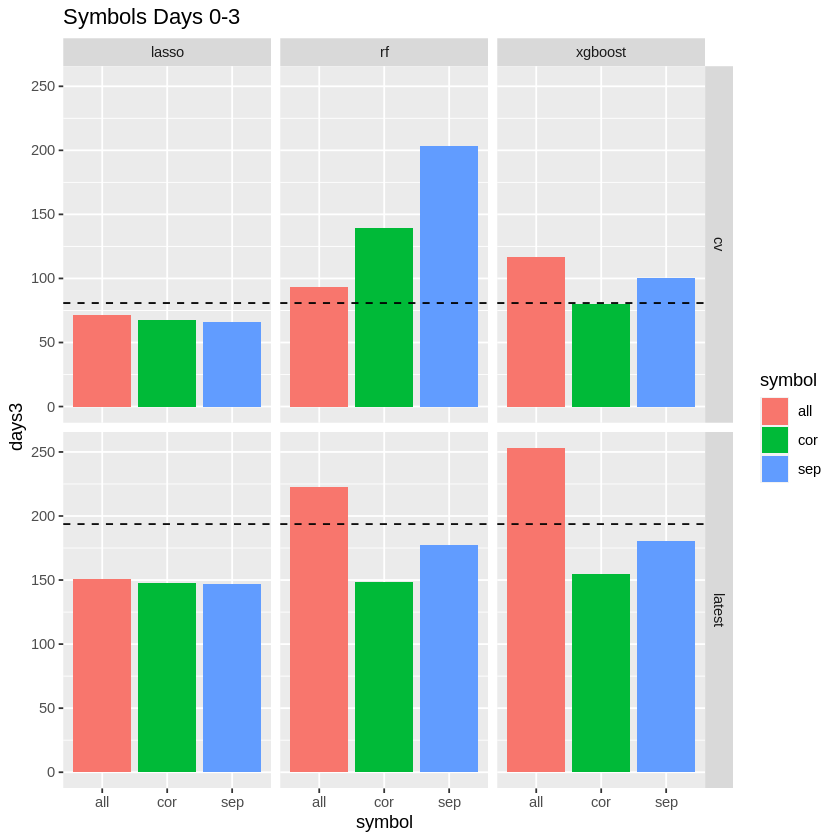

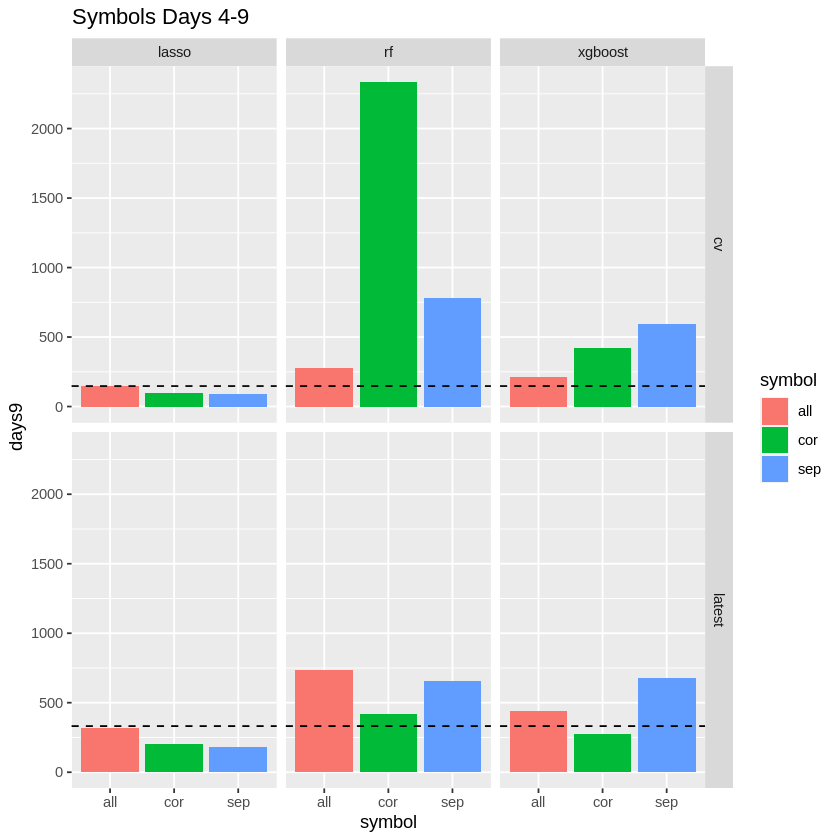

In [ ]:
df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'symbol_all')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('^symbol', test_name)) %>%
  mutate(symbol = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = symbol, y = days3, fill = symbol)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days3), linetype = 'dashed') +
  ggtitle('Symbols Days 0-3')

df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'symbol_all')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('^symbol', test_name)) %>%
  mutate(symbol = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = symbol, y = days9, fill = symbol)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days9), linetype = 'dashed') +
  ggtitle('Symbols Days 4-9')

Code

In [ ]:
# symbol_sep_lasso
model_exp['symbol_sep_lasso'] <- gen_model(
  name = 'symbol_sep_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  symbol_list = LETTERS[1:10]
)

# symbol_sep_rf
model_exp['symbol_sep_rf'] <- gen_model(
  name = 'symbol_sep_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  symbol_list = LETTERS[1:10]
)

# symbol_sep_xgboost
model_exp['symbol_sep_xgboost'] <- gen_model(
  name = 'symbol_sep_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  symbol_list = LETTERS[1:10]
)
# symbol_cor_lasso
model_exp['symbol_cor_lasso'] <- gen_model(
  name = 'symbol_cor_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  symbol_list = list(c("A","B", "C", "D", "E", "F"), c("G"), c("I"), c("H", "J"))
)

# symbol_cor_rf
model_exp['symbol_cor_rf'] <- gen_model(
  name = 'symbol_cor_rf',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'rf',
  symbol_list = list(c("A","B", "C", "D", "E", "F"), c("G"), c("I"), c("H", "J"))
)

# symbol_cor_xgboost
model_exp['symbol_cor_xgboost'] <- gen_model(
  name = 'symbol_cor_xgboost',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'average_day',
    'sd_day',
    'range_day',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'xgboost',
  symbol_list = list(c("A","B", "C", "D", "E", "F"), c("G"), c("I"), c("H", "J"))
)

### Features to Include

Since symbols_sep_lasso has performed the best compared to the other models, we will continue with exploration with this model.

The features we included definitely helps the performance of lasso. Using all the features resulted in the best performance. 

Short term prediction is slightly improved with all the features. long term is also around the same performance, though definitely better than cflo.

Plots

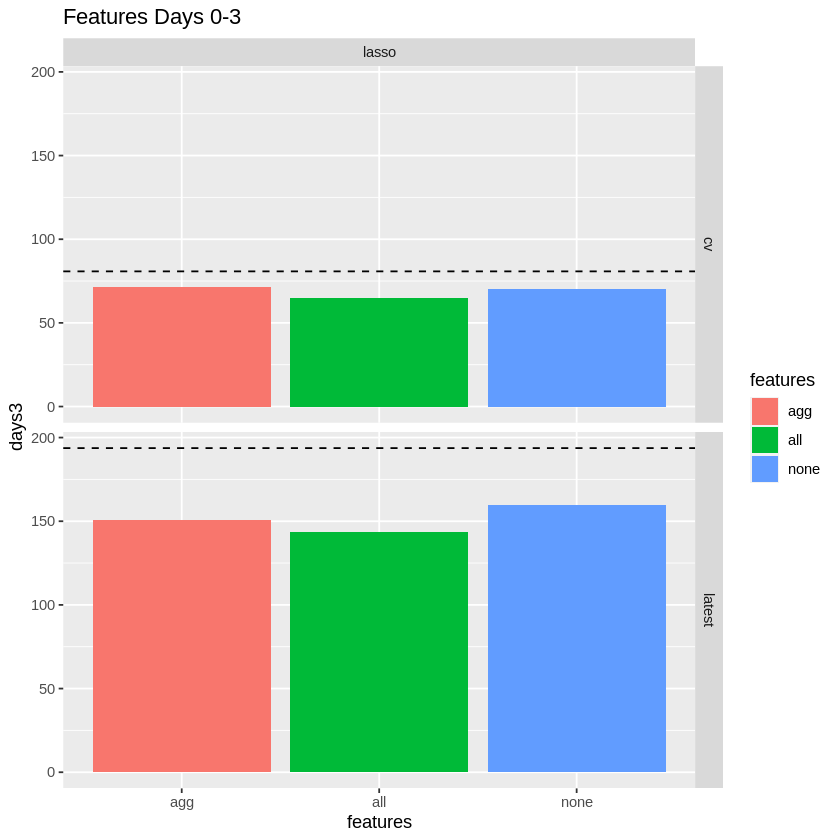

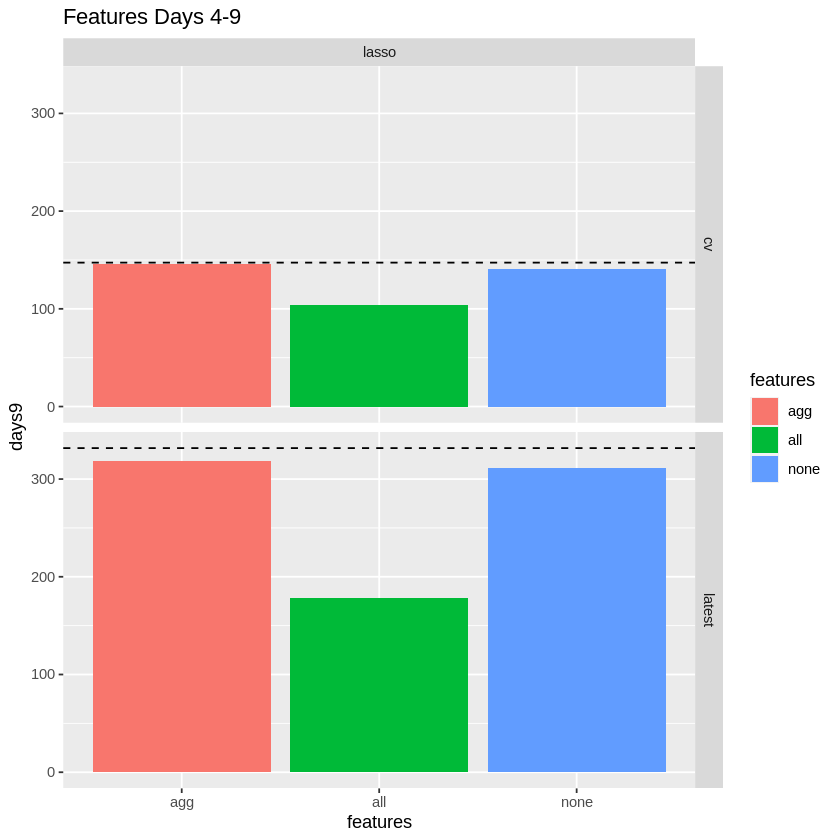

In [ ]:
df_errors %>%
  # transform_diff ran the same settings but with features agg, so we reuse that as features_agg
  mutate(test_name = str_replace(test_name, 'transform_diff', 'features_agg')) %>% 
  # add in cflo baseline
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('features', test_name) & grepl('lasso', test_name) & !grepl('symbol', test_name)) %>%
  # pull out the num features included
  mutate(features = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = features, y = days3, fill = features)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days3), linetype = 'dashed') +
  ggtitle('Features Days 0-3')

df_errors %>%
  mutate(test_name = str_replace(test_name, 'transform_diff', 'features_agg')) %>% 
  inner_join(
    df_errors %>%
      filter(grepl('cflo', test_name)) %>%
      rename(cflo_days3 = days3,
             cflo_days9 = days9) %>%
      select(cflo_days3, cflo_days9, window),
    by = c("window" = "window")
  ) %>%
  mutate(model = str_extract(test_name, "[^_]+$")) %>%
  filter(grepl('features', test_name) & grepl('lasso', test_name) & !grepl('symbol', test_name)) %>%
  mutate(features = str_extract(str_extract(str_extract(test_name, ".*_"), "[^_]+_$"), "[^_]+")) %>%
  ggplot(aes(x = features, y = days9, fill = features)) +
  facet_grid(window ~ model) +
  geom_bar(stat = 'identity') +
  geom_hline(aes(yintercept = cflo_days9), linetype = 'dashed') +
  ggtitle('Features Days 4-9')

Code

In [ ]:
# features_all_lasso
model_exp['features_all_lasso'] <- gen_model(
  name = 'features_all_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'open_day',
    'close_day',
    'high_day',
    'low_day',
    'average_day',
    'sd_day',
    'range_day',
    'open_hours.y',
    'close_hours.y',
    'high_hours.y',
    'low_hours.y',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  symbol_list = LETTERS[1:10]
)

# features_none_lasso
model_exp['features_none_lasso'] <- gen_model(
  name = 'features_none_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'day_of_week'
  ),
  model_name = 'lasso',
  symbol_list = LETTERS[1:10]
)

### Write Model Testing Predictions to CSV

This code writes the results from our model search into a csv. This CSV can be imported via the code in the "Import Test Results" section.

In [ ]:
write_df <- data.frame()
for (testname in ls(model_exp)){
  write_df <- write_df %>% bind_rows(model_exp[[testname]])
}

write.csv(write_df, "model_tests.csv")

## Final Production Results

This is the code we used to generate our final predictions to submit to the competition.

In [ ]:
prod_model <- gen_model(
  name = 'prod_lasso',
  data = df_hours_features,
  stationary_transform = 'diff',
  lag_cols = c(
    'symbol_id',
    'day',
    'hours',
    'open_day',
    'close_day',
    'high_day',
    'low_day',
    'average_day',
    'sd_day',
    'range_day',
    'open_hours.y',
    'close_hours.y',
    'high_hours.y',
    'low_hours.y',
    'average_hours.y',
    'sd_hours.y',
    'range_hours.y',
    'day_of_week'
  ),
  model_name = 'lasso',
  symbol_list = LETTERS[1:10],
  cv_windows = 86
)

In [ ]:
# Generate an empty dataframe for seconds data from days 87 to 95
df_forecast_seconds <- data.frame(
  symbol = LETTERS[1:10],
  open = NA,
  time = "06:00:00",
  day = 87,
  hours = 6,
  minutes = 0,
  seconds = 0,
  time_index = return_time_index(87, 6, 0, 0),
  timestamp_index = as.POSIXct(
    return_time_index(87, 6, 0, 0),
    origin = "2021-01-01",
    tz = "GMT"
  )
)
df_forecast_seconds <- df_forecast_seconds %>%
  add_row(
    symbol = LETTERS[1:10],
    open = NA,
    time = "12:59:55",
    day = 95,
    hours = 12,
    minutes = 59,
    seconds = 55,
    time_index = return_time_index(day, hours, minutes, seconds),
    timestamp_index = as.POSIXct(time_index, origin = "2021-01-01", tz = "GMT")
  ) %>%
  arrange(symbol, time_index) %>%
  fill_gaps(
    date_col = which(colnames(df_forecast_seconds) == 'timestamp_index'),
    frequency = '1 sec',
    groups = 'symbol'
  ) %>% 
  mutate(
    time_index = lookup_timestamp(timestamp_index),
    day = lookup_time_index(time_index)$day,
    hours = lookup_time_index(time_index)$hours,
    minutes = lookup_time_index(time_index)$minutes,
    seconds = lookup_time_index(time_index)$seconds,
    time = sprintf("%02d:%02d:%02d", hours, minutes, seconds)
  )

# Join our hourly predictions to seconds data, using the same hourly prediction for
# all 5-sec intervals in that hour
prod_forecasts <- df_forecast_seconds %>%
  mutate(symbol_id = as.integer(factor(symbol))) %>%
  select(symbol,
         symbol_id,
         day,
         hours,
         minutes,
         seconds,
         time,
         timestamp_index) %>%
  inner_join(
    prod_model %>%
      mutate(
        day = lookup_time_index(lookup_timestamp(forecast_period))$day,
        hours = lookup_time_index(lookup_timestamp(forecast_period))$hours
      ) %>%
      select(test_name, window, symbol_id, outcome_pred_scaled, day, hours),
    by = c(
      "symbol_id" = "symbol_id",
      "day" = "day",
      "hours" = "hours"
    )
  ) %>%
  rename(open = outcome_pred_scaled) %>%
  mutate(id = paste(symbol, '-', day - 87, '-', time, sep = '')) %>%
  arrange(day, time, symbol_id) %>% 
  select(id, open)

# Write submission
write.csv(prod_forecasts, "prod_forecasts.csv", row.names = FALSE)

## Features Kept by Lasso

Our final prod model has like 50 models ensembled together, so it's difficult to do feature analysis. We approximate what features were used by looking at the 3 day and 9 day lasso model that trained all the symbols together.

In [ ]:
lasso_features_model <-
  function(name,
           data = df_hours_features,
           symbol_list = list(LETTERS[1:10]),
           horizon_list = c(1, 7, 21, 42, 63),
           lag_lookback = c(seq(1, 98)),
           stationary_transform = 'diff',
           lag_cols,
           model_name,) {
    w = 86
    # pick the type of stationary transform we want
    outcome_column_name <-
      ifelse(
        stationary_transform == 'diff',
        'open_hours_diff',
        ifelse(
          stationary_transform == 'log_diff',
          'open_hours_log_diff',
          'open_hours'
        )
      )
    
    # Set parameters
    data_load <-
      data %>% filter((day <= w))
    horizons <- horizon_list # 3 days, 9 days
    lookback <- lag_lookback
    dates <- data_load['timestamp_index']
    data_load <-
      data_load %>% select(all_of(outcome_column_name),
                           all_of(lag_cols))
    outcome_col <-
      which(colnames(data_load) == outcome_column_name)
    frequency <- "720 sec" # predict per hour
    dynamic_features <-
      c('day',
        'hours',
        'day_of_week')
    groups <- 'symbol_id'
    
    # Generate lagged df for training data
    data_train <-
      create_lagged_df(
        data_load,
        type = 'train',
        outcome_col = outcome_col,
        horizons = horizons,
        lookback = lookback,
        dates = dates,
        frequency = frequency,
        dynamic_features = dynamic_features,
        groups = groups,
        use_future = FALSE
      )
    
    # Generate lagged df for test/forecast data
    data_forecast_load <-
      create_lagged_df(
        data_load,
        type = 'forecast',
        outcome_col = outcome_col,
        horizons = horizons,
        lookback = lookback,
        dates = dates,
        frequency = frequency,
        dynamic_features = dynamic_features,
        groups = groups,
        use_future = FALSE
      )
    
    # Fill out dynamic forecast features
    for (i in seq_along(data_forecast_load)) {
      data_forecast_load[[i]] <- data_forecast_load[[i]] %>%
        mutate(
          time_index = as.integer(difftime(
            index,
            as.POSIXct(0, origin = "2021-01-01", tz = "GMT"),
            units = "secs"
          )),
          day = lookup_time_index(time_index)$day,
          hours = lookup_time_index(time_index)$hours,
          day_of_week = (day %% 5)
        ) %>%
        select(-time_index)
    } # filling in forecast dynamic features
    
    # train with all data in the current cv window
    windows <-
      create_windows(data_train,
                     window_length = 0)
    
    model_results <- train_model(
      lagged_df = data_train,
      windows = windows,
      model_name = model_name,
      model_function = model_functions[[model_name]],
      use_future = FALSE
    )
    return (model_results)
  }

In [ ]:
lasso_features_model_results <-
  lasso_features_model(
    name = 'prod_lasso',
    data = df_hours_features,
    stationary_transform = 'diff',
    lag_cols = c(
      'symbol_id',
      'day',
      'hours',
      'open_day',
      'close_day',
      'high_day',
      'low_day',
      'average_day',
      'sd_day',
      'range_day',
      'open_hours.y',
      'close_hours.y',
      'high_hours.y',
      'low_hours.y',
      'average_hours.y',
      'sd_hours.y',
      'range_hours.y',
      'day_of_week'
    ),
    model_name = 'lasso',
    symbol_list = LETTERS[1:10]
  )

In [ ]:
lasso_features_21 <- predict(
  lasso_features_model_results$horizon_21$window_1$model$model,
  type = "coefficients",
  s = lasso_features_model_results$horizon_21$window_1$model$model$lambda.min
)[1:1175,]
lasso_features_21[lasso_features_21 != 0]

In [ ]:
lasso_features_63 <- predict(
  lasso_features_model_results$horizon_63$window_1$model$model,
  type = "coefficients",
  s = lasso_features_model_results$horizon_63$window_1$model$model$lambda.min
)[1:545,]
lasso_features_63[lasso_features_63 != 0]

# Submission Results and Comments

In [ ]:
system("gdown --id 18fPJpRDcMoxWMyASndV3wXIKhCQ0oNOf") # prod_forecasts.csv
system("gdown --id 1HFTWmbwmnibaS5LOs1ehA5VmyjeskI8j") # test_solutions.csv

In [ ]:
# Pull in our submission and the solutions
df_pred <- read.csv(file = 'prod_forecasts.csv')
df_answers <- read.csv(file = 'test_solutions.csv')

df_eval <- df_answers %>%
  # combine the submission and solutions
  left_join(df_pred %>% rename(open_pred = open), by = c("id" = "id")) %>%
  # remove missing solution times
  filter(open != -1) %>%
  # add our nice derived time columns
  mutate(
    symbol = sapply(str_split(id, '-'), function(x)
      as.character(x[1])),
    day = sapply(str_split(id, '-'), function(x)
      as.integer(x[2])),
    time = sapply(str_split(id, '-'), function(x)
      as.character(x[3])),
    first_batch = ifelse(day <= 3, 'days 0-3', 'days 4-9'),
    hours = sapply(str_split(time, ':'), function(x)
      as.integer(x[1])),
    minutes = sapply(str_split(time, ':'), function(x)
      as.integer(x[2])),
    seconds = sapply(str_split(time, ':'), function(x)
      as.integer(x[3])),
    time_int = as.integer(hours) * 60 * 60 + as.integer(minutes) * 60 + as.integer(seconds),
    timestamp = as.POSIXct(time_int, origin = "2021-01-01", tz = "GMT"),
    time_index = return_time_index(day, hours, minutes, seconds),
    timestamp_index = as.POSIXct(time_index, origin = "2021-01-01", tz =
                                   "GMT")
  )

df_eval <- df_eval %>%
  # Pull in last price to use for CFLO
  left_join(
    df %>%
      group_by(symbol) %>%
      summarize(last_price = open[which.max(time_index)]),
    by = c("symbol" = "symbol")
  )

# Aggregate to hourly for more efficient plotting
df_eval_hours <- df_eval %>%
  group_by(symbol, day, hours) %>%
  summarize(
    .groups = 'keep',
    open = open[which.min(time_int)],
    open_pred = open_pred[which.min(time_int)],
  ) %>%
  ungroup() %>% 
  mutate(timestamp = as.POSIXct((day * 24 + as.integer(hours)) * 60 * 60, origin =
                                  "2021-01-01", tz = "GMT"),
         time_index = return_time_index(day, hours, 0, 0),
         symbol_id = as.numeric(factor(symbol)))

Plots

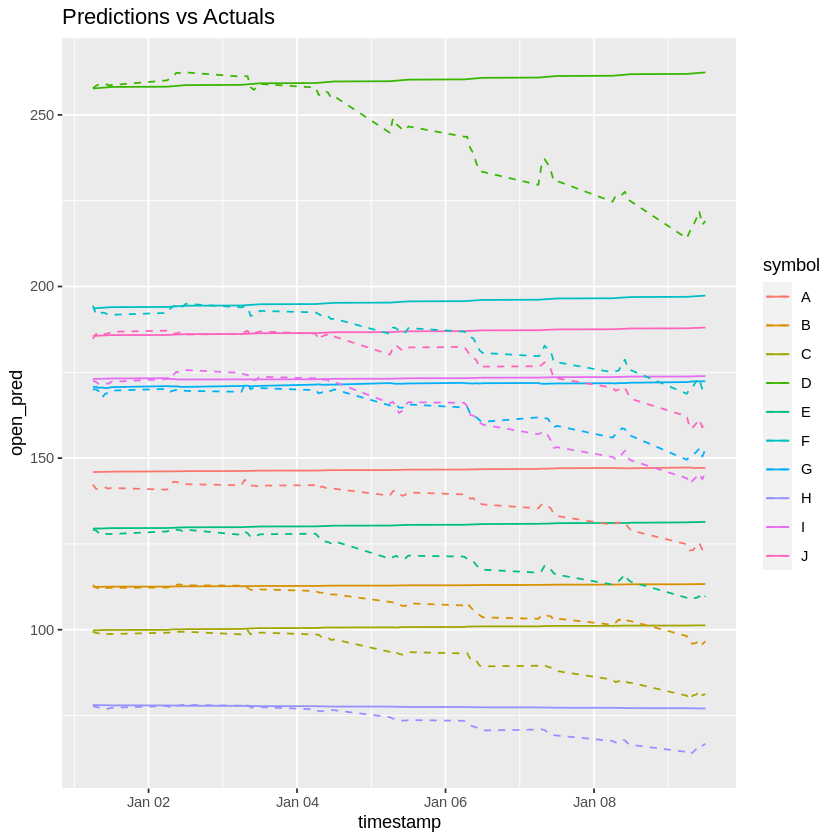

In [ ]:
df_eval_hours %>%
  ggplot(mapping = aes(x = timestamp, group = symbol, color = symbol)) +
  geom_line(aes(y = open_pred)) +
  geom_line(aes(y = open), linetype = "dashed") +
  ggtitle('Predictions vs Actuals')

Our submission errors

In [ ]:
df_eval %>% 
  group_by(first_batch, day, time) %>%
  summarize(.groups = 'keep',
            segment_rmse = sum((open_pred - open) ^ 2)) %>%
  # average the 5 sec segment errors over the day
  group_by(first_batch, day) %>%
  summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
  # average the errors per day over the
  group_by(first_batch) %>%
  summarize(.groups = 'keep', rmse = mean(avg_rmse))

first_batch rmse      
1 days 0-3      48.53686
2 days 4-9    2954.91432

CFLO Baseline

In [ ]:
df_eval %>% 
  group_by(first_batch, day, time) %>%
  summarize(.groups = 'keep',
            segment_rmse = sum((open - last_price) ^ 2)) %>%
  # average the 5 sec segment errors over the day
  group_by(first_batch, day) %>%
  summarize(.groups = 'keep', avg_rmse = mean(segment_rmse)) %>%
  # average the errors per day over the
  group_by(first_batch) %>%
  summarize(.groups = 'keep', rmse = mean(avg_rmse))

first_batch rmse      
1 days 0-3      47.19225
2 days 4-9    2555.65333

# Appendix

## Julie's Missing Data Code

In [ ]:
# Vector of ticker symbols
tickers <- c("A","B","C","D","E","F","G","H","I","J")

# Create column with day concatenated with time_int so that the times are unique
df$day_time_int <- as.numeric(paste0(df$day,df$time_int))

# Find range of days in the data set (day 0 to 86)
day_range <- range(df$day)

# Create vector with all the integer time values (5040 values)
time_series <- seq(from=min(df$time_int), to=max(df$time_int), by=5)

# Create vector that has the day plus the integer time values:

# Repeat the time integers 87 times so that there's a string for each day
full_time_series <- rep(time_series, (day_range[2]-day_range[1]+1))

# Repeat the day labels 5040 times so that "full_time_series" and "day_vector"
# have the same length
day_vector <- rep(0:86, length(time_series))
day_vector <- sort(day_vector)

# Paste the day and time_int together to make unique times
day_time_int_vector <- as.numeric(paste0(day_vector, full_time_series))

# Change vector to data frame and add column label
day_time_int_vector <- data.frame(day_time_int_vector)
colnames(day_time_int_vector) <- c("day_time_int")

# Vector of ticker symbols
tickers <- c("A","B","C","D","E","F","G","H","I","J")

# Ticker A missing values

# Get data frame with one ticker
df_A <- df[df$symbol=="A",]

# Sort data frame by day, then by time
df_A <- df_A[with(df_A, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_A_with_miss <- merge(df_A, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_A_with_miss$open))[1] != 1){
  df_A_with_miss$open[1] <- 
    (df_A_with_miss$open)[which(!is.na(df_A_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_A_with_miss$open))
for(i in index) {
df_A_with_miss[i, "open"] <- df_A_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
day_fill <- rep(day_range[1]:day_range[2], length(time_series))
day_fill <- sort(day_fill)
df_A_with_miss$symbol <- "A"
df_A_with_miss$day <- day_fill

# Ticker B missing values

# Get data frame with one ticker
df_B <- df[df$symbol=="B",]

# Sort data frame by day, then by time
df_B <- df_B[with(df_B, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_B_with_miss <- merge(df_B, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_B_with_miss$open))[1] != 1){
  df_B_with_miss$open[1] <- 
    (df_B_with_miss$open)[which(!is.na(df_B_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_B_with_miss$open))
for(i in index) {
  df_B_with_miss[i, "open"] <- df_B_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_B_with_miss$symbol <- "B"
df_B_with_miss$day <- day_fill

# Ticker C missing values

# Get data frame with one ticker
df_C <- df[df$symbol=="C",]

# Sort data frame by day, then by time
df_C <- df_C[with(df_C, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_C_with_miss <- merge(df_C, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_C_with_miss$open))[1] != 1){
  df_C_with_miss$open[1] <- 
    (df_C_with_miss$open)[which(!is.na(df_C_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_C_with_miss$open))
for(i in index) {
  df_C_with_miss[i, "open"] <- df_C_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_C_with_miss$symbol <- "C"
df_C_with_miss$day <- day_fill

# Ticker D missing values

# Get data frame with one ticker
df_D <- df[df$symbol=="D",]

# Sort data frame by day, then by time
df_D <- df_D[with(df_D, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_D_with_miss <- merge(df_D, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_D_with_miss$open))[1] != 1){
  df_D_with_miss$open[1] <- 
    (df_D_with_miss$open)[which(!is.na(df_D_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_D_with_miss$open))
for(i in index) {
  df_D_with_miss[i, "open"] <- df_D_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_D_with_miss$symbol <- "D"
df_D_with_miss$day <- day_fill

# Ticker E missing values

# Get data frame with one ticker
df_E <- df[df$symbol=="E",]

# Sort data frame by day, then by time
df_E <- df_E[with(df_E, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_E_with_miss <- merge(df_E, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_E_with_miss$open))[1] != 1){
  df_E_with_miss$open[1] <- 
    (df_E_with_miss$open)[which(!is.na(df_E_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_E_with_miss$open))
for(i in index) {
  df_E_with_miss[i, "open"] <- df_E_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_E_with_miss$symbol <- "E"
df_E_with_miss$day <- day_fill

# Ticker F missing values

# Get data frame with one ticker
df_F <- df[df$symbol=="F",]

# Sort data frame by day, then by time
df_F <- df_F[with(df_F, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_F_with_miss <- merge(df_F, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_F_with_miss$open))[1] != 1){
  df_F_with_miss$open[1] <- 
    (df_F_with_miss$open)[which(!is.na(df_F_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_F_with_miss$open))
for(i in index) {
  df_F_with_miss[i, "open"] <- df_F_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_F_with_miss$symbol <- "F"
df_F_with_miss$day <- day_fill

# Ticker G missing values

# Get data frame with one ticker
df_G <- df[df$symbol=="G",]

# Sort data frame by day, then by time
df_G <- df_G[with(df_G, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_G_with_miss <- merge(df_G, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_G_with_miss$open))[1] != 1){
  df_G_with_miss$open[1] <- 
    (df_G_with_miss$open)[which(!is.na(df_G_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_G_with_miss$open))
for(i in index) {
  df_G_with_miss[i, "open"] <- df_G_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_G_with_miss$symbol <- "G"
df_G_with_miss$day <- day_fill

# Ticker H missing values

# Get data frame with one ticker
df_H <- df[df$symbol=="H",]

# Sort data frame by day, then by time
df_H <- df_H[with(df_H, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_H_with_miss <- merge(df_H, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_H_with_miss$open))[1] != 1){
  df_H_with_miss$open[1] <- 
    (df_H_with_miss$open)[which(!is.na(df_H_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_H_with_miss$open))
for(i in index) {
  df_H_with_miss[i, "open"] <- df_H_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_H_with_miss$symbol <- "H"
df_H_with_miss$day <- day_fill

# Ticker I missing values

# Get data frame with one ticker
df_I <- df[df$symbol=="I",]

# Sort data frame by day, then by time
df_I <- df_I[with(df_I, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_I_with_miss <- merge(df_I, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_I_with_miss$open))[1] != 1){
  df_I_with_miss$open[1] <- 
    (df_I_with_miss$open)[which(!is.na(df_I_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_I_with_miss$open))
for(i in index) {
  df_I_with_miss[i, "open"] <- df_I_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_I_with_miss$symbol <- "I"
df_I_with_miss$day <- day_fill

# Ticker J missing values

# Get data frame with one ticker
df_J <- df[df$symbol=="J",]

# Sort data frame by day, then by time
df_J <- df_J[with(df_J, order(day, time_int)),]

# Merge df with missing values to the list that has all the possible days/times
df_J_with_miss <- merge(df_J, day_time_int_vector, all=TRUE)

# Some tickers (A, D, F, H) have missing values for the first entry (day 0, 6:00).
# Need to set the initial value to the first non-missing value in this case.
# This is a "first observation carried backward" approach.
if(which(!is.na(df_J_with_miss$open))[1] != 1){
  df_J_with_miss$open[1] <- 
    (df_J_with_miss$open)[which(!is.na(df_J_with_miss$open))[1]]
}

# Now perform last observation carried forward to fill in the missing open 
# prices with the last available price.
index <- which(is.na(df_J_with_miss$open))
for(i in index) {
  df_J_with_miss[i, "open"] <- df_J_with_miss[i - 1, "open"]
}

# Fill in missing symbol and day values
df_J_with_miss$symbol <- "J"
df_J_with_miss$day <- day_fill

# Bind the individual dfs with missing data inserted back into a single df
df_with_miss <- rbind(df_A_with_miss,
                      df_B_with_miss,
                      df_C_with_miss,
                      df_D_with_miss,
                      df_E_with_miss,
                      df_F_with_miss,
                      df_G_with_miss,
                      df_H_with_miss,
                      df_I_with_miss,
                      df_J_with_miss)


## Old Version of ForecastML

Fill missing values

In [ ]:
df_day['date'] <- as.Date(df_day$day, origin = '2021-01-01')
df_day_fill <- fill_gaps(df_day, date_col = which(colnames(df_day) == 'date'), frequency = '1 day', groups = 'symbol')
df_day_fill['symbol_id'] <- as.numeric(factor(df_day_fill$symbol))

Create lagged df with features. Holdout the last 9 days as test set.

In [ ]:
df_day_load <- df_day_fill %>% filter(day < 77)
horizons <- c(9)
lookback <- c(1:14) # 2 weeks lookback
dates <- df_day_load['timestamp']
df_day_load <- df_day_load %>% select(-timestamp, -symbol, -day, -date, -high_day, -low_day, -close_day)
outcome_col <- which(colnames(df_day_load) == 'open_day')
frequency <- "1 day"
#dynamic_features <- c('high_day', 'low_day', 'close_day')
groups <- 'symbol_id'
type <- 'train'

df_day_train <-
  create_lagged_df(
    df_day_load,
    type = type,
    outcome_col = outcome_col,
    horizons = horizons,
    lookback = lookback,
    dates = dates,
    frequency = frequency,
    #dynamic_features = dynamic_features,
    groups = groups,
    use_future = FALSE
  )

In [ ]:
df_day_train$horizon_9 %>% head()

open_day symbol_id open_day_lag_9 open_day_lag_10 open_day_lag_11
1 135.54   1         NA             NA              NA             
2 135.03   1         NA             NA              NA             
3 134.27   1         NA             NA              NA             
4 135.32   1         NA             NA              NA             
5 135.86   1         NA             NA              NA             
6 135.69   1         NA             NA              NA             
  open_day_lag_12 open_day_lag_13 open_day_lag_14 average_day_lag_9
1 NA              NA              NA              NA               
2 NA              NA              NA              NA               
3 NA              NA              NA              NA               
4 NA              NA              NA              NA               
5 NA              NA              NA              NA               
6 NA              NA              NA              NA               
  average_day_lag_10 ⋯ range_day_lag_11 range_day_lag_12 range_day_lag_13
1 NA                 ⋯ NA               NA               NA              
2 NA                 ⋯ NA               NA               NA              
3 NA                 ⋯ NA               NA               NA              
4 NA                 ⋯ NA               NA               NA              
5 NA                 ⋯ NA               NA               NA              
6 NA                 ⋯ NA               NA               NA              
  range_day_lag_14 time_index_lag_9 time_index_lag_10 time_index_lag_11
1 NA               NA               NA                NA               
2 NA               NA               NA                NA               
3 NA               NA               NA                NA               
4 NA               NA               NA                NA               
5 NA               NA               NA                NA               
6 NA               NA               NA                NA               
  time_index_lag_12 time_index_lag_13 time_index_lag_14
1 NA                NA                NA               
2 NA                NA                NA               
3 NA                NA                NA               
4 NA                NA                NA               
5 NA                NA                NA               
6 NA                NA                NA

Create cross validation windows

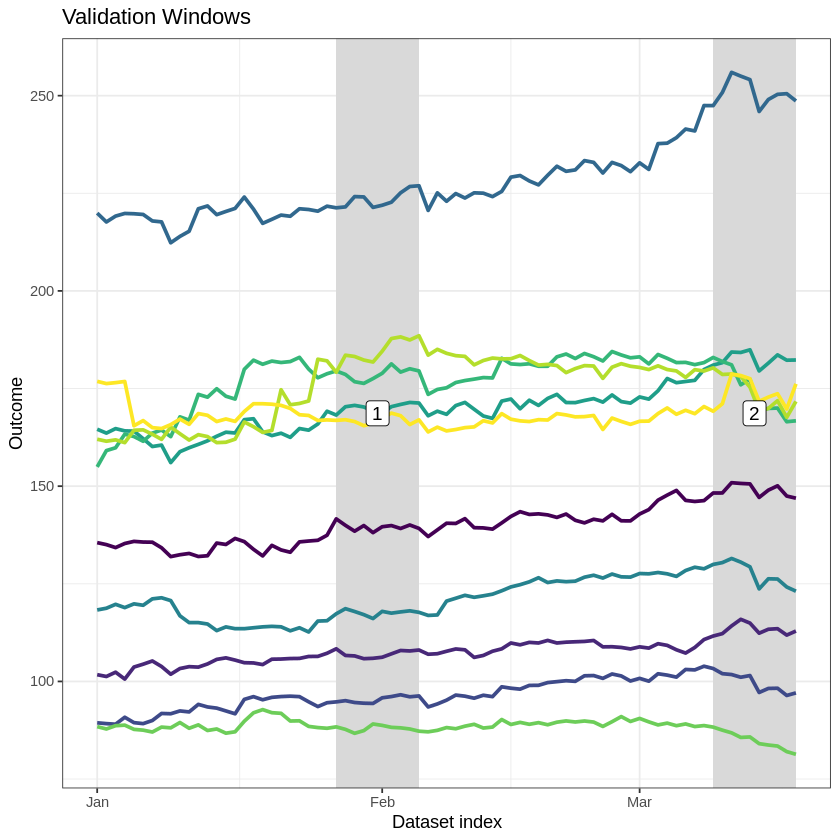

In [ ]:
windows_cv <-
  create_windows(
    df_day_train,
    window_start = c(as.POSIXct(26 * 24 * 60 * 60, origin = "2021-01-01", tz =
                                "GMT"),
                     as.POSIXct(67 * 24 * 60 * 60, origin = "2021-01-01", tz =
                                "GMT")),
    window_stop = c(as.POSIXct(35 * 24 * 60 * 60, origin = "2021-01-01", tz =
                               "GMT"),
                    as.POSIXct(76 * 24 * 60 * 60, origin = "2021-01-01", tz =
                               "GMT")),
    window_length = 0,
    include_partial_window = FALSE
  )

plot(windows_cv, df_day_train) + theme(legend.position = "none")

In [ ]:
# The value of outcome_col can also be set in train_model() with train_model(outcome_col = 1).
model_function <- function(data, outcome_col = 1) {
  
  # xgboost cannot handle missing outcomes data.
  data <- data[!is.na(data[, outcome_col]), ]

  indices <- 1:nrow(data)
  
  set.seed(224)
  train_indices <- sample(1:nrow(data), ceiling(nrow(data) * .8), replace = FALSE)
  test_indices <- indices[!(indices %in% train_indices)]

  data_train <- xgboost::xgb.DMatrix(data = as.matrix(data[train_indices, 
                                                           -(outcome_col), drop = FALSE]),
                                     label = as.matrix(data[train_indices, 
                                                            outcome_col, drop = FALSE]))

  data_test <- xgboost::xgb.DMatrix(data = as.matrix(data[test_indices, 
                                                          -(outcome_col), drop = FALSE]),
                                    label = as.matrix(data[test_indices, 
                                                           outcome_col, drop = FALSE]))

  params <- list("objective" = "reg:squarederror")
  watchlist <- list(train = data_train, test = data_test)
  
  set.seed(224)
  model <- xgboost::xgb.train(data = data_train, params = params, 
                              max.depth = 8, nthread = 2, nrounds = 30,
                              metrics = "rmse", verbose = 0, 
                              early_stopping_rounds = 5, 
                              watchlist = watchlist)

  return(model)
}

model_results_cv <- train_model(
  lagged_df = df_day_train,
  windows = windows_cv,
  model_name = "xgboost",
  model_function = model_function,
  use_future = FALSE
)

[11:16:12] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:16:12] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Cross Validation Errors

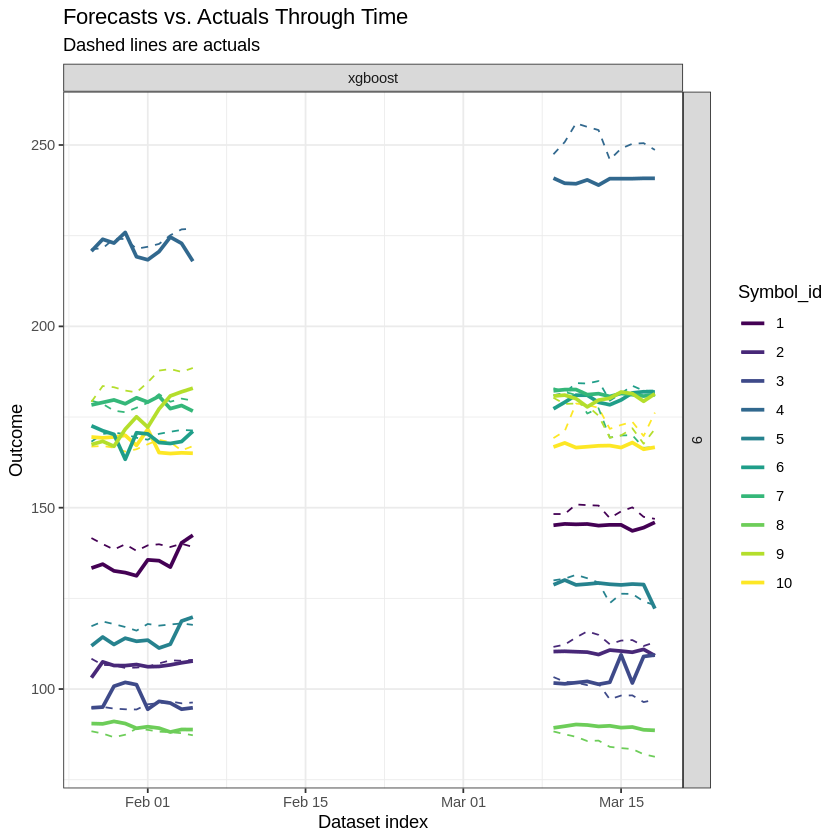

In [ ]:
# If 'model' is passed as a named list, the prediction model would be accessed with model$model or model["model"].
prediction_function <- function(model, data_features) {
  x <- xgboost::xgb.DMatrix(data = as.matrix(data_features))
  data_pred <- data.frame("y_pred" = predict(model, x))
                          #"y_pred_lower" = predict(model, x) - 2,  # Optional; in practice, forecast bounds are not hard coded.
                          #"y_pred_upper" = predict(model, x) + 2)  # Optional; in practice, forecast bounds are not hard coded.
  return(data_pred)
}
data_pred_cv <- predict(model_results_cv, prediction_function = list(prediction_function), data = df_day_train)
plot(data_pred_cv) + theme(legend.position = "right")

Warning message in return_error(data_pred_cv):
“'rmsse' was not calculated. The 'rmsse' metric needs a dataset of actuals passed in 'data_test' and 'test_indices'.”


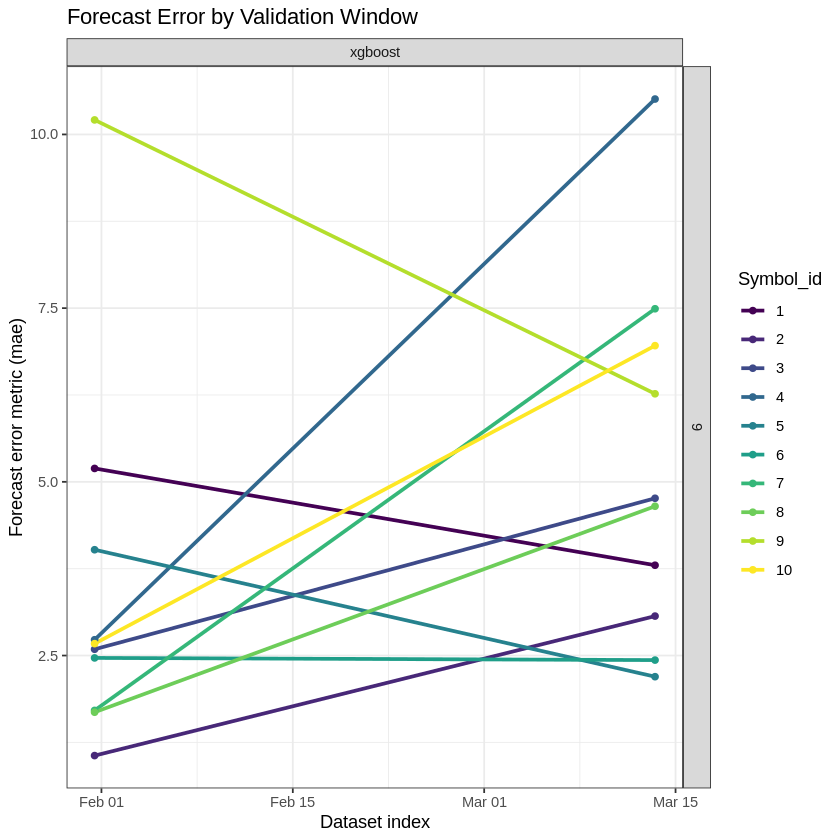

In [ ]:
data_error <- return_error(data_pred_cv)

plot(data_error, type = "window", metric = "mae")

Forecast our held out 9 days with full trained model (76 days)

[11:16:14] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "metrics" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




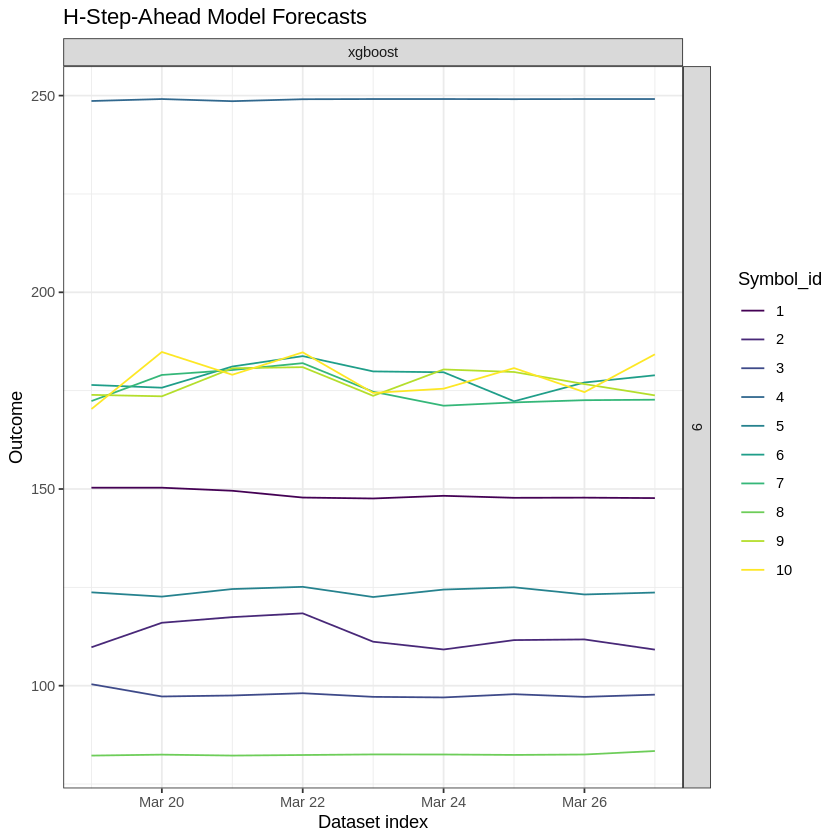

In [ ]:
df_day_load <- df_day_fill %>% filter(day < 77)
horizons <- c(9)
lookback <- c(1:14) # 2 weeks lookback
dates <- df_day_load['timestamp']
df_day_load <- df_day_load %>% select(-timestamp, -symbol, -day, -date, -high_day, -low_day, -close_day)
outcome_col <- which(colnames(df_day_load) == 'open_day')
frequency <- "1 day"
#dynamic_features <- c('high_day', 'low_day', 'close_day')
groups <- 'symbol_id'
type <- "forecast"  # Create a forecasting dataset for our predict() function.

df_day_forecast <-
  create_lagged_df(
    df_day_load,
    type = type,
    outcome_col = outcome_col,
    horizons = horizons,
    lookback = lookback,
    dates = dates,
    frequency = frequency,
    #dynamic_features = dynamic_features,
    groups = groups,
    use_future = FALSE
  )

windows_no_cv <-
  create_windows(
    df_day_train,
    window_length = 0
  )

model_results_no_cv <- train_model(
  lagged_df = df_day_train,
  windows = windows_no_cv,
  model_name = "xgboost",
  model_function = model_function,
  use_future = FALSE
)

data_forecasts <- predict(model_results_no_cv, prediction_function = list(prediction_function), data = df_day_forecast)
plot(data_forecasts)

In [ ]:
head(df_day_forecast$horizon_9)

index      horizon symbol_id open_day_lag_9 open_day_lag_10 open_day_lag_11
1 2021-03-19 1       1         148.26         148.25          146.30         
2 2021-03-20 2       1         150.89         148.26          148.25         
3 2021-03-21 3       1         150.70         150.89          148.26         
4 2021-03-22 4       1         150.58         150.70          150.89         
5 2021-03-23 5       1         147.12         150.58          150.70         
6 2021-03-24 6       1         148.98         147.12          150.58         
  open_day_lag_12 open_day_lag_13 open_day_lag_14 average_day_lag_9 ⋯
1 146.08          146.36          148.91          149.5429          ⋯
2 146.30          146.08          146.36          150.8290          ⋯
3 148.25          146.30          146.08          150.0306          ⋯
4 148.26          148.25          146.30          149.1073          ⋯
5 150.89          148.26          148.25          148.8489          ⋯
6 150.70          150.89          148.26          149.0604          ⋯
  range_day_lag_11 range_day_lag_12 range_day_lag_13 range_day_lag_14
1 2.37             1.75             1.81             2.81            
2 1.54             2.37             1.75             1.81            
3 2.09             1.54             2.37             1.75            
4 2.15             2.09             1.54             2.37            
5 1.98             2.15             2.09             1.54            
6 2.61             1.98             2.15             2.09            
  time_index_lag_9 time_index_lag_10 time_index_lag_11 time_index_lag_12
1 342720           338055            332640            327600           
2 347760           342720            338055            332640           
3 352800           347760            342720            338055           
4 358200           352800            347760            342720           
5 362880           358200            352800            347760           
6 367920           362880            358200            352800           
  time_index_lag_13 time_index_lag_14
1 322920            317520           
2 327600            322920           
3 332640            327600           
4 338055            332640           
5 342720            338055           
6 347760            342720

In [ ]:
data_forecasts %>% head(18)

model   model_forecast_horizon horizon window_length window_number
1  xgboost 9                      1       0             1            
2  xgboost 9                      2       0             1            
3  xgboost 9                      3       0             1            
4  xgboost 9                      4       0             1            
5  xgboost 9                      5       0             1            
6  xgboost 9                      6       0             1            
7  xgboost 9                      7       0             1            
8  xgboost 9                      8       0             1            
9  xgboost 9                      9       0             1            
10 xgboost 9                      1       0             1            
11 xgboost 9                      2       0             1            
12 xgboost 9                      3       0             1            
13 xgboost 9                      4       0             1            
14 xgboost 9                      5       0             1            
15 xgboost 9                      6       0             1            
16 xgboost 9                      7       0             1            
17 xgboost 9                      8       0             1            
18 xgboost 9                      9       0             1            
   forecast_period symbol_id open_day_pred
1  2021-03-19      1         150.3260     
2  2021-03-20      1         150.3319     
3  2021-03-21      1         149.5513     
4  2021-03-22      1         147.8259     
5  2021-03-23      1         147.5898     
6  2021-03-24      1         148.2694     
7  2021-03-25      1         147.7619     
8  2021-03-26      1         147.8000     
9  2021-03-27      1         147.6903     
10 2021-03-19      2         109.7722     
11 2021-03-20      2         115.9990     
12 2021-03-21      2         117.4343     
13 2021-03-22      2         118.3907     
14 2021-03-23      2         111.1818     
15 2021-03-24      2         109.2048     
16 2021-03-25      2         111.5917     
17 2021-03-26      2         111.7615     
18 2021-03-27      2         109.1713

In [ ]:
day_results <- data_forecasts %>%
  left_join(
    select(df_day_fill, timestamp, symbol_id, open_day),
    by = c("symbol_id" = "symbol_id", "forecast_period" = "timestamp")
  )

In [ ]:
day_results %>% filter(symbol_id == 1)

model   model_forecast_horizon horizon window_length window_number
1 xgboost 9                      1       0             1            
2 xgboost 9                      2       0             1            
3 xgboost 9                      3       0             1            
4 xgboost 9                      4       0             1            
5 xgboost 9                      5       0             1            
6 xgboost 9                      6       0             1            
7 xgboost 9                      7       0             1            
8 xgboost 9                      8       0             1            
9 xgboost 9                      9       0             1            
  forecast_period symbol_id open_day_pred open_day
1 2021-03-19      1         150.3260      145.91  
2 2021-03-20      1         150.3319      148.74  
3 2021-03-21      1         149.5513      150.53  
4 2021-03-22      1         147.8259      150.36  
5 2021-03-23      1         147.5898      150.48  
6 2021-03-24      1         148.2694      147.46  
7 2021-03-25      1         147.7619      149.27  
8 2021-03-26      1         147.8000      148.66  
9 2021-03-27      1         147.6903      144.11

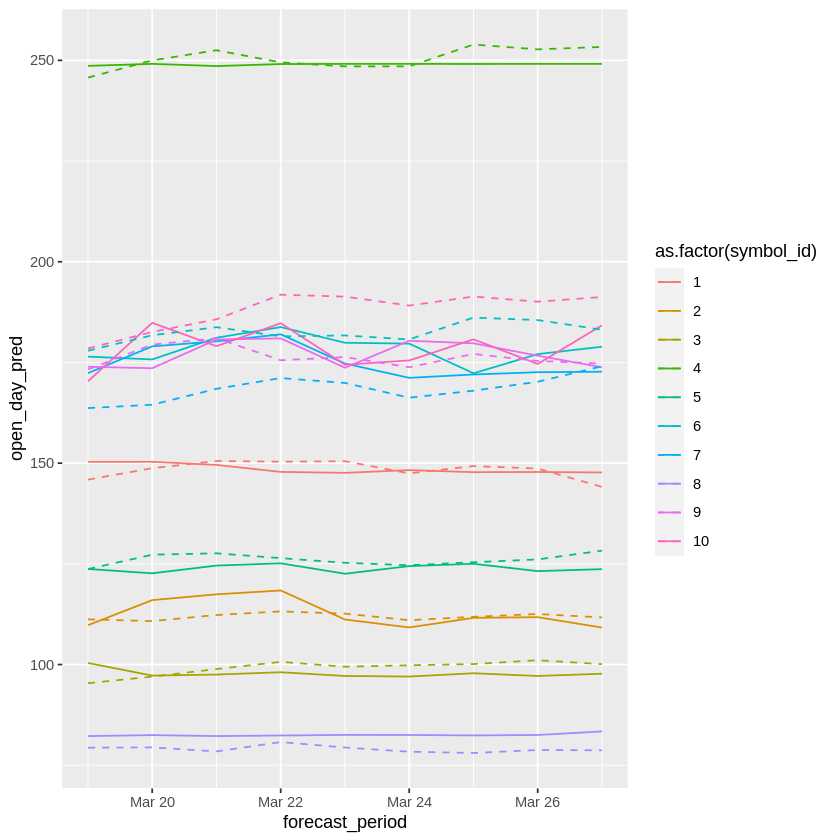

In [ ]:
ggplot(
  data = day_results,
  mapping = aes(x = forecast_period, , group = as.factor(symbol_id), color = as.factor(symbol_id))
) +
  geom_line(aes(y = open_day_pred)) +
  geom_line(aes(y = open_day), linetype = "dashed")